In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import ExtraTreeRegressor
import numpy as np
from lifelines import KaplanMeierFitter                  # the lifelines library allows survival analysis within Python.
from lifelines import CoxPHFitter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import statistics
import time
from IPython.display import display
import warnings 
from sklearn.metrics import matthews_corrcoef,precision_score,recall_score
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score,cross_validate,cross_val_predict
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay,accuracy_score,classification_report,confusion_matrix,roc_auc_score,f1_score,matthews_corrcoef,roc_curve,auc
from sklearn.tree import DecisionTreeClassifier
from tabulate import tabulate
from termcolor import cprint
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier

In [2]:
df = pd.read_csv('project_dataset.csv')
pd.set_option('display.max_columns', None)
df.head()

,sex,disease,yeartx,age,intxsurv,dead,IADL_score14,MOS_physical_score,TUG_score,BOMC_score,racegp,condgrp,atgcampathgp,gvhdgp,karnofcat,graftgp,condted,donorgp,hctcigp,agegp,rel,intxrel,trm,dfs,drigp,pseudoid
0,1,50,2014,53.607118,6.546053,1,14,0,11.00,0,2,2,2,99.0,1,2,2,3,3,1,1,4.934211,0,1,3,30902790
1,2,50,2015,71.225188,8.322368,1,13,18,7.15,4,1,16,3,7.0,1,2,2,4,3,5,1,0.032895,0,1,3,31287145
2,1,50,2016,51.813826,13.125000,0,13,15,7.60,1,1,14,2,5.0,1,2,1,4,3,1,0,13.125000,0,0,2,31723751
3,1,100,2013,62.417522,59.769737,0,14,19,13.00,0,1,16,4,5.0,1,2,2,4,2,3,0,59.769737,0,0,1,32138690
4,2,50,2011,63.682409,3.059211,1,14,0,0.00,0,1,16,2,2.0,1,3,2,9,1,3,0,3.059211,1,1,77,32041982


In [3]:
df.tail()

,sex,disease,yeartx,age,intxsurv,dead,IADL_score14,MOS_physical_score,TUG_score,BOMC_score,racegp,condgrp,atgcampathgp,gvhdgp,karnofcat,graftgp,condted,donorgp,hctcigp,agegp,rel,intxrel,trm,dfs,drigp,pseudoid
325,1,50,2017,72.818617,11.118421,1,14,0,0.00,0,1,14,4,4.0,1,2,2,1,1,5,1,4.177632,0,1,99,26476553
326,2,50,2017,72.624230,3.519737,0,14,18,8.22,4,1,16,3,7.0,1,2,2,4,2,5,1,3.223684,0,1,77,26478484
327,2,50,2017,60.303901,5.986842,0,13,18,7.82,0,1,16,2,4.0,1,2,2,4,3,3,0,5.986842,0,0,77,26603888
328,1,50,2017,67.753593,6.414474,0,14,0,0.00,0,1,14,4,3.1,2,2,1,4,2,4,0,6.414474,0,0,2,26589332
329,1,50,2017,66.951403,6.019737,0,14,0,0.00,0,1,14,4,4.0,2,2,2,1,3,4,1,3.026316,0,1,3,26388444


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330 entries, 0 to 329
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sex                 330 non-null    int64  
 1   disease             330 non-null    int64  
 2   yeartx              330 non-null    int64  
 3   age                 330 non-null    float64
 4   intxsurv            330 non-null    float64
 5   dead                330 non-null    int64  
 6   IADL_score14        330 non-null    int64  
 7   MOS_physical_score  330 non-null    int64  
 8   TUG_score           330 non-null    float64
 9   BOMC_score          330 non-null    int64  
 10  racegp              330 non-null    int64  
 11  condgrp             330 non-null    int64  
 12  atgcampathgp        330 non-null    int64  
 13  gvhdgp              330 non-null    float64
 14  karnofcat           330 non-null    int64  
 15  graftgp             330 non-null    int64  
 16  condted 

Dropping the columns which are not useful for the analysis

In [5]:
df.drop(columns = ['pseudoid','yeartx'],inplace = True)

## Dataset exploration + Feature Engineering

### Get a count of the patient number according to disease type

10     151
50     109
100     23
20      21
30      11
40       9
170      5
80       1
Name: disease, dtype: int64

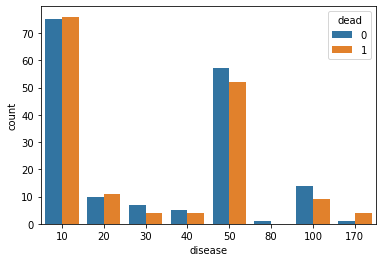

In [6]:
sns.countplot(data=df, x=df['disease'], hue=df["dead"])
df['disease'].value_counts()

### Majority of patients have leukemia type diseases. There are not enough patients with other disease types to allow analysis of those diseases. Therefore, we will just look at leukemia patients to allow a more fair comparison between patients (disease code: from 10-80)

In [7]:
leukemia_df = df.query('(disease == 10) or (disease == 20) or (disease == 30) or (disease == 40) or (disease == 50) or (disease == 80)')
leukemia_df.info()
leukemia_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 302 entries, 0 to 329
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sex                 302 non-null    int64  
 1   disease             302 non-null    int64  
 2   age                 302 non-null    float64
 3   intxsurv            302 non-null    float64
 4   dead                302 non-null    int64  
 5   IADL_score14        302 non-null    int64  
 6   MOS_physical_score  302 non-null    int64  
 7   TUG_score           302 non-null    float64
 8   BOMC_score          302 non-null    int64  
 9   racegp              302 non-null    int64  
 10  condgrp             302 non-null    int64  
 11  atgcampathgp        302 non-null    int64  
 12  gvhdgp              302 non-null    float64
 13  karnofcat           302 non-null    int64  
 14  graftgp             302 non-null    int64  
 15  condted             302 non-null    int64  
 16  donorgp 

,sex,disease,age,intxsurv,dead,IADL_score14,MOS_physical_score,TUG_score,BOMC_score,racegp,condgrp,atgcampathgp,gvhdgp,karnofcat,graftgp,condted,donorgp,hctcigp,agegp,rel,intxrel,trm,dfs,drigp
0,1,50,53.607118,6.546053,1,14,0,11.00,0,2,2,2,99.0,1,2,2,3,3,1,1,4.934211,0,1,3
1,2,50,71.225188,8.322368,1,13,18,7.15,4,1,16,3,7.0,1,2,2,4,3,5,1,0.032895,0,1,3
2,1,50,51.813826,13.125000,0,13,15,7.60,1,1,14,2,5.0,1,2,1,4,3,1,0,13.125000,0,0,2
4,2,50,63.682409,3.059211,1,14,0,0.00,0,1,16,2,2.0,1,3,2,9,1,3,0,3.059211,1,1,77
5,1,10,71.709788,6.019737,0,14,18,4.28,0,1,16,3,7.0,1,2,2,4,3,5,0,6.019737,0,0,2


In [8]:
leukemia_df.tail()

,sex,disease,age,intxsurv,dead,IADL_score14,MOS_physical_score,TUG_score,BOMC_score,racegp,condgrp,atgcampathgp,gvhdgp,karnofcat,graftgp,condted,donorgp,hctcigp,agegp,rel,intxrel,trm,dfs,drigp
325,1,50,72.818617,11.118421,1,14,0,0.00,0,1,14,4,4.0,1,2,2,1,1,5,1,4.177632,0,1,99
326,2,50,72.624230,3.519737,0,14,18,8.22,4,1,16,3,7.0,1,2,2,4,2,5,1,3.223684,0,1,77
327,2,50,60.303901,5.986842,0,13,18,7.82,0,1,16,2,4.0,1,2,2,4,3,3,0,5.986842,0,0,77
328,1,50,67.753593,6.414474,0,14,0,0.00,0,1,14,4,3.1,2,2,1,4,2,4,0,6.414474,0,0,2
329,1,50,66.951403,6.019737,0,14,0,0.00,0,1,14,4,4.0,2,2,2,1,3,4,1,3.026316,0,1,3


 # Handling missing values

### Checking how many rows have missing values (99 in this dataset means missing)

In [9]:
missing_vals = leukemia_df[leukemia_df.eq(99).any(1)]
missing_vals.count()

sex                   28
disease               28
age                   28
intxsurv              28
dead                  28
IADL_score14          28
MOS_physical_score    28
TUG_score             28
BOMC_score            28
racegp                28
condgrp               28
atgcampathgp          28
gvhdgp                28
karnofcat             28
graftgp               28
condted               28
donorgp               28
hctcigp               28
agegp                 28
rel                   28
intxrel               28
trm                   28
dfs                   28
drigp                 28
dtype: int64

### Replacing the datapoints with '99' which means missing, with NaN.

In [10]:
leukemia_df.where(leukemia_df != 99, inplace=True)      # replaces 99 with NaN in the dataframe

C:\Users\zara2\anaconda3\lib\site-packages\pandas\core\generic.py:8918: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._where(


In [11]:
leukemia_df

,sex,disease,age,intxsurv,dead,IADL_score14,MOS_physical_score,TUG_score,BOMC_score,racegp,condgrp,atgcampathgp,gvhdgp,karnofcat,graftgp,condted,donorgp,hctcigp,agegp,rel,intxrel,trm,dfs,drigp
0,1,50,53.607118,6.546053,1,14,0,11.00,0,2.0,2,2.0,NaN,1.0,2,2.0,3,3.0,1,1,4.934211,0,1,3.0
1,2,50,71.225188,8.322368,1,13,18,7.15,4,1.0,16,3.0,7.0,1.0,2,2.0,4,3.0,5,1,0.032895,0,1,3.0
2,1,50,51.813826,13.125000,0,13,15,7.60,1,1.0,14,2.0,5.0,1.0,2,1.0,4,3.0,1,0,13.125000,0,0,2.0
4,2,50,63.682409,3.059211,1,14,0,0.00,0,1.0,16,2.0,2.0,1.0,3,2.0,9,1.0,3,0,3.059211,1,1,77.0
5,1,10,71.709788,6.019737,0,14,18,4.28,0,1.0,16,3.0,7.0,1.0,2,2.0,4,3.0,5,0,6.019737,0,0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,1,50,72.818617,11.118421,1,14,0,0.00,0,1.0,14,4.0,4.0,1.0,2,2.0,1,1.0,5,1,4.177632,0,1,NaN
326,2,50,72.624230,3.519737,0,14,18,8.22,4,1.0,16,3.0,7.0,1.0,2,2.0,4,2.0,5,1,3.223684,0,1,77.0
327,2,50,60.303901,5.986842,0,13,18,7.82,0,1.0,16,2.0,4.0,1.0,2,2.0,4,3.0,3,0,5.986842,0,0,77.0
328,1,50,67.753593,6.414474,0,14,0,0.00,0,1.0,14,4.0,3.1,2.0,2,1.0,4,2.0,4,0,6.414474,0,0,2.0


### Visualise the missing datapoints in a heatmap

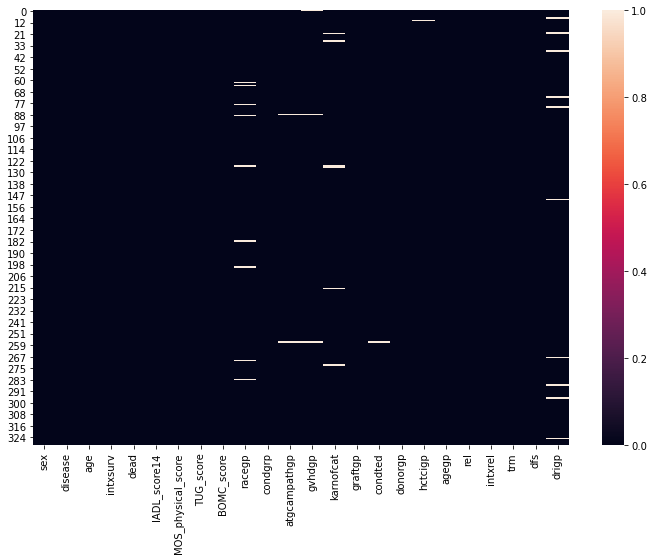

In [12]:
plt.figure(figsize=(12,8))
sns.heatmap(leukemia_df.isnull())

In [13]:
nulls = leukemia_df[leukemia_df.isnull().any(axis=1)]
nulls

,sex,disease,age,intxsurv,dead,IADL_score14,MOS_physical_score,TUG_score,BOMC_score,racegp,condgrp,atgcampathgp,gvhdgp,karnofcat,graftgp,condted,donorgp,hctcigp,agegp,rel,intxrel,trm,dfs,drigp
0,1,50,53.607118,6.546053,1,14,0,11.00,0,2.0,2,2.0,NaN,1.0,2,2.0,3,3.0,1,1,4.934211,0,1,3.0
6,2,50,66.863792,0.888158,1,10,4,49.60,3,1.0,16,4.0,5.0,2.0,2,2.0,1,3.0,4,0,0.888158,1,1,NaN
9,1,10,64.021903,60.526316,0,4,4,9.00,2,1.0,16,4.0,7.0,2.0,2,2.0,1,NaN,3,0,60.526316,0,0,3.0
20,1,50,60.602327,72.532895,0,13,11,30.00,4,1.0,14,2.0,5.0,1.0,2,2.0,4,3.0,3,0,72.532895,0,0,NaN
21,1,50,54.754278,72.763158,0,5,0,0.00,10,1.0,14,4.0,5.0,NaN,2,1.0,1,3.0,1,0,72.763158,0,0,NaN
28,1,10,69.672827,7.401316,1,14,15,8.00,1,1.0,14,2.0,4.0,NaN,1,2.0,5,3.0,4,1,7.368421,0,1,2.0
38,2,50,63.145791,10.526316,1,14,8,9.00,0,1.0,14,4.0,5.0,1.0,2,2.0,4,2.0,3,1,0.032895,0,1,NaN
62,1,20,53.796030,48.355263,0,12,13,13.00,2,NaN,1,2.0,5.0,1.0,2,1.0,5,3.0,1,0,48.355263,0,0,3.0
64,2,40,58.001369,16.513158,1,14,15,5.80,4,NaN,14,4.0,5.0,1.0,1,1.0,1,2.0,2,0,16.513158,1,1,1.0
72,1,50,51.321013,47.335526,0,9,6,5.40,2,1.0,14,4.0,5.0,1.0,2,1.0,5,3.0,1,0,47.335526,0,0,NaN


### Now we can use IterativeImputer to replace the missing values which will reduce the risk of bias in the results. ItertiveImputer was created to imitate MissForest which is considered one of the better methods to replace missing values in a dataset when developing risk prediction model.
#### https://pubmed.ncbi.nlm.nih.gov/17621472/
#### https://towardsdatascience.com/missforest-the-best-missing-data-imputation-algorithm-4d01182aed3
#### https://scikit-learn.org/stable/modules/impute.html

In [14]:
regr = ExtraTreeRegressor()
imp = IterativeImputer(estimator = regr, max_iter=10, random_state=0)
df_t = imp.fit_transform(leukemia_df)

In [15]:
df.columns

Index(['sex', 'disease', 'age', 'intxsurv', 'dead', 'IADL_score14',
       'MOS_physical_score', 'TUG_score', 'BOMC_score', 'racegp', 'condgrp',
       'atgcampathgp', 'gvhdgp', 'karnofcat', 'graftgp', 'condted', 'donorgp',
       'hctcigp', 'agegp', 'rel', 'intxrel', 'trm', 'dfs', 'drigp'],
      dtype='object')

In [16]:
new_df = pd.DataFrame(data=df_t, columns=['sex', 'disease', 'age', 'intxsurv', 'dead', 'IADL_score14',
       'MOS_physical_score', 'TUG_score', 'BOMC_score', 'racegp', 'condgrp',
       'atgcampathgp', 'gvhdgp', 'karnofcat', 'graftgp', 'condted', 'donorgp',
       'hctcigp', 'agegp', 'rel', 'intxrel', 'trm', 'dfs', 'drigp'])
new_df

,sex,disease,age,intxsurv,dead,IADL_score14,MOS_physical_score,TUG_score,BOMC_score,racegp,condgrp,atgcampathgp,gvhdgp,karnofcat,graftgp,condted,donorgp,hctcigp,agegp,rel,intxrel,trm,dfs,drigp
0,1.0,50.0,53.607118,6.546053,1.0,14.0,0.0,11.00,0.0,2.0,2.0,2.0,3.1,1.0,2.0,2.0,3.0,3.0,1.0,1.0,4.934211,0.0,1.0,3.0
1,2.0,50.0,71.225188,8.322368,1.0,13.0,18.0,7.15,4.0,1.0,16.0,3.0,7.0,1.0,2.0,2.0,4.0,3.0,5.0,1.0,0.032895,0.0,1.0,3.0
2,1.0,50.0,51.813826,13.125000,0.0,13.0,15.0,7.60,1.0,1.0,14.0,2.0,5.0,1.0,2.0,1.0,4.0,3.0,1.0,0.0,13.125000,0.0,0.0,2.0
3,2.0,50.0,63.682409,3.059211,1.0,14.0,0.0,0.00,0.0,1.0,16.0,2.0,2.0,1.0,3.0,2.0,9.0,1.0,3.0,0.0,3.059211,1.0,1.0,77.0
4,1.0,10.0,71.709788,6.019737,0.0,14.0,18.0,4.28,0.0,1.0,16.0,3.0,7.0,1.0,2.0,2.0,4.0,3.0,5.0,0.0,6.019737,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,1.0,50.0,72.818617,11.118421,1.0,14.0,0.0,0.00,0.0,1.0,14.0,4.0,4.0,1.0,2.0,2.0,1.0,1.0,5.0,1.0,4.177632,0.0,1.0,3.0
298,2.0,50.0,72.624230,3.519737,0.0,14.0,18.0,8.22,4.0,1.0,16.0,3.0,7.0,1.0,2.0,2.0,4.0,2.0,5.0,1.0,3.223684,0.0,1.0,77.0
299,2.0,50.0,60.303901,5.986842,0.0,13.0,18.0,7.82,0.0,1.0,16.0,2.0,4.0,1.0,2.0,2.0,4.0,3.0,3.0,0.0,5.986842,0.0,0.0,77.0
300,1.0,50.0,67.753593,6.414474,0.0,14.0,0.0,0.00,0.0,1.0,14.0,4.0,3.1,2.0,2.0,1.0,4.0,2.0,4.0,0.0,6.414474,0.0,0.0,2.0


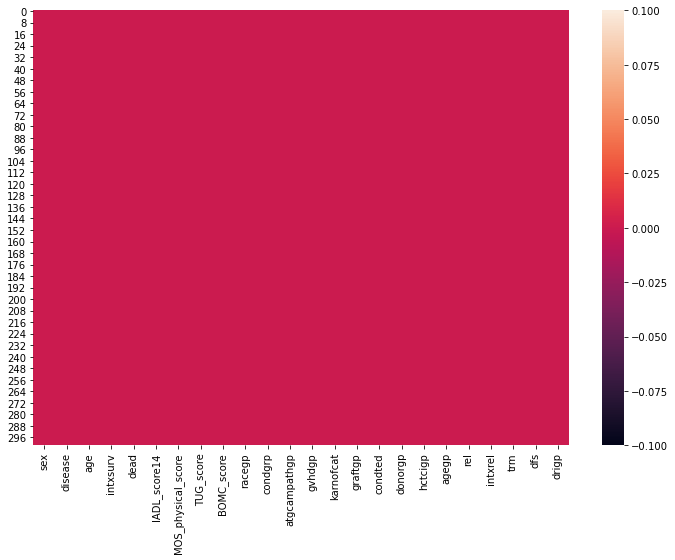

In [17]:
plt.figure(figsize=(12,8))
sns.heatmap(new_df.isnull())

### We no longer have any missing datapoints.
### As all of the columns with missing values were categorical data columns, round the imputed values to the nearest integer so that they clearly represent a particular category.

In [18]:
new_df['racegp'] = new_df['racegp'].round()
new_df['gvhdgp'] = new_df['gvhdgp'].round()
new_df['atgcampathgp'] = new_df['atgcampathgp'].round()
new_df['karnofcat'] = new_df['karnofcat'].round()
new_df['condted'] = new_df['condted'].round()
new_df['hctcigp'] = new_df['hctcigp'].round()
new_df['drigp'] = new_df['drigp'].round()

In [19]:
new_df

,sex,disease,age,intxsurv,dead,IADL_score14,MOS_physical_score,TUG_score,BOMC_score,racegp,condgrp,atgcampathgp,gvhdgp,karnofcat,graftgp,condted,donorgp,hctcigp,agegp,rel,intxrel,trm,dfs,drigp
0,1.0,50.0,53.607118,6.546053,1.0,14.0,0.0,11.00,0.0,2.0,2.0,2.0,3.0,1.0,2.0,2.0,3.0,3.0,1.0,1.0,4.934211,0.0,1.0,3.0
1,2.0,50.0,71.225188,8.322368,1.0,13.0,18.0,7.15,4.0,1.0,16.0,3.0,7.0,1.0,2.0,2.0,4.0,3.0,5.0,1.0,0.032895,0.0,1.0,3.0
2,1.0,50.0,51.813826,13.125000,0.0,13.0,15.0,7.60,1.0,1.0,14.0,2.0,5.0,1.0,2.0,1.0,4.0,3.0,1.0,0.0,13.125000,0.0,0.0,2.0
3,2.0,50.0,63.682409,3.059211,1.0,14.0,0.0,0.00,0.0,1.0,16.0,2.0,2.0,1.0,3.0,2.0,9.0,1.0,3.0,0.0,3.059211,1.0,1.0,77.0
4,1.0,10.0,71.709788,6.019737,0.0,14.0,18.0,4.28,0.0,1.0,16.0,3.0,7.0,1.0,2.0,2.0,4.0,3.0,5.0,0.0,6.019737,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,1.0,50.0,72.818617,11.118421,1.0,14.0,0.0,0.00,0.0,1.0,14.0,4.0,4.0,1.0,2.0,2.0,1.0,1.0,5.0,1.0,4.177632,0.0,1.0,3.0
298,2.0,50.0,72.624230,3.519737,0.0,14.0,18.0,8.22,4.0,1.0,16.0,3.0,7.0,1.0,2.0,2.0,4.0,2.0,5.0,1.0,3.223684,0.0,1.0,77.0
299,2.0,50.0,60.303901,5.986842,0.0,13.0,18.0,7.82,0.0,1.0,16.0,2.0,4.0,1.0,2.0,2.0,4.0,3.0,3.0,0.0,5.986842,0.0,0.0,77.0
300,1.0,50.0,67.753593,6.414474,0.0,14.0,0.0,0.00,0.0,1.0,14.0,4.0,3.0,2.0,2.0,1.0,4.0,2.0,4.0,0.0,6.414474,0.0,0.0,2.0


### To accurately reflect how certain features are used in clinic, we will be creating a new column for 'hctcigp' as patients with 1 or 2 comorbidities are normally combined into a single intermediate group (https://www.mdcalc.com/hematopoietic-cell-transplantation-specific-comorbidity-index-hct-ci#evidence)

In [20]:
def hctci(row):
    if row['hctcigp'] == 1 or row['hctcigp'] == 2:
            return 1.5                                 # will use '1.5' to indicate the group with 1 or 2 comorbidities
    elif row['hctcigp'] == 0:
            return 0
    else:
        return 3

new_df['hctci_group'] = new_df.apply(hctci, axis=1)
new_df[['hctcigp','hctci_group']][:5]

,hctcigp,hctci_group
0,3.0,3.0
1,3.0,3.0
2,3.0,3.0
3,1.0,1.5
4,3.0,3.0


### Create a new column for 'BOMC' to categorise the scores into normal cognitive ability (score <7) and impairment (>=7) - this is the cutoff specified within the research paper that our dataset was taken from.

In [21]:
# BOMC score
def BOMC_cat(row):
    if row['BOMC_score'] < 7:                                       # 0 represents NORMAL cognitive ability
            return 0
    else:
        return 1                                                    # 1 represents IMPAIRED cognitive ability

new_df['BOMC_outcome'] = new_df.apply(BOMC_cat, axis=1)
new_df[['BOMC_score','BOMC_outcome']][:5]

,BOMC_score,BOMC_outcome
0,0.0,0
1,4.0,0
2,1.0,0
3,0.0,0
4,0.0,0


In [22]:
new_df.describe()

,sex,disease,age,intxsurv,dead,IADL_score14,MOS_physical_score,TUG_score,BOMC_score,racegp,condgrp,atgcampathgp,gvhdgp,karnofcat,graftgp,condted,donorgp,hctcigp,agegp,rel,intxrel,trm,dfs,drigp,hctci_group,BOMC_outcome
count,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000
mean,1.417219,26.986755,63.447108,18.717432,0.486755,13.129139,10.192053,8.476689,2.152318,1.125828,12.801325,2.920530,6.284768,1.258278,2.036424,1.662252,3.632450,1.973510,3.105960,0.420530,15.815506,0.195364,0.615894,7.556291,1.961921,0.125828
std,0.493918,18.832885,6.554643,16.520368,0.500654,1.615913,7.828065,5.934337,3.242673,0.562442,7.230904,0.870507,3.691379,0.438414,0.441228,0.473727,2.449627,1.200482,1.332708,0.494463,16.409492,0.397139,0.487190,19.033677,1.173931,0.332206
min,1.000000,10.000000,50.436687,0.822368,0.000000,4.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.032895,0.000000,0.000000,1.000000,0.000000,0.000000
25%,1.000000,10.000000,58.231348,6.126645,0.000000,13.000000,0.000000,6.042500,0.000000,1.000000,14.000000,2.000000,5.000000,1.000000,2.000000,1.000000,1.000000,1.000000,2.000000,0.000000,3.750000,0.000000,0.000000,2.000000,1.500000,0.000000
50%,1.000000,15.000000,63.634497,12.138158,0.000000,14.000000,13.000000,8.695000,0.000000,1.000000,14.000000,3.000000,5.000000,1.000000,2.000000,2.000000,4.000000,3.000000,3.000000,0.000000,8.782895,0.000000,1.000000,2.000000,3.000000,0.000000
75%,2.000000,50.000000,68.709788,28.947368,1.000000,14.000000,18.000000,11.000000,4.000000,1.000000,16.000000,4.000000,7.000000,2.000000,2.000000,2.000000,4.000000,3.000000,4.000000,1.000000,24.111842,0.000000,1.000000,3.000000,3.000000,0.000000
max,2.000000,80.000000,76.758385,72.763158,1.000000,14.000000,20.000000,49.600000,16.000000,8.000000,98.000000,4.000000,20.000000,2.000000,3.000000,2.000000,9.000000,3.000000,5.000000,1.000000,72.763158,1.000000,1.000000,77.000000,3.000000,1.000000


## new IADL column

In [23]:
def IADL_cut(row):
    if row['IADL_score14'] == 14:                                       # 0 represents NORMAL function
            return 0
    else:
        return 1                                                    # 1 represents IMPAIRED 

new_df['IADL'] = new_df.apply(IADL_cut, axis=1)
new_df[['IADL_score14','IADL']][:5]

,IADL_score14,IADL
0,14.0,0
1,13.0,1
2,13.0,1
3,14.0,0
4,14.0,0


## new MOS column

In [24]:
MOS_med = new_df['MOS_physical_score'].median()

def MOS_cut(row):
    if row['MOS_physical_score'] > MOS_med:                                       # 0 represents NORMAL function
            return 0
    else:
        return 1                                                    # 1 represents IMPAIRED 

new_df['MOS'] = new_df.apply(MOS_cut, axis=1)
new_df[['MOS_physical_score','MOS']][:5]

,MOS_physical_score,MOS
0,0.0,1
1,18.0,0
2,15.0,0
3,0.0,1
4,18.0,0


## new TUG column

In [25]:
def TUG_cut(row):
    if row['TUG_score'] < 13.5:                                    # 0 represent NORMAL
        return 0
    else:
        return 1                                                    # 1 represents IMPAIRED 

new_df['TUG'] = new_df.apply(TUG_cut, axis=1)
new_df[['TUG_score','TUG']][:5]

,TUG_score,TUG
0,11.00,0
1,7.15,0
2,7.60,0
3,0.00,0
4,4.28,0


In [26]:
new_df

,sex,disease,age,intxsurv,dead,IADL_score14,MOS_physical_score,TUG_score,BOMC_score,racegp,condgrp,atgcampathgp,gvhdgp,karnofcat,graftgp,condted,donorgp,hctcigp,agegp,rel,intxrel,trm,dfs,drigp,hctci_group,BOMC_outcome,IADL,MOS,TUG
0,1.0,50.0,53.607118,6.546053,1.0,14.0,0.0,11.00,0.0,2.0,2.0,2.0,3.0,1.0,2.0,2.0,3.0,3.0,1.0,1.0,4.934211,0.0,1.0,3.0,3.0,0,0,1,0
1,2.0,50.0,71.225188,8.322368,1.0,13.0,18.0,7.15,4.0,1.0,16.0,3.0,7.0,1.0,2.0,2.0,4.0,3.0,5.0,1.0,0.032895,0.0,1.0,3.0,3.0,0,1,0,0
2,1.0,50.0,51.813826,13.125000,0.0,13.0,15.0,7.60,1.0,1.0,14.0,2.0,5.0,1.0,2.0,1.0,4.0,3.0,1.0,0.0,13.125000,0.0,0.0,2.0,3.0,0,1,0,0
3,2.0,50.0,63.682409,3.059211,1.0,14.0,0.0,0.00,0.0,1.0,16.0,2.0,2.0,1.0,3.0,2.0,9.0,1.0,3.0,0.0,3.059211,1.0,1.0,77.0,1.5,0,0,1,0
4,1.0,10.0,71.709788,6.019737,0.0,14.0,18.0,4.28,0.0,1.0,16.0,3.0,7.0,1.0,2.0,2.0,4.0,3.0,5.0,0.0,6.019737,0.0,0.0,2.0,3.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,1.0,50.0,72.818617,11.118421,1.0,14.0,0.0,0.00,0.0,1.0,14.0,4.0,4.0,1.0,2.0,2.0,1.0,1.0,5.0,1.0,4.177632,0.0,1.0,3.0,1.5,0,0,1,0
298,2.0,50.0,72.624230,3.519737,0.0,14.0,18.0,8.22,4.0,1.0,16.0,3.0,7.0,1.0,2.0,2.0,4.0,2.0,5.0,1.0,3.223684,0.0,1.0,77.0,1.5,0,0,0,0
299,2.0,50.0,60.303901,5.986842,0.0,13.0,18.0,7.82,0.0,1.0,16.0,2.0,4.0,1.0,2.0,2.0,4.0,3.0,3.0,0.0,5.986842,0.0,0.0,77.0,3.0,0,1,0,0
300,1.0,50.0,67.753593,6.414474,0.0,14.0,0.0,0.00,0.0,1.0,14.0,4.0,3.0,2.0,2.0,1.0,4.0,2.0,4.0,0.0,6.414474,0.0,0.0,2.0,1.5,0,0,1,0


# Initial graphs - Visualisation

### We want to see if there is any association between certain features that are assessed in real-life clinics for elderly patients undergoing transplant and their non-relapse mortality/survival. I will also include the new features undergoing research - BOMC, IADL, MOS and TUG score

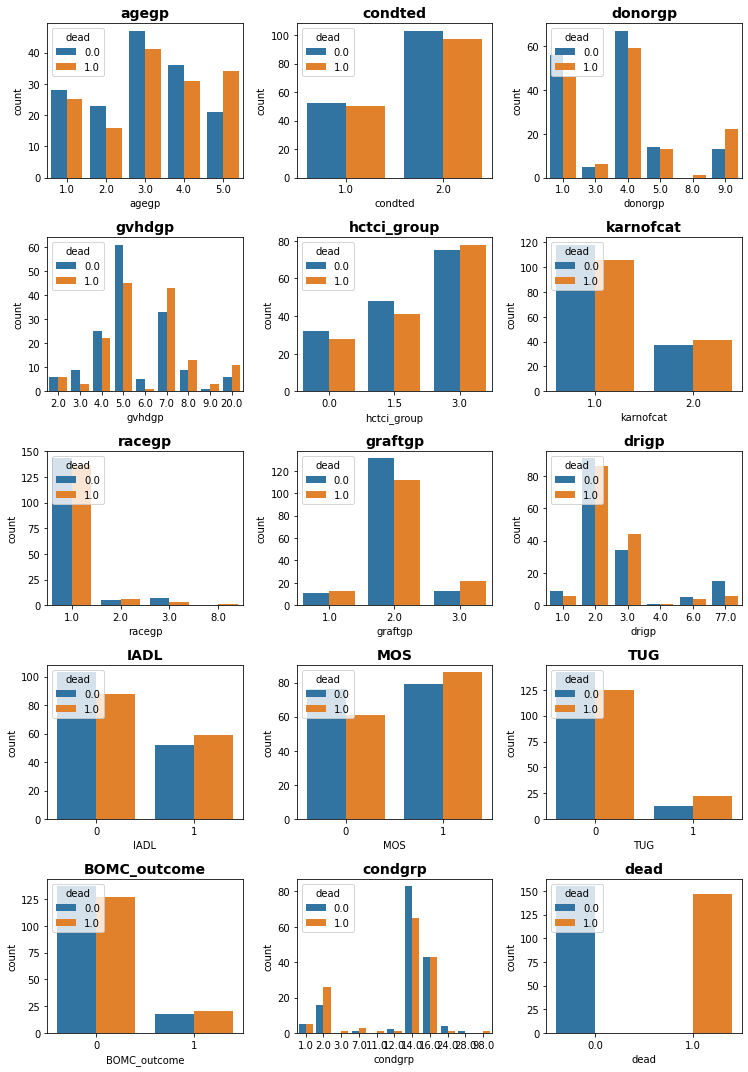

In [27]:
cols = ['agegp', 'condted', 'donorgp', 'gvhdgp', 'hctci_group', 'karnofcat', 'racegp', 'graftgp', 'drigp', 'IADL', 'MOS', 'TUG', 'BOMC_outcome', 'condgrp', 'dead']

nr_rows = 5
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        
        i = r*nr_cols+c       
        ax = axs[r][c]
        sns.countplot(data=new_df, x=new_df[cols[i]], hue=new_df["dead"], ax=ax)
        ax.set_title(cols[i], fontsize=14, fontweight='bold')
        ax.legend(title="dead", loc='upper left') 
        
plt.tight_layout() 

### We will also create barcharts and boxplots to see if there are any patterns between the features and survival, and to also look at the distribution of data

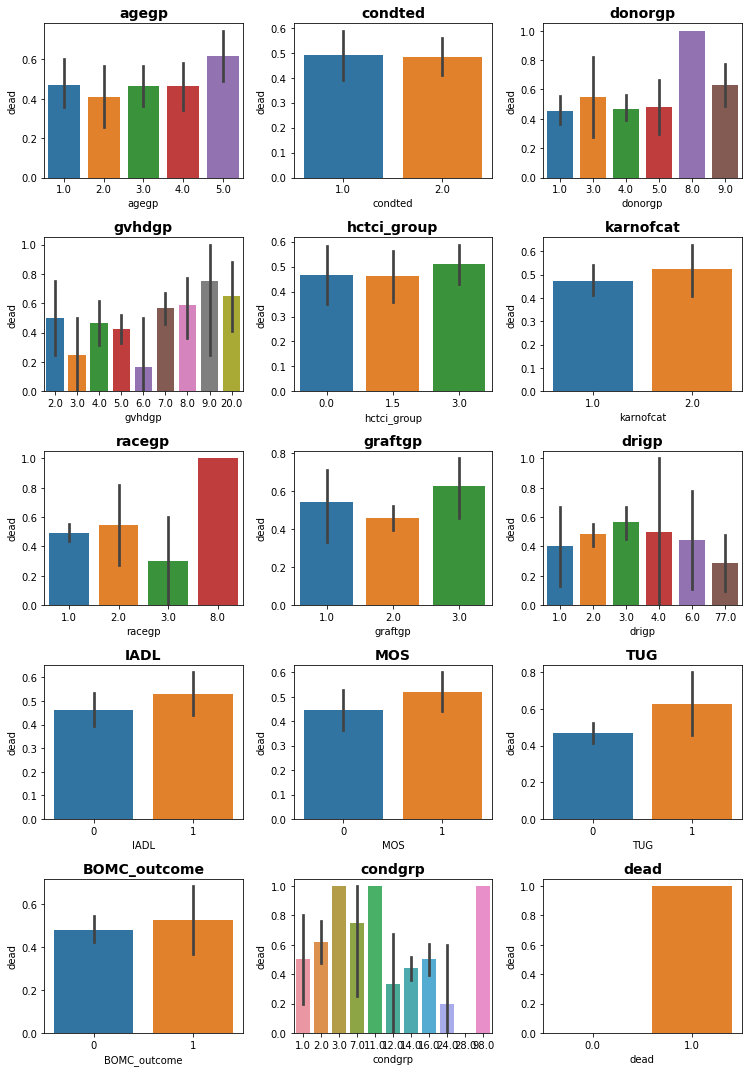

In [28]:
cols = ['agegp', 'condted', 'donorgp', 'gvhdgp', 'hctci_group', 'karnofcat', 'racegp', 'graftgp', 'drigp', 'IADL', 'MOS', 'TUG', 'BOMC_outcome', 'condgrp', 'dead']

nr_rows = 5
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        
        i = r*nr_cols+c       
        ax = axs[r][c]
        sns.barplot(data=new_df, x=new_df[cols[i]], y=new_df["dead"], ax=ax)
        ax.set_title(cols[i], fontsize=14, fontweight='bold')
        #ax.legend(title="dead", loc='upper left') 
        
plt.tight_layout() 

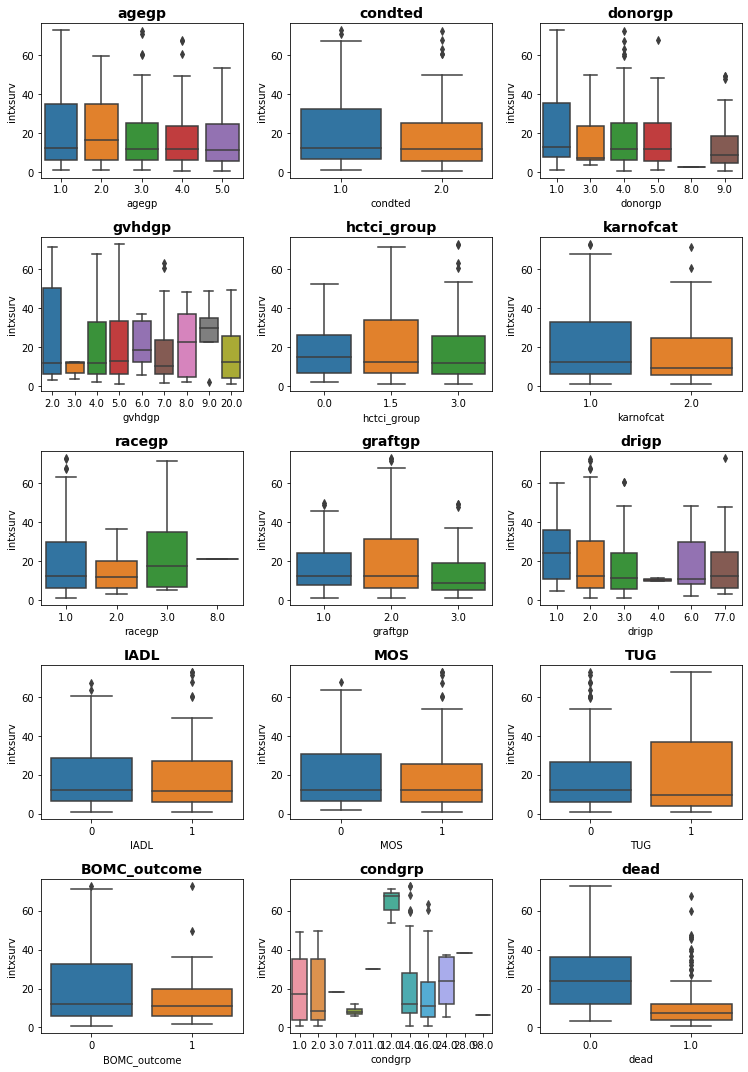

In [29]:
cols = ['agegp', 'condted', 'donorgp', 'gvhdgp', 'hctci_group', 'karnofcat', 'racegp', 'graftgp', 'drigp', 'IADL', 'MOS', 'TUG', 'BOMC_outcome', 'condgrp', 'dead']

nr_rows = 5
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        
        i = r*nr_cols+c       
        ax = axs[r][c]
        sns.boxplot(x=new_df[cols[i]], y='intxsurv', data=new_df, ax=ax)
        ax.set_title(cols[i], fontsize=14, fontweight='bold')
        #ax.legend(title="dead", loc='upper left') 
        
plt.tight_layout() 

### from these we can see that condted, hctci_group, karnofcat, IADL, MOS, TUG and BOMC_outcome all display potential patterns in relation to survival.

## Outliers
From the boxplots above, we can see that there are a few outliers for the features when plotted against intxsurv (which depicts the survival time in months). However, these outliers are valid datapoints which should be kept as some patients may well have a much longer survival time than the average. Survival time can vary drastically from patient to patient.)

### There is also another outcome which may be worth looking at - Disease free survival - which looks at patient relapse.

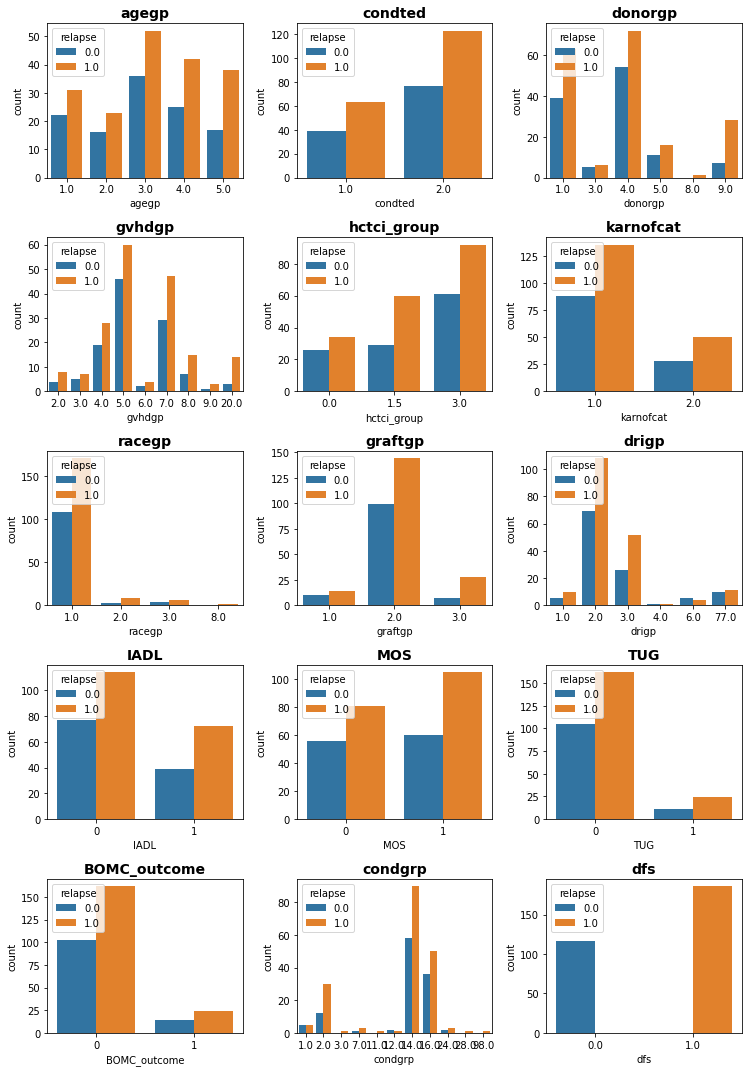

In [30]:
cols = ['agegp', 'condted', 'donorgp', 'gvhdgp', 'hctci_group', 'karnofcat', 'racegp', 'graftgp', 'drigp', 'IADL', 'MOS', 'TUG', 'BOMC_outcome', 'condgrp', 'dfs']

nr_rows = 5
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        
        i = r*nr_cols+c       
        ax = axs[r][c]
        sns.countplot(data=new_df, x=new_df[cols[i]], hue=new_df["dfs"], ax=ax)
        ax.set_title(cols[i], fontsize=14, fontweight='bold')
        ax.legend(title="relapse", loc='upper left') 
        
plt.tight_layout() 

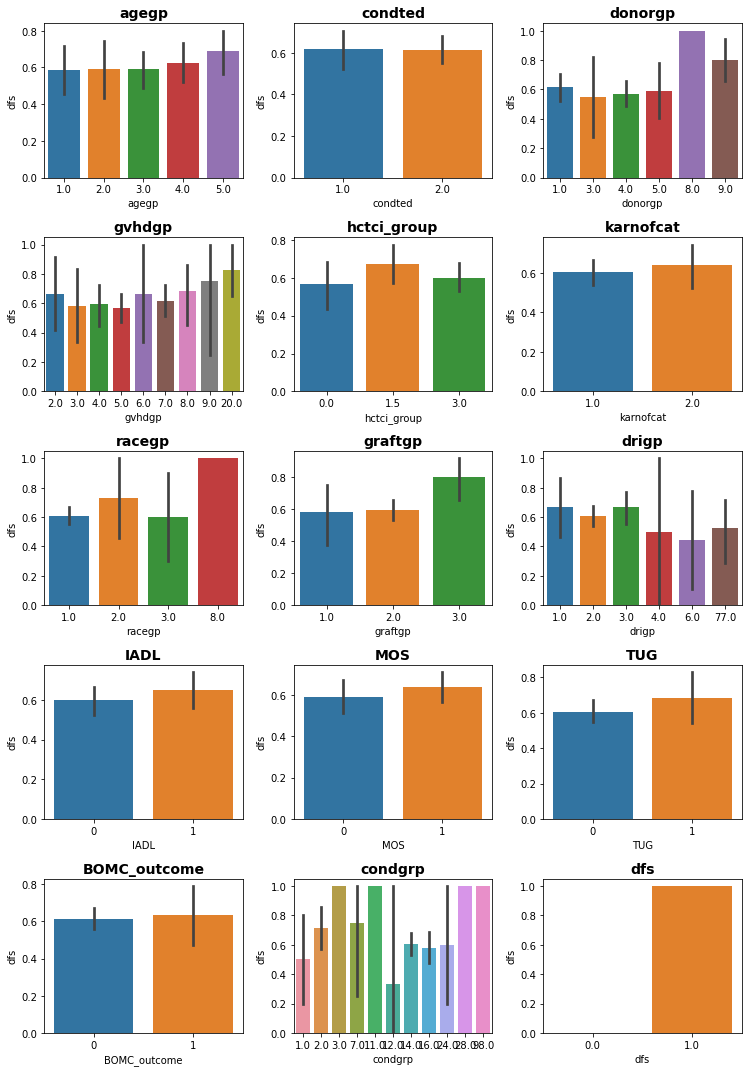

In [31]:
cols = ['agegp', 'condted', 'donorgp', 'gvhdgp', 'hctci_group', 'karnofcat', 'racegp', 'graftgp', 'drigp', 'IADL', 'MOS', 'TUG', 'BOMC_outcome', 'condgrp', 'dfs']

nr_rows = 5
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        
        i = r*nr_cols+c       
        ax = axs[r][c]
        sns.barplot(data=new_df, x=new_df[cols[i]], y=new_df["dfs"], ax=ax)
        ax.set_title(cols[i], fontsize=14, fontweight='bold')
        #ax.legend(title="relapse", loc='upper left') 
        
plt.tight_layout() 

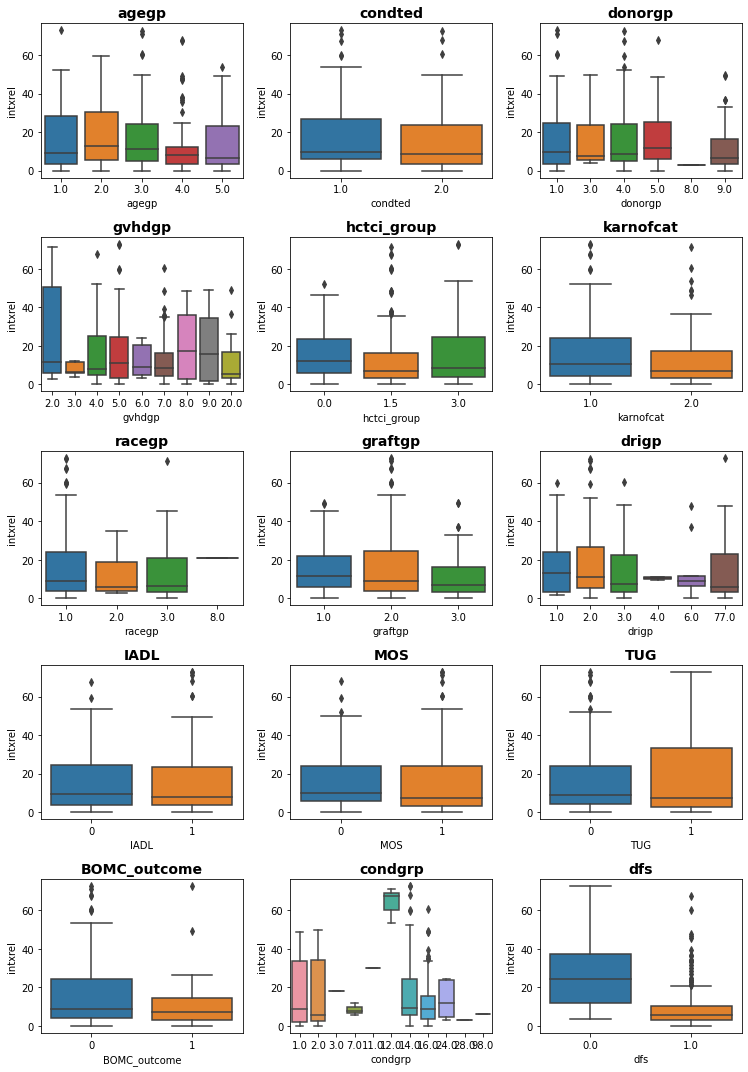

In [32]:
cols = ['agegp', 'condted', 'donorgp', 'gvhdgp', 'hctci_group', 'karnofcat', 'racegp', 'graftgp', 'drigp', 'IADL', 'MOS', 'TUG', 'BOMC_outcome', 'condgrp', 'dfs']

nr_rows = 5
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        
        i = r*nr_cols+c       
        ax = axs[r][c]
        sns.boxplot(x=new_df[cols[i]], y='intxrel', data=new_df, ax=ax)
        ax.set_title(cols[i], fontsize=14, fontweight='bold')
        #ax.legend(title="dead", loc='upper left') 
        
plt.tight_layout() 

### from these we can see that age, condted, karnofcat, graftgp, IADL, MOS, TUG and BOMC_outcome may be useful as predictors.

### I will do further exploration on all these features that displayed an association and look further into how they relate to predicting survival ('dead' column) specifically, which is our aim for this task.

## Survival Analysis and Feature selection
### Kaplan-Meier Survival Plots

### Kaplan-Meier analysis is a commonly used method within healthcare research to estimate survival over time. I will create plots for each of the features - agegp, hctci_group, condted, karnofcat, graftgp, IADL, MOS, TUG and BOMC_outcome. 

In [33]:
kmf = KaplanMeierFitter()

months = new_df["intxsurv"]
dead = new_df["dead"]

kmf.fit(months, event_observed=dead)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 302 total observations, 155 right-censored observations>

Text(0, 0.5, 'Probabilty of survival')

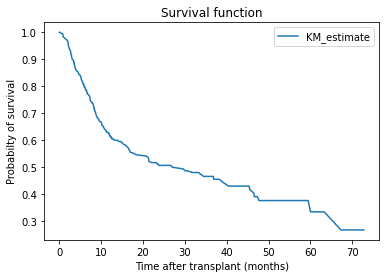

In [34]:
kmf.survival_function_.plot()
plt.title('Survival function')
plt.xlabel('Time after transplant (months)')
plt.ylabel('Probabilty of survival')

In [35]:
age1 = (new_df["agegp"] == 1)
age2 = (new_df["agegp"] == 2)
age3 = (new_df["agegp"] == 3)
age4 = (new_df["agegp"] == 4)
age5 = (new_df["agegp"] == 5)

Text(0, 0.5, 'Probabilty of survival')

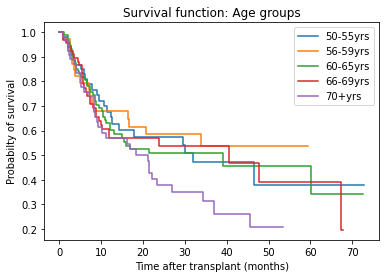

In [36]:
kmf.fit(months[age1], dead[age1], label="50-55yrs")
ax1 = kmf.plot(ci_show=False)

kmf.fit(months[age2], dead[age2], label="56-59yrs")
kmf.plot(ax=ax1, ci_show=False)

kmf.fit(months[age3], dead[age3], label="60-65yrs")
kmf.plot_survival_function(ax=ax1, ci_show=False)

kmf.fit(months[age4], dead[age4], label="66-69yrs")
kmf.plot_survival_function(ax=ax1, ci_show=False)

kmf.fit(months[age5], dead[age5], label="70+yrs")
kmf.plot_survival_function(ax=ax1, ci_show=False)

plt.title("Survival function: Age groups")
plt.xlabel('Time after transplant (months)')
plt.ylabel('Probabilty of survival')

In [37]:
no_ci = (new_df["hctci_group"] == 0)
mid_ci = (new_df["hctci_group"] == 1.5)
high_ci = (new_df["hctci_group"] == 3)

Text(0, 0.5, 'Probabilty of survival')

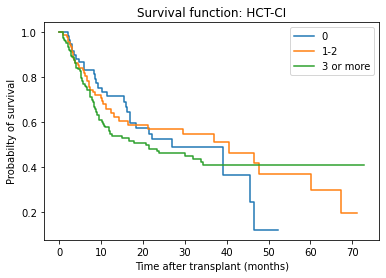

In [38]:
kmf.fit(months[no_ci], dead[no_ci], label="0")
ax1 = kmf.plot(ci_show=False)

kmf.fit(months[mid_ci], dead[mid_ci], label="1-2")
kmf.plot(ax=ax1, ci_show=False)

kmf.fit(months[high_ci], dead[high_ci], label="3 or more")
kmf.plot_survival_function(ax=ax1, ci_show=False)

plt.title("Survival function: HCT-CI")
plt.xlabel('Time after transplant (months)')
plt.ylabel('Probabilty of survival')

In [39]:
normalBOMC = (new_df["BOMC_outcome"] == 0)
impairedBOMC = (new_df["BOMC_outcome"] == 1)

Text(0, 0.5, 'Probabilty of survival')

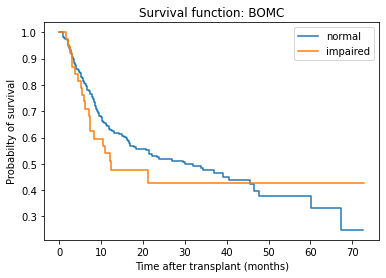

In [40]:
kmf.fit(months[normalBOMC], dead[normalBOMC], label="normal")
ax1 = kmf.plot(ci_show=False)

kmf.fit(months[impairedBOMC], dead[impairedBOMC], label="impaired")
kmf.plot(ax=ax1, ci_show=False)

plt.title("Survival function: BOMC")
plt.xlabel('Time after transplant (months)')
plt.ylabel('Probabilty of survival')

In [41]:
cond1 = (new_df["condted"] == 1)
cond2 = (new_df["condted"] == 2)

Text(0, 0.5, 'Probabilty of survival')

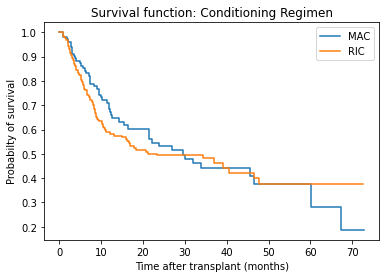

In [42]:
kmf.fit(months[cond1], dead[cond1], label="MAC")
ax1 = kmf.plot(ci_show=False)

kmf.fit(months[cond2], dead[cond2], label="RIC")
kmf.plot(ax=ax1, ci_show=False)

plt.title("Survival function: Conditioning Regimen")
plt.xlabel('Time after transplant (months)')
plt.ylabel('Probabilty of survival')

In [43]:
graft1 = (new_df["graftgp"] == 1)
graft2 = (new_df["graftgp"] == 2)
graft3 = (new_df["graftgp"] == 3)

Text(0, 0.5, 'Probabilty of survival')

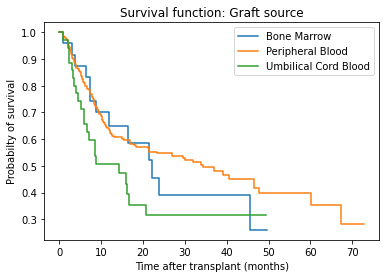

In [44]:
kmf.fit(months[graft1], dead[graft1], label="Bone Marrow")
ax1 = kmf.plot(ci_show=False)

kmf.fit(months[graft2], dead[graft2], label="Peripheral Blood")
kmf.plot(ax=ax1, ci_show=False)

kmf.fit(months[graft3], dead[graft3], label="Umbilical Cord Blood")
kmf.plot(ax=ax1, ci_show=False)

plt.title("Survival function: Graft source")
plt.xlabel('Time after transplant (months)')
plt.ylabel('Probabilty of survival')

In [45]:
k1 = (new_df["karnofcat"] == 1)
k2 = (new_df["karnofcat"] == 2)

Text(0, 0.5, 'Probabilty of survival')

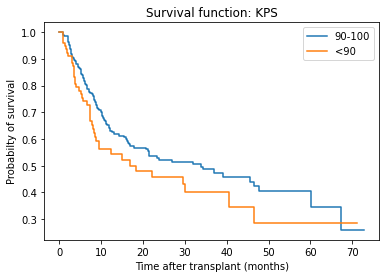

In [46]:
kmf.fit(months[k1], dead[k1], label="90-100")
ax1 = kmf.plot(ci_show=False)

kmf.fit(months[k2], dead[k2], label="<90")
kmf.plot(ax=ax1, ci_show=False)

plt.title("Survival function: KPS")
plt.xlabel('Time after transplant (months)')
plt.ylabel('Probabilty of survival')

In [47]:
iadl0 = (new_df["IADL"] == 0)
iadl1 = (new_df["IADL"] == 1)

Text(0, 0.5, 'Probabilty of survival')

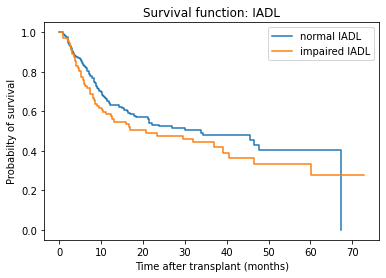

In [48]:
kmf.fit(months[iadl0], dead[iadl0], label="normal IADL")
ax1 = kmf.plot(ci_show=False)

kmf.fit(months[iadl1], dead[iadl1], label="impaired IADL")
kmf.plot(ax=ax1, ci_show=False)

plt.title("Survival function: IADL")
plt.xlabel('Time after transplant (months)')
plt.ylabel('Probabilty of survival')

In [49]:
mos0 = (new_df["MOS"] == 0)
mos1 = (new_df["MOS"] == 1)

Text(0, 0.5, 'Probabilty of survival')

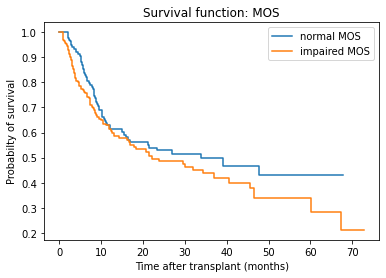

In [50]:
kmf.fit(months[mos0], dead[mos0], label="normal MOS")
ax1 = kmf.plot(ci_show=False)

kmf.fit(months[mos1], dead[mos1], label="impaired MOS")
kmf.plot(ax=ax1, ci_show=False)

plt.title("Survival function: MOS")
plt.xlabel('Time after transplant (months)')
plt.ylabel('Probabilty of survival')

In [51]:
tug0 = (new_df["TUG"] == 0)
tug1 = (new_df["TUG"] == 1)

Text(0, 0.5, 'Probabilty of survival')

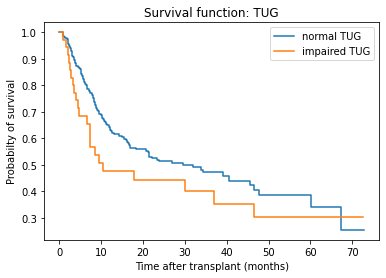

In [52]:
kmf.fit(months[tug0], dead[tug0], label="normal TUG")
ax1 = kmf.plot(ci_show=False)

kmf.fit(months[tug1], dead[tug1], label="impaired TUG")
kmf.plot(ax=ax1, ci_show=False)

plt.title("Survival function: TUG")
plt.xlabel('Time after transplant (months)')
plt.ylabel('Probabilty of survival')

### From these graphs we can see that the groups within each feature start of with fairly distinct survivals and patients who are considered more ill according to the feature have lower survival. However, as time progresses, this pattern becomes muddled as the groups overlap.
### For age groups, it seems like the survival is quite similar for the first few months and become more distinct as time progresses. However, although more elderly patients seem to have the lowest survival, the reverse does not seem to be true from the data that we have - the youngest age group doesn't have the best survival.
### To further analyse what these graphs are displaying, I can calculate and compare the Hazard Ratios for each feature. Hazards Ratios can measure the effect of a certain feature on an outcome (in this case Survival) over time. I will again use the Lifelines library, particularly their Cox’s proportional hazard model which outputs Hazard Ratios.

In [53]:
cols = new_df[['agegp', 'hctci_group','condted', 'karnofcat' , 'graftgp', 'hctcigp',  'age', 'dead','intxsurv']]
cols.describe()

,agegp,hctci_group,condted,karnofcat,graftgp,hctcigp,age,dead,intxsurv
count,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000
mean,3.105960,1.961921,1.662252,1.258278,2.036424,1.973510,63.447108,0.486755,18.717432
std,1.332708,1.173931,0.473727,0.438414,0.441228,1.200482,6.554643,0.500654,16.520368
min,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,50.436687,0.000000,0.822368
25%,2.000000,1.500000,1.000000,1.000000,2.000000,1.000000,58.231348,0.000000,6.126645
50%,3.000000,3.000000,2.000000,1.000000,2.000000,3.000000,63.634497,0.000000,12.138158
75%,4.000000,3.000000,2.000000,2.000000,2.000000,3.000000,68.709788,1.000000,28.947368
max,5.000000,3.000000,2.000000,2.000000,3.000000,3.000000,76.758385,1.000000,72.763158


In [54]:
cph = CoxPHFitter()
cph.fit(cols, "intxsurv", event_col="dead")
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 302 total observations, 155 right-censored observations>
             duration col = 'intxsurv'
                event col = 'dead'
      baseline estimation = breslow
   number of observations = 302
number of events observed = 147
   partial log-likelihood = -752.51
         time fit was run = 2021-04-21 17:47:39 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
agegp         0.29       1.34       0.29            -0.27             0.85                 0.77                 2.35
hctci_group   0.21       1.24       0.31            -0.40             0.82                 0.67                 2.28
condted      -0.10       0.90       0.19            -0.49             0.28                 0.62                 1.32
karnofcat     0.27       1.32       0.19            -0.09             0.64                 0.91                 1.90
graftgp       0.35       1.42       0.21            -0.06             0.76                 0.94                 2.14
hctcigp      -0.13       0.88       0.31            -0.73             0.47                 0.48                 1.59
age          -0.04       0.96       0.06            -0.15             0.08                 0.86                 1.08

                z    p   -log2(p)
covariate                        
agegp        1.03 0.30       1.72
hctci_group  0.68 0.50       1.01
condted     -0.54 0.59       0.76
karnofcat    1.47 0.14       2.81
graftgp      1.68 0.09       3.42
hctcigp     -0.44 0.66       0.59
age         -0.62 0.54       0.89
---
Concordance = 0.59
Partial AIC = 1519.03
log-likelihood ratio test = 8.76 on 7 df
-log2(p) of ll-ratio test = 1.89

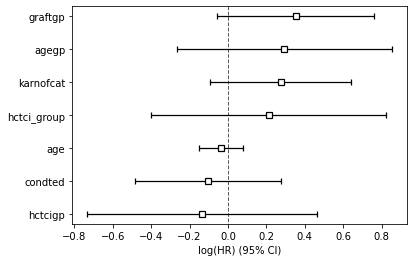

In [55]:
cph.plot()

In [56]:
new_df.head()

,sex,disease,age,intxsurv,dead,IADL_score14,MOS_physical_score,TUG_score,BOMC_score,racegp,condgrp,atgcampathgp,gvhdgp,karnofcat,graftgp,condted,donorgp,hctcigp,agegp,rel,intxrel,trm,dfs,drigp,hctci_group,BOMC_outcome,IADL,MOS,TUG
0,1.0,50.0,53.607118,6.546053,1.0,14.0,0.0,11.00,0.0,2.0,2.0,2.0,3.0,1.0,2.0,2.0,3.0,3.0,1.0,1.0,4.934211,0.0,1.0,3.0,3.0,0,0,1,0
1,2.0,50.0,71.225188,8.322368,1.0,13.0,18.0,7.15,4.0,1.0,16.0,3.0,7.0,1.0,2.0,2.0,4.0,3.0,5.0,1.0,0.032895,0.0,1.0,3.0,3.0,0,1,0,0
2,1.0,50.0,51.813826,13.125000,0.0,13.0,15.0,7.60,1.0,1.0,14.0,2.0,5.0,1.0,2.0,1.0,4.0,3.0,1.0,0.0,13.125000,0.0,0.0,2.0,3.0,0,1,0,0
3,2.0,50.0,63.682409,3.059211,1.0,14.0,0.0,0.00,0.0,1.0,16.0,2.0,2.0,1.0,3.0,2.0,9.0,1.0,3.0,0.0,3.059211,1.0,1.0,77.0,1.5,0,0,1,0
4,1.0,10.0,71.709788,6.019737,0.0,14.0,18.0,4.28,0.0,1.0,16.0,3.0,7.0,1.0,2.0,2.0,4.0,3.0,5.0,0.0,6.019737,0.0,0.0,2.0,3.0,0,0,0,0


In [57]:
cph1 = CoxPHFitter()
cols1 = new_df[['BOMC_outcome', 'IADL', 'MOS', 'TUG', 'dead', 'intxsurv']]                           
cph1.fit(cols1, "intxsurv", event_col="dead")
cph1.print_summary()

<lifelines.CoxPHFitter: fitted with 302 total observations, 155 right-censored observations>
             duration col = 'intxsurv'
                event col = 'dead'
      baseline estimation = breslow
   number of observations = 302
number of events observed = 147
   partial log-likelihood = -754.83
         time fit was run = 2021-04-21 17:47:39 UTC

---
               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                            
BOMC_outcome   0.23       1.26       0.24            -0.25             0.70                 0.78                 2.02
IADL           0.13       1.14       0.18            -0.21             0.48                 0.81                 1.62
MOS            0.12       1.13       0.18            -0.24             0.48                 0.79                 1.62
TUG            0.23       1.26       0.25            -0.25             0.72                 0.78                 2.05

                z    p   -log2(p)
covariate                        
BOMC_outcome 0.94 0.35       1.52
IADL         0.76 0.45       1.16
MOS          0.66 0.51       0.97
TUG          0.94 0.34       1.54
---
Concordance = 0.56
Partial AIC = 1517.67
log-likelihood ratio test = 4.12 on 4 df
-log2(p) of ll-ratio test = 1.36

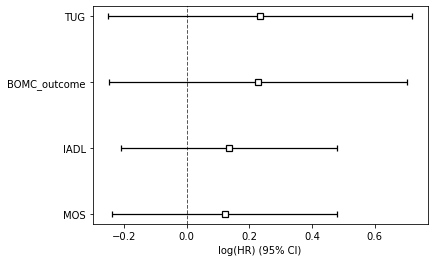

In [58]:
cph1.plot()

### The exp(coef) column in the above table displays the hazard ratios for features. We can see from the BOMC_outcome table that cognitive impairment, IADL, MOS, and TUG are associated with a 26%, 14%, 13% and 26% higher risk of mortality, respectively. 
### We can also see from the hazard ratios that agegp, hctci_group, karnofcat and graftgp have 34%, 24%, 32% and 42% higher risks of death, respectively. These features are commonly used in real clinics to inform doctors on potential survival outcomes of patients. Therefore, it may be worth combining these features for our machine learning task to assess the accuracy of this currently used system and use it as our baseline predictor.
### None of these results are statisically significant as all the p-values are >0.05 and the CIs are fairly wide. However, the upper 95% CIs for agegp, hctci_group, graftgp and BOMC_outcome are above 2.00 and for karnofcat it is just below at 1.90. The higher the upper CI value, the more likely the feature is to have a hazard ratio above 1 indicating an increased risk association for survival.
### As hctcigp (the original column), Age (as a continuous variable) and condted all have hazard ratios just below 1, this shows that neither of these columns have a relation to the survival of a patient.
### I will now plot a survival graph using real patient observation data to help with the interpretation of these results and help form a theory. 

In [59]:
#patient_data = cols.iloc[187]
patient_data = cols.iloc[186:190]
#patient_data
new_df[186:190]

,sex,disease,age,intxsurv,dead,IADL_score14,MOS_physical_score,TUG_score,BOMC_score,racegp,condgrp,atgcampathgp,gvhdgp,karnofcat,graftgp,condted,donorgp,hctcigp,agegp,rel,intxrel,trm,dfs,drigp,hctci_group,BOMC_outcome,IADL,MOS,TUG
186,2.0,10.0,62.505133,24.572368,0.0,13.0,13.0,10.08,8.0,1.0,16.0,3.0,7.0,1.0,2.0,2.0,1.0,3.0,3.0,0.0,24.572368,0.0,0.0,2.0,3.0,1,1,1,0
187,1.0,50.0,60.336756,25.197368,0.0,14.0,0.0,9.17,14.0,2.0,16.0,3.0,7.0,2.0,2.0,2.0,1.0,3.0,3.0,0.0,25.197368,0.0,0.0,3.0,3.0,1,0,1,0
188,2.0,50.0,76.673511,5.197368,1.0,12.0,0.0,0.00,0.0,1.0,16.0,4.0,5.0,2.0,2.0,2.0,4.0,3.0,5.0,1.0,3.256579,0.0,1.0,3.0,3.0,0,1,1,0
189,2.0,50.0,65.694730,24.111842,0.0,14.0,19.0,0.00,0.0,1.0,24.0,4.0,6.0,1.0,2.0,2.0,4.0,3.0,3.0,0.0,24.111842,0.0,0.0,3.0,3.0,0,0,0,0


Text(0, 0.5, 'Probabilty of survival')

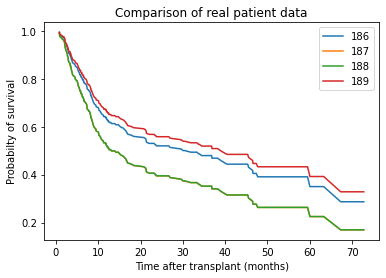

In [60]:
cph.predict_survival_function(patient_data).plot()
plt.title('Comparison of real patient data')
plt.xlabel('Time after transplant (months)')
plt.ylabel('Probabilty of survival')

Text(0, 0.5, 'Probabilty of survival')

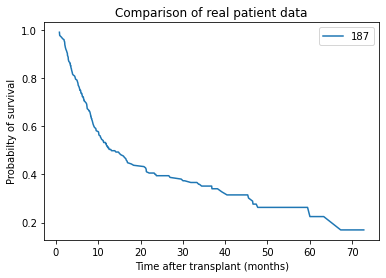

In [61]:
patient_datatest = cols.iloc[187]
cph.predict_survival_function(patient_datatest).plot()
plt.title('Comparison of real patient data')
plt.xlabel('Time after transplant (months)')
plt.ylabel('Probabilty of survival')

#### The only difference between patient 186 and patient 187 is that patient 186 has a better karnofcat score and we can see from the graph that this difference alone gives patient 187 a worse chance of survival. (karnofcat hazard ratio 32%).
#### 186 and 189 have similar feature scores except that 186 has cognitive impairment, MOS impairment, therefore on the graph we see that 186 has poorer survival compared to 189.

#### I want to further see the sole effect of certain features on survival so I will pick a new set of patients who only differ in regards to these features and create some more small plots. 

In [62]:
patient_data1 = cols.iloc[134:136]
patient_data1

,agegp,hctci_group,condted,karnofcat,graftgp,hctcigp,age,dead,intxsurv
134,5.0,1.5,2.0,1.0,2.0,2.0,70.318960,0.0,36.513158
135,4.0,1.5,2.0,1.0,2.0,2.0,69.957563,0.0,37.993421


Text(0, 0.5, 'Probabilty of survival')

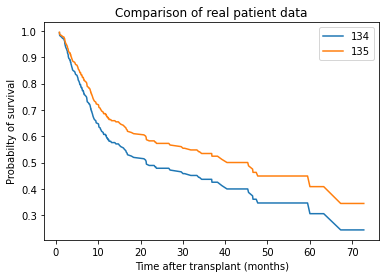

In [63]:
cph.predict_survival_function(patient_data1).plot()
plt.title('Comparison of real patient data')
plt.xlabel('Time after transplant (months)')
plt.ylabel('Probabilty of survival')

### Patient 135 is from a younger age group than patient 134 and we can see from this plot that the older patient (134) does have a higher risk of death (as indicated from the hazard ratio) and poor chance of survival in comparison to the younger patient.

In [64]:
patient_data2 = cols.iloc[140:142]             
patient_data2

,agegp,hctci_group,condted,karnofcat,graftgp,hctcigp,age,dead,intxsurv
140,3.0,3.0,2.0,1.0,2.0,3.0,61.538672,0.0,23.980263
141,3.0,0.0,2.0,1.0,2.0,0.0,64.342231,1.0,2.105263


Text(0, 0.5, 'Probabilty of survival')

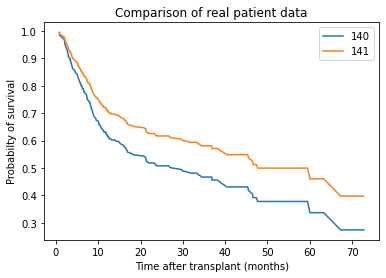

In [65]:
cph.predict_survival_function(patient_data2).plot()
plt.title('Comparison of real patient data')
plt.xlabel('Time after transplant (months)')
plt.ylabel('Probabilty of survival')

#### Patient 140 has a higher hctci score and therefore has worse survival. This is displayed by the wide gap between the scores as indicated above where patient 141 has a score of 0 and therefore a more distinct increased chance of survival compared to patient 140 who has a score of 3 which indicates poorer health.

In [66]:
patient_data3 = cols.iloc[62:64]
patient_data3

,agegp,hctci_group,condted,karnofcat,graftgp,hctcigp,age,dead,intxsurv
62,3.0,3.0,2.0,2.0,2.0,3.0,60.703628,1.0,3.421053
63,3.0,3.0,2.0,1.0,2.0,3.0,63.216975,1.0,10.493421


Text(0, 0.5, 'Probabilty of survival')

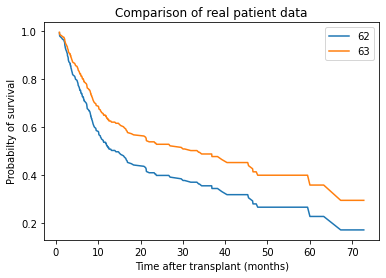

In [67]:
cph.predict_survival_function(patient_data3).plot()
plt.title('Comparison of real patient data')
plt.xlabel('Time after transplant (months)')
plt.ylabel('Probabilty of survival')

#### From this, we can see that patients with a poorer karnofcat score have poorer survivals.

In [68]:
patient_data_A = cols.iloc[64:66]
patient_data_A

,agegp,hctci_group,condted,karnofcat,graftgp,hctcigp,age,dead,intxsurv
64,1.0,0.0,1.0,1.0,2.0,0.0,50.702259,1.0,11.282895
65,1.0,0.0,1.0,1.0,1.0,0.0,51.786448,1.0,3.059211


Text(0, 0.5, 'Probabilty of survival')

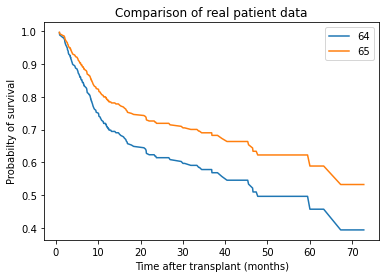

In [69]:
cph.predict_survival_function(patient_data_A).plot()
plt.title('Comparison of real patient data')
plt.xlabel('Time after transplant (months)')
plt.ylabel('Probabilty of survival')

In [70]:
patient_data_B = cols.iloc[115:117]
patient_data_B

,agegp,hctci_group,condted,karnofcat,graftgp,hctcigp,age,dead,intxsurv
115,4.0,1.5,2.0,1.0,3.0,1.0,66.370979,1.0,3.322368
116,4.0,1.5,2.0,1.0,2.0,2.0,69.051335,0.0,36.151316


Text(0, 0.5, 'Probabilty of survival')

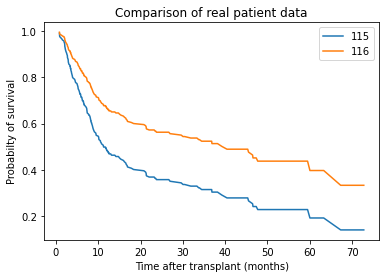

In [71]:
cph.predict_survival_function(patient_data_B).plot()
plt.title('Comparison of real patient data')
plt.xlabel('Time after transplant (months)')
plt.ylabel('Probabilty of survival')

In [72]:
patient_data_C = cols.iloc[108:111]
patient_data_C

,agegp,hctci_group,condted,karnofcat,graftgp,hctcigp,age,dead,intxsurv
108,3.0,3.0,2.0,1.0,1.0,3.0,60.914442,0.0,35.230263
109,1.0,1.5,1.0,1.0,2.0,1.0,54.247775,0.0,36.118421
110,3.0,3.0,2.0,1.0,3.0,3.0,65.831622,1.0,8.585526


Text(0, 0.5, 'Probabilty of survival')

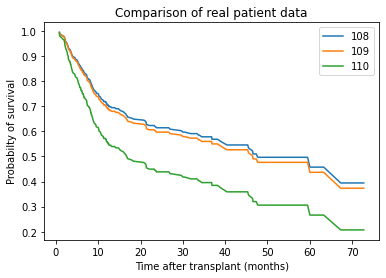

In [73]:
cph.predict_survival_function(patient_data_C).plot()
plt.title('Comparison of real patient data')
plt.xlabel('Time after transplant (months)')
plt.ylabel('Probabilty of survival')

#### We can see from these graphs that patients with a graftgp of 3 (which indicates an umbilical cord blood graft) have poorer survival compared to patients who have a graftgp score of 2 (which indicates a peripheral blood graft). Graftgp score of 1 (bone marrow graft) has the best survival.

In [74]:
patient_data4 = cols1.iloc[229:231]
patient_data4

,BOMC_outcome,IADL,MOS,TUG,dead,intxsurv
229,1,0,0,0,1.0,2.105263
230,0,0,0,0,1.0,6.250000


Text(0, 0.5, 'Probabilty of survival')

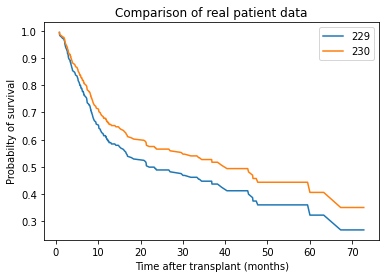

In [75]:
cph1.predict_survival_function(patient_data4).plot()
plt.title('Comparison of real patient data')
plt.xlabel('Time after transplant (months)')
plt.ylabel('Probabilty of survival')

#### patient 229 who has congnitive impairment has poorer survival.

In [76]:
patient_data5 = cols1.iloc[258:260]               # just MOS = cols1.iloc[297:299]
patient_data5
#new_df[240:260]

,BOMC_outcome,IADL,MOS,TUG,dead,intxsurv
258,0,0,1,0,0.0,5.953947
259,0,1,0,0,1.0,10.164474


Text(0, 0.5, 'Probabilty of survival')

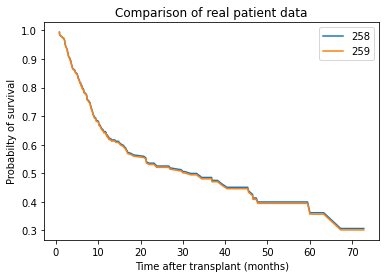

In [77]:
cph1.predict_survival_function(patient_data5).plot()
plt.title('Comparison of real patient data')
plt.xlabel('Time after transplant (months)')
plt.ylabel('Probabilty of survival')

#### These two patients differ only in the fact that one has IADL impairment and one has MOS impairment. From the graph we can see that the two patients survivals are very similar and this makes sense as the hazard ratio results (14% and 13%) were very similar.

### It may be worth combining all of these features in our two models to compare as they all seem to have some relation to prediction of survival as indicated by the survival graphs and hazard scores. Using the features in combination may improve the overall signficance of their results.

# Generating dataset for the features we will analyse

In [78]:
final_df = new_df[['karnofcat', 'agegp', 'hctci_group', 'graftgp', 'BOMC_outcome', 'IADL', 'MOS', 'TUG', 'dead']]

### Checking correlation among the features and dropping the features which have the correlation of > 0.9

In [79]:
cor = final_df.corr()
cols = np.full((cor.shape[0],), True, dtype=bool)
for i in range(cor.shape[0]):
    for j in range(i+1, cor.shape[0]):
        if cor.iloc[i,j] >= 0.5:
            if cols[j]:
                cols[j] = False
sel_cols = final_df.columns[cols]
final_df = final_df[sel_cols]
print("The selected Columns are: \n",sel_cols)

The selected Columns are: 
 Index(['karnofcat', 'agegp', 'hctci_group', 'graftgp', 'BOMC_outcome', 'IADL',
       'MOS', 'TUG', 'dead'],
      dtype='object')


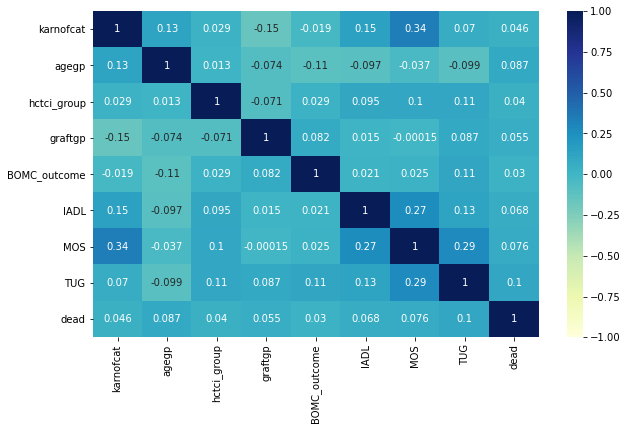

In [80]:
plt.figure(figsize=(10,6))
sns.heatmap(final_df.corr(),annot=True,vmin = -1, vmax =1,cmap = 'YlGnBu',center= 0,)

In [81]:
final_df

,karnofcat,agegp,hctci_group,graftgp,BOMC_outcome,IADL,MOS,TUG,dead
0,1.0,1.0,3.0,2.0,0,0,1,0,1.0
1,1.0,5.0,3.0,2.0,0,1,0,0,1.0
2,1.0,1.0,3.0,2.0,0,1,0,0,0.0
3,1.0,3.0,1.5,3.0,0,0,1,0,1.0
4,1.0,5.0,3.0,2.0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...
297,1.0,5.0,1.5,2.0,0,0,1,0,1.0
298,1.0,5.0,1.5,2.0,0,0,0,0,0.0
299,1.0,3.0,3.0,2.0,0,1,0,0,0.0
300,2.0,4.0,1.5,2.0,0,0,1,0,0.0


# Feature Scaling
As the features are not normally distributed we are doing standardization to bring the values in the same range.

In [82]:
X = final_df.drop(columns = ['dead'])
y = final_df['dead']
X

,karnofcat,agegp,hctci_group,graftgp,BOMC_outcome,IADL,MOS,TUG
0,1.0,1.0,3.0,2.0,0,0,1,0
1,1.0,5.0,3.0,2.0,0,1,0,0
2,1.0,1.0,3.0,2.0,0,1,0,0
3,1.0,3.0,1.5,3.0,0,0,1,0
4,1.0,5.0,3.0,2.0,0,0,0,0
...,...,...,...,...,...,...,...,...
297,1.0,5.0,1.5,2.0,0,0,1,0
298,1.0,5.0,1.5,2.0,0,0,0,0
299,1.0,3.0,3.0,2.0,0,1,0,0
300,2.0,4.0,1.5,2.0,0,0,1,0


In [83]:
sc = StandardScaler()
X_scaled = sc.fit_transform(X)

In [84]:
X_scaled

array([[-0.59009684, -1.58283411,  0.88574431, ..., -0.76233315,
         0.91120965, -0.3620582 ],
       [-0.59009684,  1.42355521,  0.88574431, ...,  1.31176245,
        -1.09744228, -0.3620582 ],
       [-0.59009684, -1.58283411,  0.88574431, ...,  1.31176245,
        -1.09744228, -0.3620582 ],
       ...,
       [-0.59009684, -0.07963945,  0.88574431, ...,  1.31176245,
        -1.09744228, -0.3620582 ],
       [ 1.69463709,  0.67195788, -0.39413503, ..., -0.76233315,
         0.91120965, -0.3620582 ],
       [ 1.69463709,  0.67195788,  0.88574431, ..., -0.76233315,
         0.91120965, -0.3620582 ]])

In [85]:
final_df.head()

,karnofcat,agegp,hctci_group,graftgp,BOMC_outcome,IADL,MOS,TUG,dead
0,1.0,1.0,3.0,2.0,0,0,1,0,1.0
1,1.0,5.0,3.0,2.0,0,1,0,0,1.0
2,1.0,1.0,3.0,2.0,0,1,0,0,0.0
3,1.0,3.0,1.5,3.0,0,0,1,0,1.0
4,1.0,5.0,3.0,2.0,0,0,0,0,0.0


# Visualising the distribution of data to choose ML models

## Checking if the data is balanced 

In [86]:
final_df['dead'].value_counts()

0.0    155
1.0    147
Name: dead, dtype: int64

The data in the target variable is almost equally distributed(0 - 155 and 1 - 147),hence the data is balanced.

## Shapiro-Wilk Normality Test  

The Shapiro-Wilk test is based on the correlation between the data and the corresponding normal scores and provides better power than the K-S test even after the Lilliefors correction. Power is the most frequent measure of the value of a test for normality—the ability to detect whether a sample comes from a non-normal distribution. Some researchers recommend the Shapiro-Wilk test as the best choice for testing the normality of data(Thode HJ. Testing for normality. New York: Marcel Dekker; 2002. [Google Scholar])

In [87]:
# Shapiro-Wilk Test
from scipy.stats import shapiro
stat, p = shapiro(final_df)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('The dataset follows Gaussian (fail to reject H0)')
else:
    print('The dataset does not follow Gaussian (reject H0)')

Statistics=0.824, p=0.000
The dataset does not follow Gaussian (reject H0)


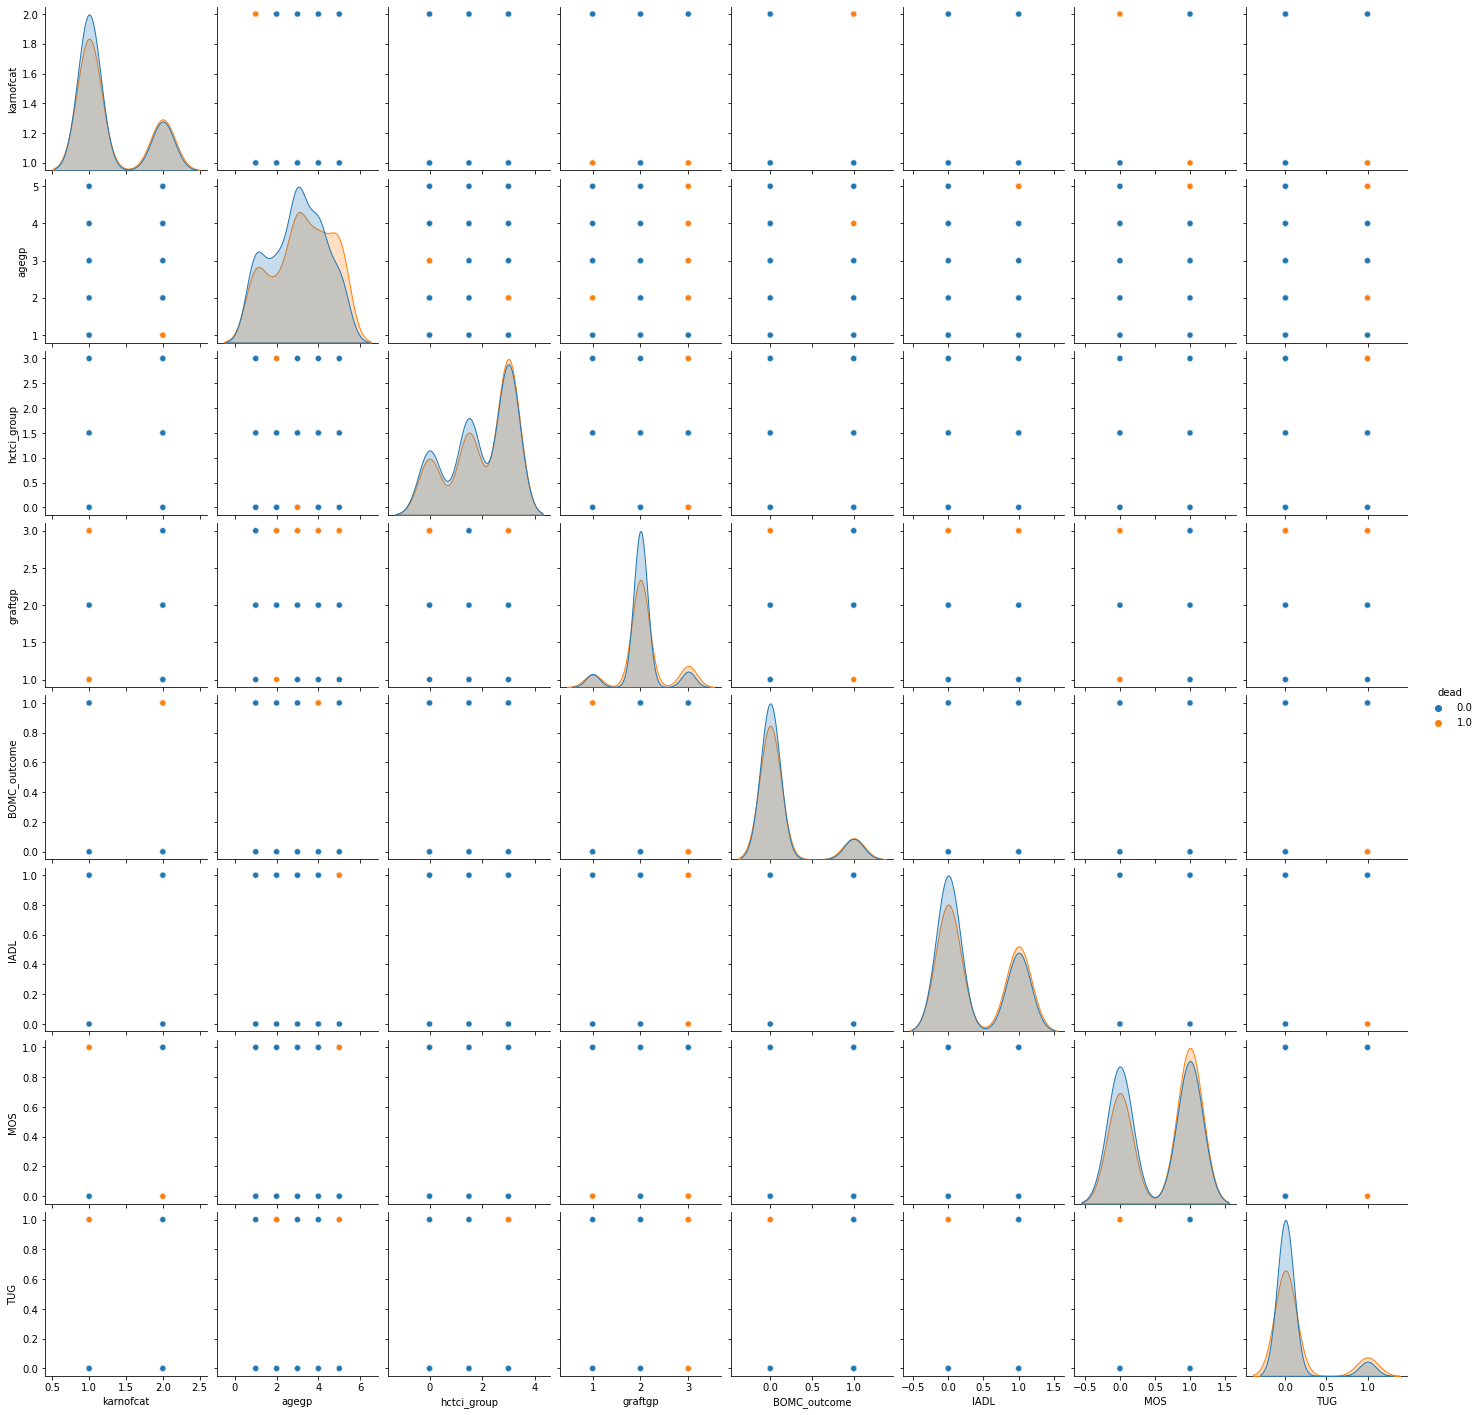

In [88]:
sns.pairplot(final_df,hue = 'dead',diag_kind='kde')

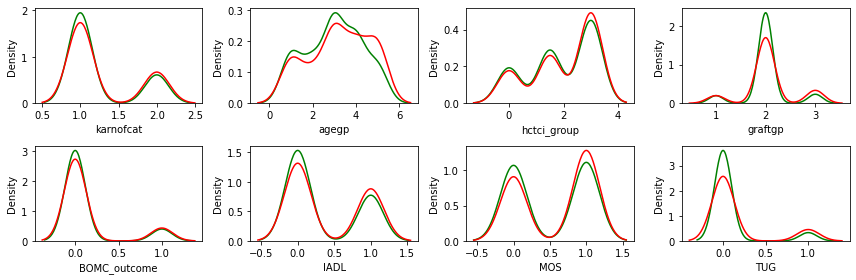

In [89]:
fig = plt.figure(figsize = (12, 4))
k = 0
f_df = final_df.columns[:8]
#corr = f_df.corr()
for i in f_df:
    plt.subplot(2, 4, k+1)
    k = k + 1
    sns.kdeplot(final_df[i][final_df['dead']==0],color = 'g',label = 'Alive')
    sns.kdeplot(final_df[i][final_df['dead']==1],color = 'r' ,label = 'Dead')
#plt.legend(loc='best')
fig.tight_layout()
plt.show()

## The statistical test and the plot show non-linear distribution. Hence we will build the ML models which support non-linear distribution

### We will Split the dataset into 2 subsets. One subset is for clinical features and one is for geriatic features.

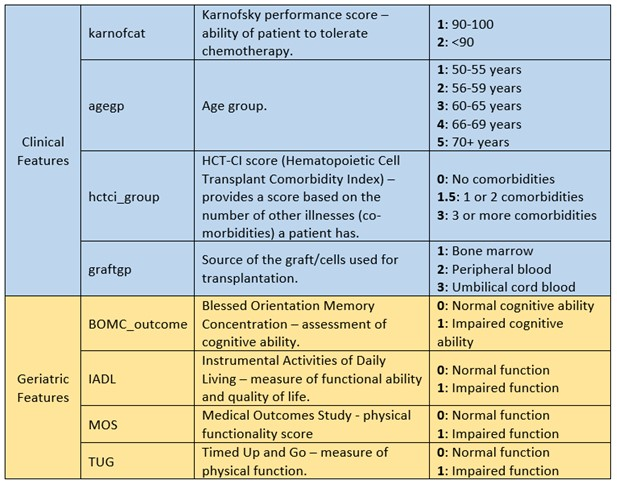

### Clinical Features Dataset

In [90]:
X1 = X_scaled[:, [0,1,2,3]]
y1 = y.values

In [91]:
kf = KFold(n_splits=10)
kf.get_n_splits(X1)

10

In [92]:
KFold(n_splits=10, random_state=None, shuffle=False)
for train_index, test_index in kf.split(X1, y1):
    X_train, X_test = X1[train_index], X1[test_index]
    y_train, y_test = y1[train_index], y1[test_index]

In [93]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((272, 4), (30, 4), (272,), (30,))

In [94]:
X_train

array([[-0.59009684, -1.58283411,  0.88574431, -0.08268807],
       [-0.59009684,  1.42355521,  0.88574431, -0.08268807],
       [-0.59009684, -1.58283411,  0.88574431, -0.08268807],
       ...,
       [-0.59009684,  0.67195788, -0.39413503, -0.08268807],
       [-0.59009684, -0.07963945,  0.88574431, -0.08268807],
       [-0.59009684, -0.07963945, -1.67401437, -0.08268807]])

In [95]:
X_test

array([[-0.59009684, -0.07963945, -1.67401437,  2.18747533],
       [-0.59009684,  0.67195788, -0.39413503, -0.08268807],
       [-0.59009684, -1.58283411, -1.67401437, -0.08268807],
       [ 1.69463709,  0.67195788,  0.88574431, -0.08268807],
       [-0.59009684,  1.42355521,  0.88574431, -0.08268807],
       [ 1.69463709, -0.07963945,  0.88574431, -0.08268807],
       [-0.59009684, -0.83123678, -1.67401437, -0.08268807],
       [ 1.69463709,  0.67195788, -0.39413503, -2.35285147],
       [ 1.69463709,  0.67195788,  0.88574431, -0.08268807],
       [ 1.69463709,  1.42355521,  0.88574431, -0.08268807],
       [-0.59009684, -1.58283411,  0.88574431, -0.08268807],
       [-0.59009684, -1.58283411, -1.67401437, -0.08268807],
       [-0.59009684, -1.58283411, -0.39413503, -0.08268807],
       [-0.59009684, -0.83123678,  0.88574431,  2.18747533],
       [-0.59009684,  0.67195788, -0.39413503, -0.08268807],
       [-0.59009684, -0.83123678, -1.67401437, -0.08268807],
       [-0.59009684, -0.

In [96]:
y_train

array([1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0.,
       0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
       0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0.,
       0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1.,
       0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0.,
       1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0.,
       1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0.,
       0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0.,
       0., 1., 0., 1., 0.

In [97]:
y_test

array([1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

### Geriatric assesment features dataset

In [98]:
X_ger = X_scaled[:, [4,5,6,7]]
Y_ger = y.values

In [99]:
kf_ger = KFold(n_splits=10)
kf_ger.get_n_splits(X_ger, Y_ger)
KFold(n_splits=10, random_state=None, shuffle=True)
for train_index, test_index in kf_ger.split(X_ger, Y_ger):
    X_train_ger, X_test_ger = X_ger[train_index], X_ger[test_index]
    y_train_ger, y_test_ger = Y_ger[train_index], Y_ger[test_index]

# ML and Neural network model building - Clinical Features ('karnofcat', 'agegp', 'hctci_group' and 'graftgp')

### In binary classification evaluation,the Matthews correlation coefficient (MCC) is considered as best metric.¶

https://bmcgenomics.biomedcentral.com/articles/10.1186/s12864-019-6413-7


## Model Building - # 1: KNN Classifier 

### Model 1a - Analysis with clinical features

#### KNearestNeighbor Classifier - Finding optimal K-value using Elbow method

We will need to choose the optimal K value for the model to perform better.We are using Elbow method to find the correct K value.Here we are plotting the error plot to choose the optimal value of K.The process of choosing the right value of K is called parameter tuning and it is better for the accuracy.

In [100]:
err = []
# Calculating error for K values between 1 and 30
for i in range(1, 31):
    knn = KNeighborsClassifier(n_neighbors=i)
    scores = cross_val_score(knn,X1,y1,cv = 10,scoring = 'accuracy')
    err.append(scores.mean())

Text(0, 0.5, 'Mean_Error')

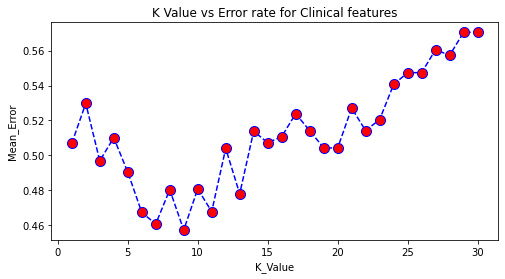

In [101]:
plt.figure(figsize=(8, 4))
plt.plot(range(1, 31), err, color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('K Value vs Error rate for Clinical features')
plt.xlabel('K_Value')
plt.ylabel('Mean_Error')

#### The plot shows the error is minimal and start to increase when the K value is 9.Hence we are predicting the accuracy with K=9


KNN Mean Model Accuracy : 0.43 

F1 Score : 0.43

Matthews score : -0.11


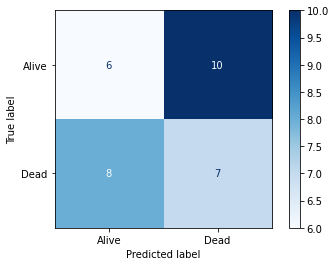

In [102]:
knn = KNeighborsClassifier(n_neighbors=9)
knn_acc = []
knn_conf = []
knn_f1 = []
knn_rocauc = []
knn_m_score = []
kf = KFold(n_splits=10, random_state=None, shuffle=False)
for train_index, test_index in kf.split(X1, y1):
    X_train, X_test = X1[train_index], X1[test_index]
    y_train, y_test = y1[train_index], y1[test_index]
    
    knn.fit(X_train, y_train)
    knn_y_pred = knn.predict(X_test)
    
    knnscores = accuracy_score(y_test,knn_y_pred)
    knn_acc.append(knnscores)
    knn_mean_acc = statistics.mean(knn_acc)
    
    knn_cm=confusion_matrix(y_test, knn_y_pred)
    knn_conf.append(knn_cm)
    
    knn_f1_s = f1_score(y_test,knn_y_pred,average='weighted')
    knn_f1.append(knn_f1_s)
    
    knn_y_pred_prob = knn.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, knn_y_pred_prob) # fpr - False positive rate & TPR - True Positive rate
    auc = roc_auc_score(y_test, knn_y_pred_prob)
    #print("KNN : ROC - AUC Score: {:.2f}".format(auc))
    
    knn_rocauc_s = roc_auc_score(y_test,knn_y_pred)
    knn_rocauc.append(knn_rocauc_s)
    
    knn_m_score1 =matthews_corrcoef(y_test, knn_y_pred)
    knn_m_score.append(knn_m_score1)
    
knn_mean_mathew = np.mean(knn_m_score)
mean_of_conf = np.mean(knn_conf,axis=0).round()
#print("Model accuracies : ",knn_acc)
print("\nKNN Mean Model Accuracy : {:.2f} ".format(knn_mean_acc))
#We can't completely rely on model accuracy for classification, hence we will calculate the confusion matrix
target_names = ['Alive','Dead']
knn_cv_y_pred = cross_val_predict(knn, X1, y1, cv=10)
#print(classification_report(y1,knn_cv_y_pred,target_names = target_names))
print("\nF1 Score : {:.2f}".format(np.mean(knn_f1)))
#print("\nROC AUC Score : {:.2f} ".format(np.mean(knn_rocauc)))
#mean_auc = np.mean(aucs)
#print("AUC Score : {:.2f}".format(mean_auc))
print("\nMatthews score : {:.2f}".format(knn_mean_mathew))

knn_cmd = ConfusionMatrixDisplay(mean_of_conf, display_labels=['Alive','Dead'])
knn_cmd.plot(cmap='Blues')

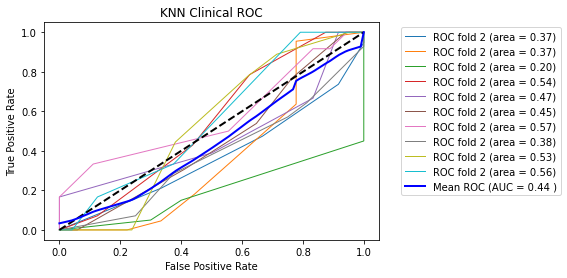

KNN Clinical ROC AUC score : 0.44


In [103]:
tprs = []
aucs = []
cv = KFold(n_splits=10,shuffle=False)
mean_fpr = np.linspace(0,1,100)
i = 1
for train,test in cv.split(X1,y1):
    prediction = knn.fit(X1[train],y1[train]).predict_proba(X1[test])
    fpr, tpr, t = roc_curve(y1[test], prediction[:, 1])
    knnplt = plot_roc_curve(knn, X1[test], y1[test],
                          alpha=0.3, lw=1, ax=ax)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = metrics.auc(fpr,tpr)
    aucs.append(knnplt.roc_auc)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i+1, roc_auc))
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='chance')

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
knn_mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (knn_mean_auc, std_auc),lw=2, alpha=.8)
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
knn_mean_auc = metrics.auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.2f )' % (knn_mean_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN Clinical ROC')
plt.legend(loc="best",bbox_to_anchor=(1.05, 1))
plt.show()

print("KNN Clinical ROC AUC score : {:.2f}".format(knn_mean_auc))

#### ROC-AUC curve

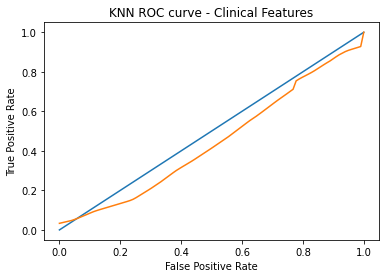

In [104]:
knn.fit(X_train,y_train)
plt.plot([0,1],[0,1])
plt.plot(mean_fpr,mean_tpr, label='Knn')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN ROC curve - Clinical Features')
plt.show()

### Optimizing parameters with GridSearchCV

In [105]:
#Optimizing parameters with GridSearchCV
k_nos = list(range(1, 31))
weight_opt = ["uniform", "distance"]
alg = ['auto','kd_tree', 'brute']
knn_param_grid = dict(n_neighbors=k_nos,weights = weight_opt,algorithm=alg)
knn_grid= GridSearchCV(knn,param_grid=knn_param_grid,cv=10,scoring='accuracy')
knn_grid.fit(X1,y1)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(n_neighbors=9),
             param_grid={'algorithm': ['auto', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [106]:
print(knn_grid.best_score_)
print(knn_grid.best_params_)
print(knn_grid.best_estimator_)

0.5705376344086022
{'algorithm': 'auto', 'n_neighbors': 29, 'weights': 'uniform'}
KNeighborsClassifier(n_neighbors=29)


### Model 1b - KNN Geriatric assessment features

#### Choosing K value

In [107]:
err_ger = []
# Calculating error for K values between 1 and 30
for i in range(1, 31):
    knn_ger = KNeighborsClassifier(n_neighbors=i)
    scores_ger = cross_val_score(knn_ger,X_ger,Y_ger,cv = 10,scoring = 'accuracy')
    err_ger.append(scores_ger.mean())

Text(0, 0.5, 'Mean_Error')

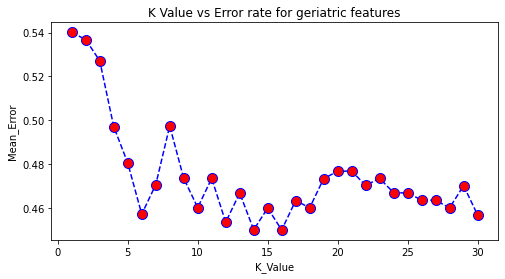

In [108]:
plt.figure(figsize=(8, 4))
plt.plot(range(1, 31), err_ger, color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('K Value vs Error rate for geriatric features')
plt.xlabel('K_Value')
plt.ylabel('Mean_Error')

#### The error is minimal when K = 14 .Hence we are choosing K as 14

Model accuracies :  [0.41935483870967744, 0.2903225806451613, 0.3, 0.5666666666666667, 0.43333333333333335, 0.43333333333333335, 0.4666666666666667, 0.4, 0.5, 0.4666666666666667]

KNN Mean Model Accuracy : 0.45 

F1 Score : 0.40

Matthews score : -0.13


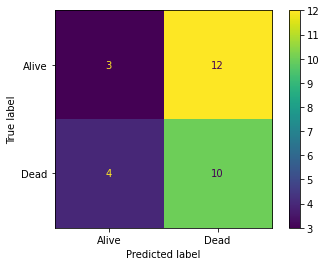

In [109]:
knn_ger = KNeighborsClassifier(n_neighbors=14)
knn_ger_acc = []
knn_ger_conf = []
knn_ger_f1 = []
knn_ger_rocauc = []
knn_ger_m_score = []
kf = KFold(n_splits=10, random_state=None, shuffle=False)
for train_index, test_index in kf.split(X_ger, Y_ger):
    X_train, X_test = X_ger[train_index], X_ger[test_index]
    y_train, y_test = Y_ger[train_index], Y_ger[test_index]
    
    knn_ger.fit(X_train, y_train)
    knn_ger_y_pred = knn_ger.predict(X_test)
    
    knngerscores = accuracy_score(y_test,knn_ger_y_pred)
    knn_ger_acc.append(knngerscores)
    knn_ger_mean_acc = statistics.mean(knn_ger_acc)
    
    knn_ger_cm=confusion_matrix(y_test, knn_ger_y_pred)
    knn_ger_conf.append(knn_ger_cm)
    
    knn_ger_f1_s = f1_score(y_test,knn_ger_y_pred,average='weighted')
    knn_ger_f1.append(knn_ger_f1_s)
    
    knn_ger_y_pred_prob = knn_ger.predict_proba(X_test)[:,1]
    fpr_ger, tpr_ger, thresholds = roc_curve(y_test, knn_ger_y_pred_prob) # fpr - False positive rate & TPR - True Positive rate
    auc_ger = roc_auc_score(y_test, knn_ger_y_pred_prob)
    #print("KNN : ROC - AUC Score: {:.2f}".format(auc))
    
    knn_ger_rocauc_s = roc_auc_score(y_test,knn_ger_y_pred)
    knn_ger_rocauc.append(knn_ger_rocauc_s)
    
    knn_ger_m =matthews_corrcoef(y_test, knn_ger_y_pred)
    knn_ger_m_score.append(knn_ger_m)
    

print("Model accuracies : ",knn_acc)
print("\nKNN Mean Model Accuracy : {:.2f} ".format(knn_ger_mean_acc))

#We can't completely rely on model accuracy for classification, hence we will calculate the confusion matrix
target_names = ['Alive','Dead']
knn_cv_y_pred = cross_val_predict(knn, X_ger, Y_ger, cv=10)
#print("\n",classification_report(Y_ger,knn_cv_y_pred,target_names = target_names))
print("\nF1 Score : {:.2f}".format(np.mean(knn_ger_f1)))
#print("\nROC AUC Score : {:.2f} ".format(np.mean(knn_ger_rocauc)))

#Confusion Matrix
#print("\nConfusion Matrix, ROC and AUC - KNN Geriatic Dataset")
ger_mean_of_conf = np.mean(knn_ger_conf,axis=0).round()
knn_cmd_ger = ConfusionMatrixDisplay(ger_mean_of_conf, display_labels=['Alive','Dead'])
knn_cmd_ger.plot()


# Mathew co-efficient score
knn_ger_mean_mathew = np.mean(knn_ger_m_score)
print("\nMatthews score : {:.2f}".format(knn_ger_mean_mathew))


#### Confusion Matrix, ROC and AUC - KNN Geriatic Dataset

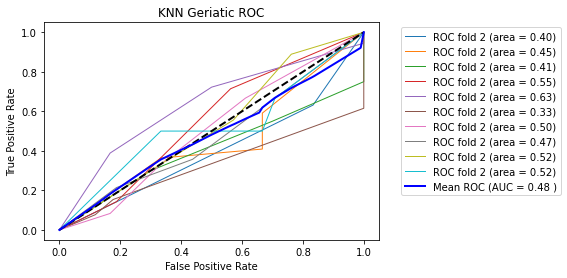

KNN Geriatic ROC AUC score : 0.48


In [110]:
tprs_ger = []
aucs_ger = []
cv = KFold(n_splits=10,shuffle=False)
mean_fpr_ger = np.linspace(0,1,100)
i = 1
for train,test in cv.split(X_ger,Y_ger):
    prediction = knn_ger.fit(X_ger[train],Y_ger[train]).predict_proba(X_ger[test])
    fpr, tpr, t = roc_curve(Y_ger[test], prediction[:, 1])
    knnplt = plot_roc_curve(knn_ger, X_ger[test], Y_ger[test],
                          lw=1, ax=ax)
    tprs_ger.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = metrics.auc(fpr,tpr)
    aucs_ger.append(knnplt.roc_auc)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i+1, roc_auc))
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='chance')

mean_tpr_ger = np.mean(tprs_ger, axis=0)
mean_tpr_ger[-1] = 1.0
knn_mean_auc_ger = metrics.auc(mean_fpr_ger, mean_tpr_ger)
std_auc = np.std(aucs_ger)
ax.plot(mean_fpr_ger, mean_tpr_ger, color='b',label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (knn_mean_auc_ger, std_auc),lw=2, alpha=.8)
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr_ger = np.mean(tprs_ger, axis=0)
#knn_mean_auc_ger = metrics.auc(mean_fpr_ger, mean_tpr_ger)
plt.plot(mean_fpr_ger, mean_tpr_ger, color='blue',
         label=r'Mean ROC (AUC = %0.2f )' % (knn_mean_auc_ger),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN Geriatic ROC')
plt.legend(loc="best",bbox_to_anchor=(1.05, 1))
plt.show()

print("KNN Geriatic ROC AUC score : {:.2f}".format(knn_mean_auc_ger))

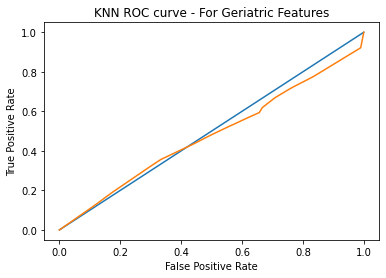

In [111]:
plt.plot([0,1],[0,1])
plt.plot(mean_fpr_ger,mean_tpr_ger, label='Knn')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN ROC curve - For Geriatric Features')
plt.show()

#### Optimizing parameters with GridSearchCV

In [112]:
#Optimizing parameters with GridSearchCV
k_range = list(range(1, 31))
knn_ger_grid= GridSearchCV(knn_ger,param_grid=knn_param_grid,cv=10,scoring='accuracy')
knn_ger_grid.fit(X_ger,Y_ger)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(n_neighbors=14),
             param_grid={'algorithm': ['auto', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [113]:
knn_ger_grid.best_score_

0.5503225806451613

In [114]:
knn_ger_grid.best_params_

{'algorithm': 'brute', 'n_neighbors': 3, 'weights': 'uniform'}

#### The best score after hypertuning is             with the above best parameters for KNN model - geriatic dataset

# Model # 2: Decision Tree classification

### Decision Tree - Sample tree structure 

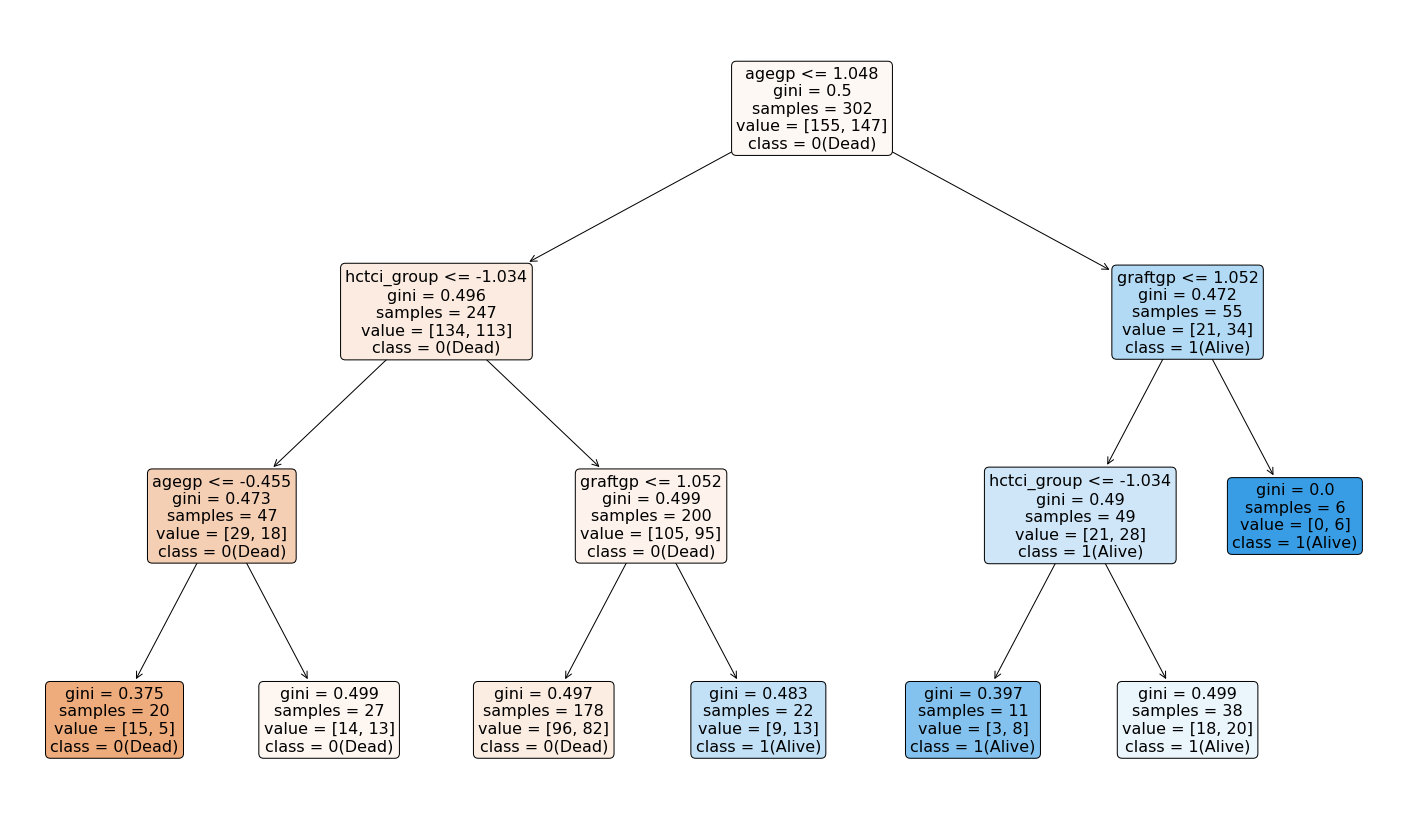

In [115]:
from sklearn.tree import plot_tree
tree = DecisionTreeClassifier(max_depth=3) #max_depth is maximum number of levels in the tree
t = tree.fit(X1,y1)
col_name = final_df.columns[:5]
fig = plt.figure(figsize=(25,15))
a = plot_tree(t,feature_names=col_name,class_names=['0(Dead)','1(Alive)'], 
              filled=True, 
              rounded=True, 
             fontsize=16)

## 2a - Clinical features

In [116]:
tree = DecisionTreeClassifier(max_depth=3)
tree.fit(X_train, y_train) 
decTree_y_pred = tree.predict(X_test)
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302 entries, 0 to 301
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   karnofcat     302 non-null    float64
 1   agegp         302 non-null    float64
 2   hctci_group   302 non-null    float64
 3   graftgp       302 non-null    float64
 4   BOMC_outcome  302 non-null    int64  
 5   IADL          302 non-null    int64  
 6   MOS           302 non-null    int64  
 7   TUG           302 non-null    int64  
 8   dead          302 non-null    float64
dtypes: float64(5), int64(4)
memory usage: 21.4 KB



Decision Tree Mean Model Accuracy : 0.53 

F1 Score : 0.53

Matthews score : 0.11


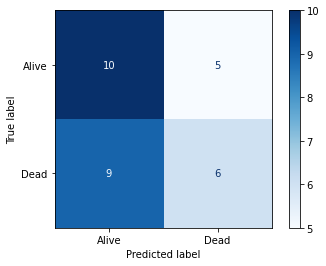

In [117]:
tree_acc = []
tree_conf = []
tree_f1 = []
tree_rocauc = []
tree_m_score = []
kf = KFold(n_splits=10, random_state=None, shuffle=False)
for train_index, test_index in kf.split(X1, y1):
    X_train, X_test = X1[train_index], X1[test_index]
    y_train, y_test = y1[train_index], y1[test_index]
    
    tree.fit(X_train, y_train)
    tree_y_pred = tree.predict(X_test)
    
    treescores = accuracy_score(y_test,tree_y_pred)
    tree_acc.append(treescores)
    tree_mean_acc = np.mean(tree_acc)
    
    tree_cm=confusion_matrix(y_test, tree_y_pred)
    tree_conf.append(tree_cm)
    
    tree_f1_s = f1_score(y_test,tree_y_pred,average='micro')
    tree_f1.append(tree_f1_s)
    
    tree_y_pred_prob = tree.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, tree_y_pred_prob) # fpr - False positive rate & TPR - True Positive rate
    auc = roc_auc_score(y_test, tree_y_pred_prob)
    #print("TREE : ROC - AUC Score: {:.2f}".format(auc))
    
    
    tree_rocauc_s = roc_auc_score(y_test,tree_y_pred)
    tree_rocauc.append(tree_rocauc_s)
    
    tree_m_score1 =matthews_corrcoef(y_test, tree_y_pred)
    tree_m_score.append(tree_m_score1)
    
tree_mean_mathew = np.mean(tree_m_score)
mean_of_conf_tree = np.mean(tree_conf,axis=0).round()
#print("Model accuracies : ",tree_acc)
print("\nDecision Tree Mean Model Accuracy : {:.2f} ".format(tree_mean_acc))

target_names = ['Alive','Dead']
tree_cv_y_pred = cross_val_predict(tree, X1, y1, cv=10)
#print("\n",classification_report(y1,tree_cv_y_pred,target_names = target_names))

print("\nF1 Score : {:.2f}".format(np.mean(tree_f1)))
#print("\nROC AUC Score : {:.2f} ".format(np.mean(tree_rocauc)))
print("\nMatthews score : {:.2f}".format(tree_mean_mathew))

cmd_tree = ConfusionMatrixDisplay(mean_of_conf_tree, display_labels=['Alive','Dead'])
cmd_tree.plot(cmap='Blues')

#### Confusion Matrix,ROC and AUC - Decision Tree

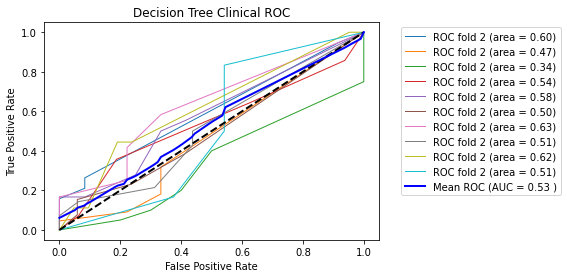

Decision Tree ROC AUC score : 0.53


In [118]:
tprs_tree = []
aucs_tree = []
cv = KFold(n_splits=10,shuffle=False)
mean_fpr_tree = np.linspace(0,1,100)
i = 1
for train,test in cv.split(X1,y1):
    prediction = tree.fit(X1[train],y1[train]).predict_proba(X1[test])
    fpr, tpr, t = roc_curve(y1[test], prediction[:, 1])
    treeplt = plot_roc_curve(tree, X1[test], y1[test],
                          alpha=0.3, lw=1, ax=ax)
    tprs_tree.append(np.interp(mean_fpr_tree, fpr, tpr))
    roc_auc_tree= metrics.auc(fpr,tpr)
    aucs_tree.append(treeplt.roc_auc)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i+1, roc_auc_tree))
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='random')

mean_tpr_tree = np.mean(tprs_tree, axis=0)
mean_tpr_tree[-1] = 1.0
mean_auc_tree = metrics.auc(mean_fpr_tree, mean_tpr_tree)
std_auc = np.std(aucs_tree)
ax.plot(mean_fpr_tree, mean_tpr_tree, color='b',label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_tree, std_auc),lw=2, alpha=.8)
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr_tree = np.mean(tprs_tree, axis=0)
mean_auc_tree = metrics.auc(mean_fpr_tree, mean_tpr_tree)
plt.plot(mean_fpr_tree, mean_tpr_tree, color='blue',
         label=r'Mean ROC (AUC = %0.2f )' % (mean_auc_tree),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree Clinical ROC')
plt.legend(loc="best",bbox_to_anchor=(1.05, 1))
plt.show()

print("Decision Tree ROC AUC score : {:.2f}".format(mean_auc_tree))

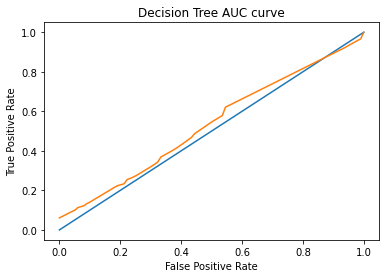

In [119]:
tree.fit(X_train,y_train)
plt.plot([0,1],[0,1])
plt.plot(mean_fpr_tree,mean_tpr_tree, label='Decision Tree')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree AUC curve')
plt.show()

#### Hyperparameter tuning with GridSearchCV - Clinical Features

In [120]:
param_tree = {'max_leaf_nodes': list(range(2, 100)), 
                  'min_samples_split': [2, 3, 4],
                  "max_depth": list(range(0, 100)),
                "criterion": ["gini", "entropy"]}
grid_tree = GridSearchCV(tree,param_grid = param_tree,n_jobs=-1,cv=10)
grid_tree.fit(X1,y1)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(max_depth=3), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23, 24, 25, 26, 27, 28, 29, ...],
                         'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24, 25, 26, 27, 28, 29, 30,
                                            31, ...],
                         'min_samples_split': [2, 3, 4]})

In [121]:
grid_tree.best_score_

0.5398924731182795

In [122]:
grid_tree.best_params_

{'criterion': 'gini',
 'max_depth': 1,
 'max_leaf_nodes': 2,
 'min_samples_split': 2}

## 2b Decision Tree for geriatric features

Model accuracies :  [0.3870967741935484, 0.3870967741935484, 0.3333333333333333, 0.5666666666666667, 0.4, 0.4666666666666667, 0.43333333333333335, 0.43333333333333335, 0.4, 0.4]

Decision Tree Mean Model Accuracy : 0.42 

F1 Score : 0.42

Matthews score : -0.07


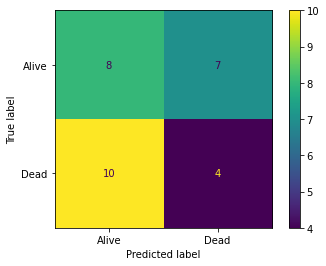

In [123]:
tree_ger =DecisionTreeClassifier(max_depth=3)
tree_ger_acc = []
tree_ger_conf = []
tree_ger_f1 = []
tree_ger_rocauc = []
tree_ger_m_score = []
kf = KFold(n_splits=10, random_state=None, shuffle=False)
for train_index, test_index in kf.split(X_ger, Y_ger):
    X_train, X_test = X_ger[train_index], X_ger[test_index]
    y_train, y_test = Y_ger[train_index], Y_ger[test_index]
    
    tree_ger.fit(X_train, y_train)
    tree_ger_y_pred = tree_ger.predict(X_test)
    
    treegerscores = accuracy_score(y_test,tree_ger_y_pred)
    tree_ger_acc.append(treegerscores)
    tree_ger_mean_acc = statistics.mean(tree_ger_acc)
    
    tree_ger_cm=confusion_matrix(y_test, tree_ger_y_pred)
    tree_ger_conf.append(tree_ger_cm)
    
    tree_ger_f1_s = f1_score(y_test,tree_ger_y_pred,average='micro')
    tree_ger_f1.append(tree_ger_f1_s)
    
    tree_ger_y_pred_prob = tree_ger.predict_proba(X_test)[:,1]
    fpr_ger, tpr_ger, thresholds = roc_curve(y_test, tree_ger_y_pred_prob) # fpr - False positive rate & TPR - True Positive rate
    auc_ger = roc_auc_score(y_test, tree_ger_y_pred_prob)
    #print("TREE : ROC - AUC Score: {:.2f}".format(auc))
    
    tree_ger_rocauc_s = roc_auc_score(y_test,tree_ger_y_pred)
    tree_ger_rocauc.append(tree_ger_rocauc_s)
    
    tree_ger_m =matthews_corrcoef(y_test, tree_ger_y_pred)
    tree_ger_m_score.append(tree_ger_m)
    

print("Model accuracies : ",tree_ger_acc)
print("\nDecision Tree Mean Model Accuracy : {:.2f} ".format(tree_ger_mean_acc))

#We can't completely rely on model accuracy for classification, hence we will calculate the confusion matrix
target_names = ['Alive','Dead']
tree_cv_y_pred = cross_val_predict(tree, X_ger, Y_ger, cv=10)
#print("\n",classification_report(Y_ger,tree_cv_y_pred,target_names = target_names))
print("\nF1 Score : {:.2f}".format(np.mean(tree_ger_f1)))
#print("\nROC AUC Score : {:.2f} ".format(np.mean(tree_ger_rocauc)))

#Confusion Matrix
#print("\nConfusion Matrix, ROC and AUC - TREE Geriatic Dataset")
ger_mean_of_conf = np.mean(tree_ger_conf,axis=0).round()
tree_cmd_ger = ConfusionMatrixDisplay(ger_mean_of_conf, display_labels=['Alive','Dead'])
tree_cmd_ger.plot()


# Mathew co-efficient score
tree_ger_mean_mathew = np.mean(tree_ger_m_score)
print("\nMatthews score : {:.2f}".format(tree_ger_mean_mathew))


### ROC and AUC

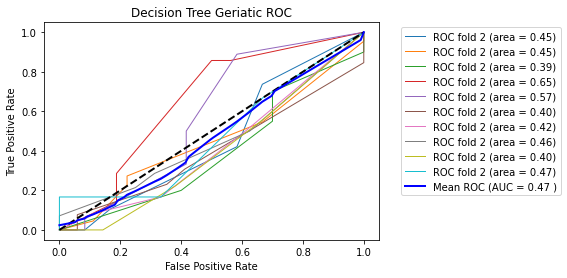

Decision Tree Geriatic ROC AUC score : 0.47


In [124]:
tprs_ger = []
aucs_ger = []
cv = KFold(n_splits=10,shuffle=False)
mean_fpr_ger = np.linspace(0,1,100)
i = 1
for train,test in cv.split(X_ger,Y_ger):
    prediction = tree_ger.fit(X_ger[train],Y_ger[train]).predict_proba(X_ger[test])
    fpr, tpr, t = roc_curve(Y_ger[test], prediction[:, 1])
    treeplt = plot_roc_curve(tree_ger, X_ger[test], Y_ger[test],
                          lw=1, ax=ax)
    tprs_ger.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc_ger = metrics.auc(fpr,tpr)
    aucs_ger.append(treeplt.roc_auc)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i+1, roc_auc_ger))
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='grey',label='chance')

mean_tpr_ger = np.mean(tprs_ger, axis=0)
mean_tpr_ger[-1] = 1.0
tree_mean_auc_ger = metrics.auc(mean_fpr_ger, mean_tpr_ger)
std_auc = np.std(aucs_ger)
ax.plot(mean_fpr_ger, mean_tpr_ger, color='b',label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (tree_mean_auc_ger, std_auc),lw=2, alpha=.8)
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr_ger = np.mean(tprs_ger, axis=0)
mean_auc_ger = metrics.auc(mean_fpr_ger, mean_tpr_ger)
plt.plot(mean_fpr_ger, mean_tpr_ger, color='blue',
         label=r'Mean ROC (AUC = %0.2f )' % (tree_mean_auc_ger),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree Geriatic ROC')
plt.legend(loc="best",bbox_to_anchor=(1.05, 1))
plt.show()

print("Decision Tree Geriatic ROC AUC score : {:.2f}".format(tree_mean_auc_ger))

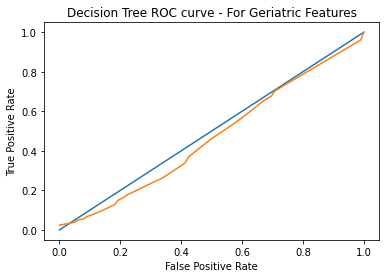

In [125]:
plt.plot([0,1],[0,1])
plt.plot(mean_fpr_ger,mean_tpr_ger, label='Decision Tree Geriatic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree ROC curve - For Geriatric Features')
plt.show()

###  Decision Tree Geriatic Features - GridSearchCV parameter Tuning 

In [126]:
#creates a tuple of hyperparameters we want the machine to test with as save them as param_dist
grid_tree_ger = GridSearchCV(tree_ger,param_grid = param_tree,n_jobs=-1,cv=10)

In [127]:
grid_tree_ger.fit(X_ger,Y_ger)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(max_depth=3), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23, 24, 25, 26, 27, 28, 29, ...],
                         'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24, 25, 26, 27, 28, 29, 30,
                                            31, ...],
                         'min_samples_split': [2, 3, 4]})

In [128]:
grid_tree_ger.best_score_

0.5233333333333332

In [129]:
grid_tree_ger.best_params_

{'criterion': 'gini',
 'max_depth': 1,
 'max_leaf_nodes': 2,
 'min_samples_split': 2}

# Model : XGBoost
## Model 3a - Clinical Features

In [130]:
xgb = XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.1, 
                  n_estimators=100, max_depth=3,use_label_encoder=False,eval_metric = "logloss")


Xgb Mean Model Accuracy : 0.50 

F1 Score : 0.50

Matthews score : 0.04


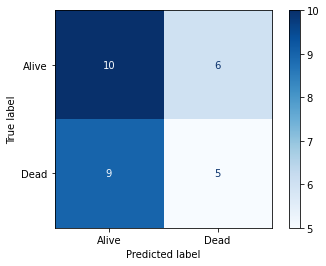

In [131]:
xgb_acc = []
xgb_conf = []
xgb_f1 = []
xgb_rocauc = []
xgb_m_score = []
kf = KFold(n_splits=10, random_state=None, shuffle=False)
for train_index, test_index in kf.split(X1, y1):
    X_train, X_test = X1[train_index], X1[test_index]
    y_train, y_test = y1[train_index], y1[test_index]
    
    xgb.fit(X_train, y_train)
    xgb_y_pred = xgb.predict(X_test)
    
    xgbscores = accuracy_score(y_test,xgb_y_pred)
    xgb_acc.append(xgbscores)
    xgb_mean_acc = np.mean(xgb_acc)
    
    xgb_cm=confusion_matrix(y_test, xgb_y_pred)
    xgb_conf.append(xgb_cm)
    
    xgb_f1_s = f1_score(y_test,xgb_y_pred,average='micro')
    xgb_f1.append(xgb_f1_s)
    
    xgb_y_pred_prob = xgb.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, xgb_y_pred_prob) # fpr - False positive rate & TPR - True Positive rate
    auc = roc_auc_score(y_test, xgb_y_pred_prob)
    #print("XGB : ROC - AUC Score: {:.2f}".format(auc))
    
    
    xgb_rocauc_s = roc_auc_score(y_test,xgb_y_pred)
    xgb_rocauc.append(xgb_rocauc_s)
    
    xgb_m_score1 =matthews_corrcoef(y_test, xgb_y_pred)
    xgb_m_score.append(xgb_m_score1)
    
xgb_mean_mathew = np.mean(xgb_m_score)
mean_of_conf_xgb = np.mean(xgb_conf,axis=0).round()
#print("Model accuracies : ",xgb_acc)
print("\nXgb Mean Model Accuracy : {:.2f} ".format(xgb_mean_acc))

target_names = ['Alive','Dead']
xgb_cv_y_pred = cross_val_predict(xgb, X1, y1, cv=10)
#print("\n",classification_report(y1,xgb_cv_y_pred,target_names = target_names))

print("\nF1 Score : {:.2f}".format(np.mean(xgb_f1)))
#print("\nROC AUC Score : {:.2f} ".format(np.mean(xgb_rocauc)))
print("\nMatthews score : {:.2f}".format(xgb_mean_mathew))

cmd_xgb = ConfusionMatrixDisplay(mean_of_conf_xgb, display_labels=['Alive','Dead'])
cmd_xgb.plot(cmap='Blues')


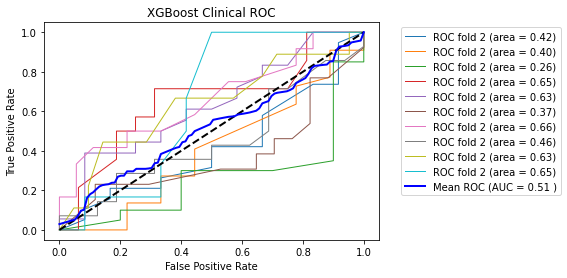

XGBoost Clinical ROC AUC score : 0.51


In [132]:
tprs = []
aucs = []
cv = KFold(n_splits=10,shuffle=False)
mean_fpr = np.linspace(0,1,100)
i = 1
for train,test in cv.split(X1,y1):
    prediction = xgb.fit(X1[train],y1[train]).predict_proba(X1[test])
    fpr, tpr, t = roc_curve(y1[test], prediction[:, 1])
    xgbplt = plot_roc_curve(xgb, X1[test], y1[test],
                          alpha=0.3, lw=1, ax=ax)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = metrics.auc(fpr,tpr)
    aucs.append(xgbplt.roc_auc)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i+1, roc_auc))
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='chance')

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
xgb_mean_auc = metrics.auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (xgb_mean_auc, std_auc),lw=2, alpha=.8)
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
xgb_mean_auc = metrics.auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.2f )' % (xgb_mean_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost Clinical ROC')
plt.legend(loc="best",bbox_to_anchor=(1.05, 1))
plt.show()

print("XGBoost Clinical ROC AUC score : {:.2f}".format(xgb_mean_auc))

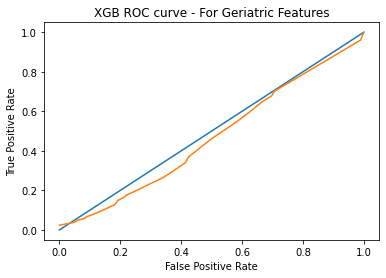

In [133]:
plt.plot([0,1],[0,1])
plt.plot(mean_fpr_ger,mean_tpr_ger, label='Knn')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGB ROC curve - For Geriatric Features')
plt.show()

#### Hyperparameter tuning

In [134]:
params={
 "learning_rate"    : [ 0.10, 0.15, 0.20, 0.25 ] ,
 "max_depth"        : [ 3, 4, 5 ],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 ]
    
}

xgb_grid = GridSearchCV(xgb, param_grid = params, cv=10, scoring='accuracy', return_train_score=False)
xgb_grid.fit(X1, y1)

GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, eval_metric='logloss',
                                     gamma=0, gpu_id=-1, importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=nan, monotone_constraints='()',
                                     n_estimators=100, n_jobs=-1,
                                     num_parallel_tree=1, random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, subsample=1,
                                     tree_method='exact',
                                     use_label_encod

In [135]:
xgb_grid.best_score_

0.5633333333333332

In [136]:
xgb_grid.best_params_

{'colsample_bytree': 0.3,
 'gamma': 0.0,
 'learning_rate': 0.2,
 'max_depth': 3,
 'min_child_weight': 7}

## Model 3b using geriatric features


Xgb_ger Mean Model Accuracy : 0.43 

F1 Score : 0.43

Matthews score : -0.06


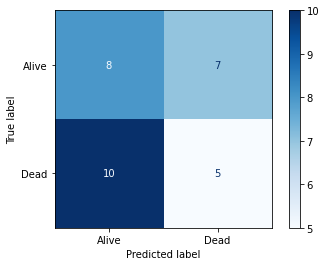

In [137]:
xgb_ger = XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.1, 
                  n_estimators=100, max_depth=3,use_label_encoder=False,eval_metric = "logloss")
xgb_ger_acc = []
xgb_ger_conf = []
xgb_ger_f1 = []
xgb_ger_rocauc = []
xgb_ger_m_score = []
kf = KFold(n_splits=10, random_state=None, shuffle=False)
for train_index, test_index in kf.split(X_ger, Y_ger):
    X_train_ger, X_test_ger = X_ger[train_index], X_ger[test_index]
    y_train_ger, y_test_ger = Y_ger[train_index], Y_ger[test_index]
    
    xgb_ger.fit(X_train_ger, y_train_ger)
    xgb_ger_y_pred = xgb_ger.predict(X_test_ger)
    
    xgb_gerscores = accuracy_score(y_test_ger,xgb_ger_y_pred)
    xgb_ger_acc.append(xgb_gerscores)
    xgb_ger_mean_acc = np.mean(xgb_ger_acc)
    
    xgb_ger_cm=confusion_matrix(y_test_ger, xgb_ger_y_pred)
    xgb_ger_conf.append(xgb_ger_cm)
    
    xgb_ger_f1_s = f1_score(y_test_ger,xgb_ger_y_pred,average='micro')
    xgb_ger_f1.append(xgb_ger_f1_s)
    
    xgb_ger_y_pred_prob = xgb_ger.predict_proba(X_test_ger)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test_ger, xgb_ger_y_pred_prob) # fpr - False positive rate & TPR - True Positive rate
    auc = roc_auc_score(y_test_ger, xgb_ger_y_pred_prob)
    #print("XGB_GER : ROC - AUC Score: {:.2f}".format(auc))
    
    
    xgb_ger_rocauc_s = roc_auc_score(y_test_ger,xgb_ger_y_pred)
    xgb_ger_rocauc.append(xgb_ger_rocauc_s)
    
    xgb_ger_m_score1 =matthews_corrcoef(y_test_ger, xgb_ger_y_pred)
    xgb_ger_m_score.append(xgb_ger_m_score1)
    
xgb_ger_mean_mathew = np.mean(xgb_ger_m_score)
mean_of_conf_xgb_ger = np.mean(xgb_ger_conf,axis=0).round()
#print("Model accuracies : ",xgb_ger_acc)
print("\nXgb_ger Mean Model Accuracy : {:.2f} ".format(xgb_ger_mean_acc))

target_names = ['Alive','Dead']
xgb_ger_cv_y_pred = cross_val_predict(xgb_ger, X_ger, Y_ger, cv=10)
#print("\n",classification_report(y1,xgb_ger_cv_y_pred,target_names = target_names))

print("\nF1 Score : {:.2f}".format(np.mean(xgb_ger_f1)))
#print("\nROC AUC Score : {:.2f} ".format(np.mean(xgb_ger_rocauc)))
print("\nMatthews score : {:.2f}".format(xgb_ger_mean_mathew))

cmd_xgb_ger = ConfusionMatrixDisplay(mean_of_conf_xgb_ger, display_labels=['Alive','Dead'])
cmd_xgb_ger.plot(cmap='Blues')


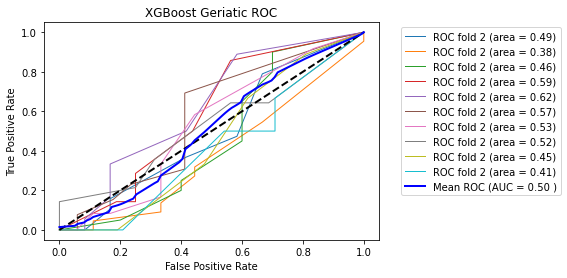

XGBoost Geriatic ROC AUC score : 0.50


In [138]:
tprs_ger = []
aucs_ger = []
cv = KFold(n_splits=10,shuffle=False)
mean_fpr_ger = np.linspace(0,1,100)
i = 1
for train,test in cv.split(X_ger,Y_ger):
    prediction = xgb_ger.fit(X_ger[train],Y_ger[train]).predict_proba(X_ger[test])
    fpr, tpr, t = roc_curve(Y_ger[test], prediction[:, 1])
    xgbplt = plot_roc_curve(xgb_ger, X_ger[test], Y_ger[test],
                          lw=1, ax=ax)
    tprs_ger.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = metrics.auc(fpr,tpr)
    aucs_ger.append(xgbplt.roc_auc)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i+1, roc_auc))
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='chance')

mean_tpr_ger = np.mean(tprs_ger, axis=0)
mean_tpr_ger[-1] = 1.0
xgb_mean_auc_ger = metrics.auc(mean_fpr_ger, mean_tpr_ger)
std_auc = np.std(aucs_ger)
ax.plot(mean_fpr_ger, mean_tpr_ger, color='b',label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (xgb_mean_auc_ger, std_auc),lw=2, alpha=.8)
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr_ger = np.mean(tprs_ger, axis=0)

plt.plot(mean_fpr_ger, mean_tpr_ger, color='blue',
         label=r'Mean ROC (AUC = %0.2f )' % (xgb_mean_auc_ger),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost Geriatic ROC')
plt.legend(loc="best",bbox_to_anchor=(1.05, 1))
plt.show()

print("XGBoost Geriatic ROC AUC score : {:.2f}".format(xgb_mean_auc_ger))

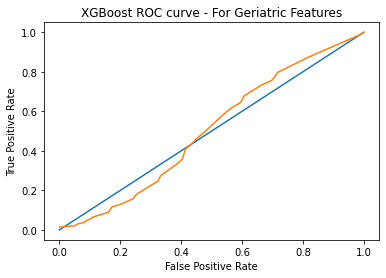

In [139]:
plt.plot([0,1],[0,1])
plt.plot(mean_fpr_ger,mean_tpr_ger, label='XGB')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost ROC curve - For Geriatric Features')
plt.show()

#### Hyperparameter tuning

In [140]:
xgb_grid = GridSearchCV(xgb_ger, param_grid = params, cv=10, scoring='accuracy', return_train_score=False)
xgb_grid.fit(X_ger, Y_ger)

GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, eval_metric='logloss',
                                     gamma=0, gpu_id=-1, importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=nan, monotone_constraints='()',
                                     n_estimators=100, n_jobs=-1,
                                     num_parallel_tree=1, random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, subsample=1,
                                     tree_method='exact',
                                     use_label_encod

In [141]:
xgb_grid.best_score_

0.5133333333333333

In [142]:
xgb_grid.best_params_

{'colsample_bytree': 0.3,
 'gamma': 0.0,
 'learning_rate': 0.1,
 'max_depth': 3,
 'min_child_weight': 1}

# Model # 4: Random Forest classification
## Model 4a - clinical features


Random Forest Mean Model Accuracy : 0.48 

F1 Score : 0.48

Matthews score : -0.03


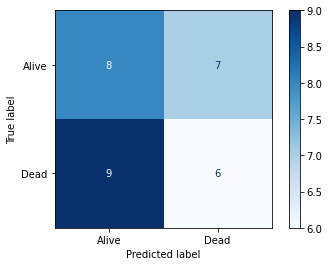

In [143]:
rfc = RandomForestClassifier()
rfc_acc = []
rfc_conf = []
rfc_f1 = []
rfc_rocauc = []
rfc_m_score = []
kf = KFold(n_splits=10, random_state=None, shuffle=False)
for train_index, test_index in kf.split(X1, y1):
    X_train, X_test = X1[train_index], X1[test_index]
    y_train, y_test = y1[train_index], y1[test_index]
    
    rfc.fit(X_train, y_train)
    rfc_y_pred = rfc.predict(X_test)
    
    rfcscores = accuracy_score(y_test,rfc_y_pred)
    rfc_acc.append(rfcscores)
    rfc_mean_acc = np.mean(rfc_acc)
    
    rfc_cm=confusion_matrix(y_test, rfc_y_pred)
    rfc_conf.append(rfc_cm)
    
    rfc_f1_s = f1_score(y_test,rfc_y_pred,average='micro')
    rfc_f1.append(rfc_f1_s)
    
    rfc_y_pred_prob = rfc.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, rfc_y_pred_prob) # fpr - False positive rate & TPR - True Positive rate
    auc = roc_auc_score(y_test, rfc_y_pred_prob)
    #print("TREE : ROC - AUC Score: {:.2f}".format(auc))
    
    
    rfc_rocauc_s = roc_auc_score(y_test,rfc_y_pred)
    rfc_rocauc.append(rfc_rocauc_s)
    
    rfc_m_score1 =matthews_corrcoef(y_test, rfc_y_pred)
    rfc_m_score.append(rfc_m_score1)
    
rfc_mean_mathew = np.mean(rfc_m_score)
mean_of_conf_rfc = np.mean(rfc_conf,axis=0).round()
print("\nRandom Forest Mean Model Accuracy : {:.2f} ".format(rfc_mean_acc))

target_names = ['Alive','Dead']
rfc_cv_y_pred = cross_val_predict(rfc, X1, y1, cv=10)
#print("\n",classification_report(y1,rfc_cv_y_pred,target_names = target_names))

print("\nF1 Score : {:.2f}".format(np.mean(rfc_f1)))
#print("\nROC AUC Score : {:.2f} ".format(np.mean(rfc_rocauc)))
print("\nMatthews score : {:.2f}".format(rfc_mean_mathew))

cmd_rfc = ConfusionMatrixDisplay(mean_of_conf_rfc, display_labels=['Alive','Dead'])
cmd_rfc.plot(cmap='Blues')

#### Confusion Matrix,ROC and AUC

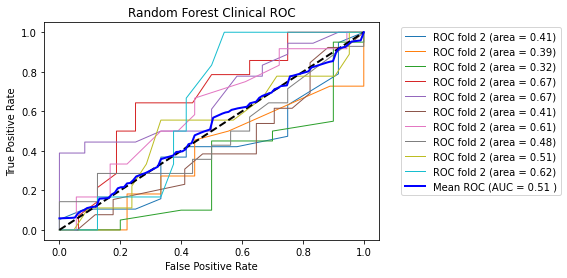

Random Forest ROC AUC score : 0.51


In [144]:
tprs_rfc = []
aucs_rfc = []
cv = KFold(n_splits=10,shuffle=False)
mean_fpr_rfc = np.linspace(0,1,100)
i = 1
for train,test in cv.split(X1,y1):
    prediction = rfc.fit(X1[train],y1[train]).predict_proba(X1[test])
    fpr, tpr, t = roc_curve(y1[test], prediction[:, 1])
    rfcplt = plot_roc_curve(rfc, X1[test], y1[test],
                          alpha=0.3, lw=1, ax=ax)
    tprs_rfc.append(np.interp(mean_fpr_rfc, fpr, tpr))
    roc_auc_rfc= metrics.auc(fpr,tpr)
    aucs_rfc.append(rfcplt.roc_auc)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i+1, roc_auc_rfc))
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='random')

mean_tpr_rfc = np.mean(tprs_rfc, axis=0)
mean_tpr_rfc[-1] = 1.0
mean_auc_rfc = metrics.auc(mean_fpr_rfc, mean_tpr_rfc)
std_auc = np.std(aucs_rfc)
ax.plot(mean_fpr_rfc, mean_tpr_rfc, color='b',label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_rfc, std_auc),lw=2, alpha=.8)
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr_rfc = np.mean(tprs_rfc, axis=0)
mean_auc_rfc = metrics.auc(mean_fpr_rfc, mean_tpr_rfc)
plt.plot(mean_fpr_rfc, mean_tpr_rfc, color='blue',
         label=r'Mean ROC (AUC = %0.2f )' % (mean_auc_rfc),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest Clinical ROC')
plt.legend(loc="best",bbox_to_anchor=(1.05, 1))
plt.show()

print("Random Forest ROC AUC score : {:.2f}".format(mean_auc_rfc))

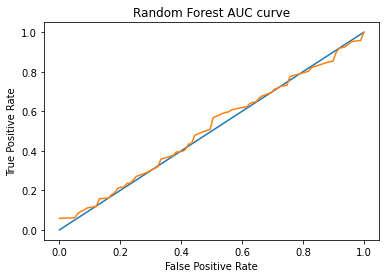

In [145]:
rfc.fit(X_train,y_train)
plt.plot([0,1],[0,1])
plt.plot(mean_fpr_rfc,mean_tpr_rfc, label='Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest AUC curve')
plt.show()

#### Hyperparameter tuning using GridSearchCV

In [146]:
crit = ['gini', 'entropy']
depth = np.arange(10, 20)
samples_split = np.arange(2, 5)
nodes = list(range(2, 10))

rfc_param_grid = dict(criterion = crit, max_depth = depth, min_samples_split = samples_split, max_leaf_nodes = nodes)

In [147]:
rfc_grid = GridSearchCV(rfc, rfc_param_grid, cv=10, scoring='accuracy', return_train_score=False)
rfc_grid.fit(X1, y1)

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),
                         'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9],
                         'min_samples_split': array([2, 3, 4])},
             scoring='accuracy')

In [148]:
print(rfc_grid.best_score_)
print(rfc_grid.best_params_)

0.5536559139784945
{'criterion': 'entropy', 'max_depth': 15, 'max_leaf_nodes': 4, 'min_samples_split': 3}


## Model 4b - geriatric assessment features


Random Forest Mean Model Accuracy : 0.47 

F1 Score : 0.47

Matthews score : -0.01


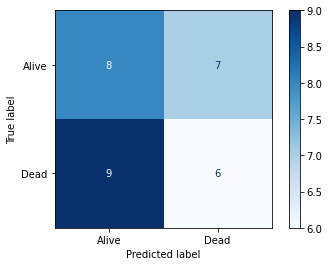

In [149]:
rfc_ger = RandomForestClassifier()
rfc_acc_ger = []
rfc_conf_ger = []
rfc_f1_ger = []
rfc_rocauc_ger = []
rfc_m_score_ger = []
kf = KFold(n_splits=10, random_state=None, shuffle=False)
for train_index, test_index in kf.split(X_ger, Y_ger):
    X_train, X_test = X_ger[train_index], X_ger[test_index]
    y_train, y_test = Y_ger[train_index], Y_ger[test_index]
    
    rfc_ger.fit(X_train, y_train)
    rfc_y_pred_ger = rfc_ger.predict(X_test)
    
    rfcscores_ger = accuracy_score(y_test,rfc_y_pred_ger)
    rfc_acc_ger.append(rfcscores_ger)
    rfc_mean_acc_ger = np.mean(rfc_acc_ger)
    
    rfc_cm_ger=confusion_matrix(y_test, rfc_y_pred_ger)
    rfc_conf_ger.append(rfc_cm_ger)
    
    rfc_f1_s_ger = f1_score(y_test,rfc_y_pred_ger,average='micro')
    rfc_f1_ger.append(rfc_f1_s_ger)
    
    rfc_y_pred_prob_ger = rfc_ger.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, rfc_y_pred_prob_ger) # fpr - False positive rate & TPR - True Positive rate
    auc = roc_auc_score(y_test, rfc_y_pred_prob_ger)
    #print("TREE : ROC - AUC Score: {:.2f}".format(auc))
    
    
    rfc_rocauc_s_ger = roc_auc_score(y_test,rfc_y_pred_ger)
    rfc_rocauc_ger.append(rfc_rocauc_s_ger)
    
    rfc_m_score1_ger =matthews_corrcoef(y_test, rfc_y_pred_ger)
    rfc_m_score_ger.append(rfc_m_score1_ger)
    
rfc_mean_mathew_ger = np.mean(rfc_m_score_ger)
mean_of_conf_rfc_ger = np.mean(rfc_conf_ger,axis=0).round()
print("\nRandom Forest Mean Model Accuracy : {:.2f} ".format(rfc_mean_acc_ger))

target_names = ['Alive','Dead']
rfc_cv_y_pred_ger = cross_val_predict(rfc_ger, X_ger, Y_ger, cv=10)
#print("\n",classification_report(y1,rfc_cv_y_pred,target_names = target_names))

print("\nF1 Score : {:.2f}".format(np.mean(rfc_f1_ger)))
#print("\nROC AUC Score : {:.2f} ".format(np.mean(rfc_rocauc)))
print("\nMatthews score : {:.2f}".format(rfc_mean_mathew_ger))

cmd_rfc_ger = ConfusionMatrixDisplay(mean_of_conf_rfc_ger, display_labels=['Alive','Dead'])
cmd_rfc_ger.plot(cmap='Blues')

#### Confusion Matrix,ROC and AUC 

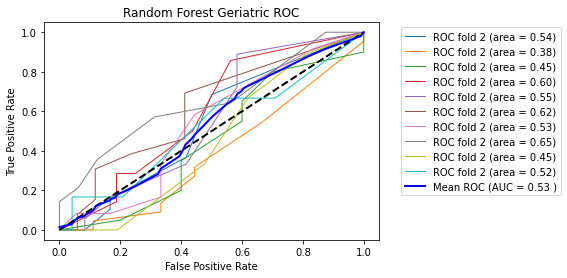

Random Forest ROC AUC score : 0.53


In [150]:
tprs_rfc_ger = []
aucs_rfc_ger = []
cv = KFold(n_splits=10,shuffle=False)
mean_fpr_rfc_ger = np.linspace(0,1,100)
i = 1
for train,test in cv.split(X_ger,Y_ger):
    prediction = rfc_ger.fit(X_ger[train],Y_ger[train]).predict_proba(X_ger[test])
    fpr, tpr, t = roc_curve(Y_ger[test], prediction[:, 1])
    rfcplt_ger = plot_roc_curve(rfc_ger, X_ger[test], Y_ger[test],
                          alpha=0.3, lw=1, ax=ax)
    tprs_rfc_ger.append(np.interp(mean_fpr_rfc_ger, fpr, tpr))
    roc_auc_rfc_ger= metrics.auc(fpr,tpr)
    aucs_rfc_ger.append(rfcplt.roc_auc)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i+1, roc_auc_rfc_ger))
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='random')

mean_tpr_rfc_ger = np.mean(tprs_rfc_ger, axis=0)
mean_tpr_rfc_ger[-1] = 1.0
mean_auc_rfc_ger = metrics.auc(mean_fpr_rfc_ger, mean_tpr_rfc_ger)
std_auc = np.std(aucs_rfc_ger)
ax.plot(mean_fpr_rfc_ger, mean_tpr_rfc_ger, color='b',label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_rfc_ger, std_auc),lw=2, alpha=.8)
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr_rfc_ger = np.mean(tprs_rfc_ger, axis=0)
mean_auc_rfc_ger = metrics.auc(mean_fpr_rfc_ger, mean_tpr_rfc_ger)
plt.plot(mean_fpr_rfc_ger, mean_tpr_rfc_ger, color='blue',
         label=r'Mean ROC (AUC = %0.2f )' % (mean_auc_rfc_ger),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest Geriatric ROC')
plt.legend(loc="best",bbox_to_anchor=(1.05, 1))
plt.show()

print("Random Forest ROC AUC score : {:.2f}".format(mean_auc_rfc_ger))

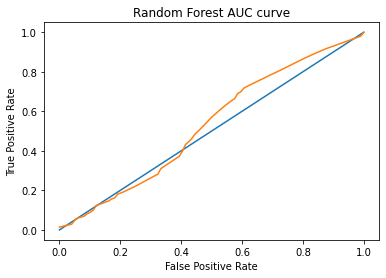

In [151]:
rfc_ger.fit(X_train,y_train)
plt.plot([0,1],[0,1])
plt.plot(mean_fpr_rfc_ger,mean_tpr_rfc_ger, label='Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest AUC curve')
plt.show()

### Hyperparameter tuning

In [152]:
rfc_grid_ger = GridSearchCV(rfc_ger, rfc_param_grid, cv=10, scoring='accuracy', return_train_score=False)
rfc_grid_ger.fit(X_ger, Y_ger)

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),
                         'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9],
                         'min_samples_split': array([2, 3, 4])},
             scoring='accuracy')

In [153]:
print(rfc_grid_ger.best_score_)
print(rfc_grid_ger.best_params_)

0.53
{'criterion': 'gini', 'max_depth': 12, 'max_leaf_nodes': 2, 'min_samples_split': 4}


# Model 5 - SVM
## Model 5a Clinical Features


SVM Mean Model Accuracy : 0.49 

F1 Score : 0.49

Matthews score : 0.04


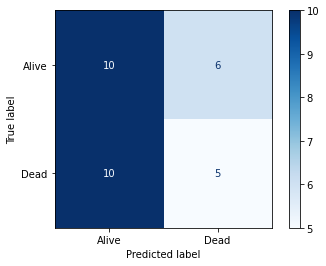

In [154]:
svm = SVC(probability=True)
svm_acc = []
svm_conf = []
svm_f1 = []
svm_rocauc = []
svm_m_score = []
kf = KFold(n_splits=10, random_state=None, shuffle=False)
for train_index, test_index in kf.split(X1, y1):
    X_train, X_test = X1[train_index], X1[test_index]
    y_train, y_test = y1[train_index], y1[test_index]
    
    svm.fit(X_train, y_train)
    svm_y_pred = svm.predict(X_test)
    
    svmscores = accuracy_score(y_test,svm_y_pred)
    svm_acc.append(svmscores)
    svm_mean_acc = np.mean(svm_acc)
    
    svm_cm=confusion_matrix(y_test, svm_y_pred)
    svm_conf.append(svm_cm)
    
    svm_f1_s = f1_score(y_test,svm_y_pred,average='micro')
    svm_f1.append(svm_f1_s)
    
    svm_y_pred_prob = svm.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, svm_y_pred_prob) # fpr - False positive rate & TPR - True Positive rate
    auc = roc_auc_score(y_test, svm_y_pred_prob)
    #print("TREE : ROC - AUC Score: {:.2f}".format(auc))
    
    
    svm_rocauc_s = roc_auc_score(y_test,svm_y_pred)
    svm_rocauc.append(svm_rocauc_s)
    
    svm_m_score1 =matthews_corrcoef(y_test, svm_y_pred)
    svm_m_score.append(svm_m_score1)
    
svm_mean_mathew = np.mean(svm_m_score)
mean_of_conf_svm = np.mean(svm_conf,axis=0).round()
print("\nSVM Mean Model Accuracy : {:.2f} ".format(svm_mean_acc))

target_names = ['Alive','Dead']
svm_cv_y_pred = cross_val_predict(svm, X1, y1, cv=10)
#print("\n",classification_report(y1,rfc_cv_y_pred,target_names = target_names))

print("\nF1 Score : {:.2f}".format(np.mean(svm_f1)))
#print("\nROC AUC Score : {:.2f} ".format(np.mean(rfc_rocauc)))
print("\nMatthews score : {:.2f}".format(svm_mean_mathew))

cmd_svm = ConfusionMatrixDisplay(mean_of_conf_svm, display_labels=['Alive','Dead'])
cmd_svm.plot(cmap='Blues')

#### Confusion Matrix,ROC and AUC 

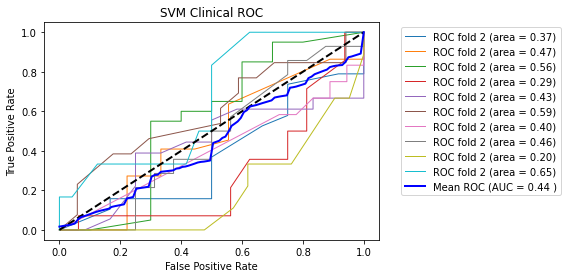

SVM clinical ROC AUC score : 0.44


In [155]:
tprs_svm = []
aucs_svm = []
cv = KFold(n_splits=10,shuffle=False)
mean_fpr_svm = np.linspace(0,1,100)
i = 1
for train,test in cv.split(X1,y1):
    prediction = svm.fit(X1[train],y1[train]).predict_proba(X1[test])
    fpr, tpr, t = roc_curve(y1[test], prediction[:, 1])
    svmplt = plot_roc_curve(svm, X1[test], y1[test],
                          alpha=0.3, lw=1, ax=ax)
    tprs_svm.append(np.interp(mean_fpr_svm, fpr, tpr))
    roc_auc_svm= metrics.auc(fpr,tpr)
    aucs_svm.append(svmplt.roc_auc)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i+1, roc_auc_svm))
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='random')

mean_tpr_svm = np.mean(tprs_svm, axis=0)
mean_tpr_svm[-1] = 1.0
mean_auc_svm = metrics.auc(mean_fpr_svm, mean_tpr_svm)
std_auc = np.std(aucs_svm)
ax.plot(mean_fpr_svm, mean_tpr_svm, color='b',label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_svm, std_auc),lw=2, alpha=.8)
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr_svm = np.mean(tprs_svm, axis=0)
mean_auc_svm = metrics.auc(mean_fpr_svm, mean_tpr_svm)
plt.plot(mean_fpr_svm, mean_tpr_svm, color='blue',
         label=r'Mean ROC (AUC = %0.2f )' % (mean_auc_svm),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM Clinical ROC')
plt.legend(loc="best",bbox_to_anchor=(1.05, 1))
plt.show()

print("SVM clinical ROC AUC score : {:.2f}".format(mean_auc_svm))

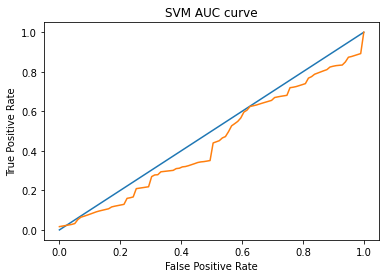

In [156]:
svm.fit(X_train,y_train)
plt.plot([0,1],[0,1])
plt.plot(mean_fpr_svm,mean_tpr_svm, label='SVM')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM AUC curve')
plt.show()

#### Hyperparameter tuning using GridSearchCV

In [157]:
c = [0.1, 1, 10, 100]
gam = [0.01, 0.1, 1]

svm_param_grid = dict(C = c, gamma = gam)

In [158]:
svm_grid = GridSearchCV(svm, svm_param_grid, cv=10, scoring='accuracy', return_train_score=False)
svm_grid.fit(X1, y1)

GridSearchCV(cv=10, estimator=SVC(probability=True),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [0.01, 0.1, 1]},
             scoring='accuracy')

In [159]:
print(svm_grid.best_score_)
print(svm_grid.best_params_)

0.5498924731182795
{'C': 10, 'gamma': 0.01}


## Model 5b - Geriatric Features


SVM Mean Model Accuracy : 0.45 

F1 Score : 0.45

Matthews score : -0.03


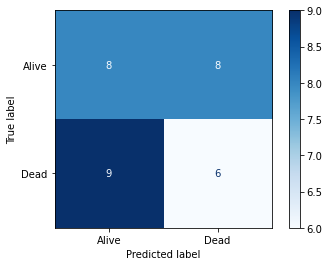

In [160]:
svm_ger = SVC(probability=True)
svm_acc_ger = []
svm_conf_ger = []
svm_f1_ger = []
svm_rocauc_ger = []
svm_m_score_ger = []
kf = KFold(n_splits=10, random_state=None, shuffle=False)
for train_index, test_index in kf.split(X_ger, Y_ger):
    X_train, X_test = X_ger[train_index], X_ger[test_index]
    y_train, y_test = Y_ger[train_index], Y_ger[test_index]
    
    svm_ger.fit(X_train, y_train)
    svm_y_pred_ger = svm_ger.predict(X_test)
    
    svmscores_ger = accuracy_score(y_test,svm_y_pred_ger)
    svm_acc_ger.append(svmscores_ger)
    svm_mean_acc_ger = np.mean(svm_acc_ger)
    
    svm_cm_ger=confusion_matrix(y_test, svm_y_pred_ger)
    svm_conf_ger.append(svm_cm_ger)
    
    svm_f1_s_ger = f1_score(y_test,svm_y_pred_ger,average='micro')
    svm_f1_ger.append(svm_f1_s_ger)
    
    svm_y_pred_prob_ger = svm_ger.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, svm_y_pred_prob_ger) # fpr - False positive rate & TPR - True Positive rate
    auc = roc_auc_score(y_test, svm_y_pred_prob_ger)
    #print("TREE : ROC - AUC Score: {:.2f}".format(auc))
    
    
    svm_rocauc_s_ger = roc_auc_score(y_test,svm_y_pred_ger)
    svm_rocauc_ger.append(svm_rocauc_s_ger)
    
    svm_m_score1_ger =matthews_corrcoef(y_test, svm_y_pred_ger)
    svm_m_score_ger.append(svm_m_score1_ger)
    
svm_mean_mathew_ger = np.mean(svm_m_score_ger)
mean_of_conf_svm_ger = np.mean(svm_conf_ger,axis=0).round()
print("\nSVM Mean Model Accuracy : {:.2f} ".format(svm_mean_acc_ger))

target_names = ['Alive','Dead']
svm_cv_y_pred_ger = cross_val_predict(svm_ger, X_ger, Y_ger, cv=10)
#print("\n",classification_report(y1,svm_cv_y_pred,target_names = target_names))

print("\nF1 Score : {:.2f}".format(np.mean(svm_f1_ger)))
#print("\nROC AUC Score : {:.2f} ".format(np.mean(svm_rocauc)))
print("\nMatthews score : {:.2f}".format(svm_mean_mathew_ger))

cmd_svm_ger = ConfusionMatrixDisplay(mean_of_conf_svm_ger, display_labels=['Alive','Dead'])
cmd_svm_ger.plot(cmap='Blues')

#### Confusion Matrix,ROC and AUC

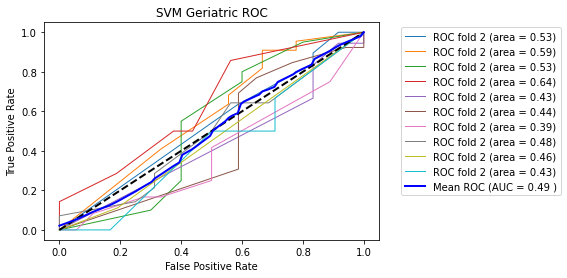

SVM ROC AUC score : 0.49


In [161]:
tprs_svm_ger = []
aucs_svm_ger = []
cv = KFold(n_splits=10,shuffle=False)
mean_fpr_svm_ger = np.linspace(0,1,100)
i = 1
for train,test in cv.split(X_ger,Y_ger):
    prediction = svm_ger.fit(X_ger[train],Y_ger[train]).predict_proba(X_ger[test])
    fpr, tpr, t = roc_curve(Y_ger[test], prediction[:, 1])
    svmplt_ger = plot_roc_curve(svm_ger, X_ger[test], Y_ger[test],
                          alpha=0.3, lw=1, ax=ax)
    tprs_svm_ger.append(np.interp(mean_fpr_svm_ger, fpr, tpr))
    roc_auc_svm_ger= metrics.auc(fpr,tpr)
    aucs_svm_ger.append(svmplt.roc_auc)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i+1, roc_auc_svm_ger))
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='random')

mean_tpr_svm_ger = np.mean(tprs_svm_ger, axis=0)
mean_tpr_svm_ger[-1] = 1.0
mean_auc_svm_ger = metrics.auc(mean_fpr_svm_ger, mean_tpr_svm_ger)
std_auc = np.std(aucs_svm_ger)
ax.plot(mean_fpr_svm_ger, mean_tpr_svm_ger, color='b',label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_svm_ger, std_auc),lw=2, alpha=.8)
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr_svm_ger = np.mean(tprs_svm_ger, axis=0)
mean_auc_svm_ger = metrics.auc(mean_fpr_svm_ger, mean_tpr_svm_ger)
plt.plot(mean_fpr_svm_ger, mean_tpr_svm_ger, color='blue',
         label=r'Mean ROC (AUC = %0.2f )' % (mean_auc_svm_ger),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM Geriatric ROC')
plt.legend(loc="best",bbox_to_anchor=(1.05, 1))
plt.show()

print("SVM ROC AUC score : {:.2f}".format(mean_auc_svm_ger))

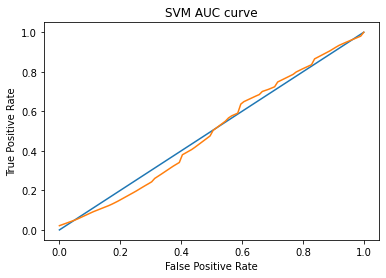

In [162]:
svm_ger.fit(X_train,y_train)
plt.plot([0,1],[0,1])
plt.plot(mean_fpr_svm_ger,mean_tpr_svm_ger, label='SVM')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM AUC curve')
plt.show()

#### Hyperparameter tuning using GridSearchCV

In [163]:
svm_grid_ger = GridSearchCV(svm_ger, svm_param_grid, cv=10, scoring='accuracy', return_train_score=False)
svm_grid_ger.fit(X_ger, Y_ger)

GridSearchCV(cv=10, estimator=SVC(probability=True),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [0.01, 0.1, 1]},
             scoring='accuracy')

In [164]:
print(svm_grid_ger.best_score_)
print(svm_grid_ger.best_params_)

0.5366666666666667
{'C': 1, 'gamma': 0.01}


# Model 6 Multi-Layer Perceptron (MLP)
## Model 6a for clinical features 

Model accuracies :  [0.3225806451612903, 0.3225806451612903, 0.5, 0.6333333333333333, 0.5, 0.4666666666666667, 0.6, 0.43333333333333335, 0.7, 0.5666666666666667]

MLP Mean Model Accuracy : 0.50 

F1 Score : 0.50

Matthews score : 0.06


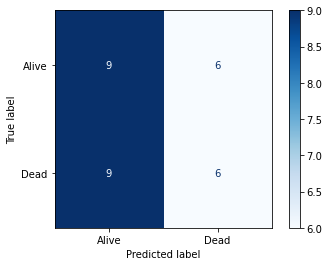

In [165]:
warnings.filterwarnings("ignore")
mlp = MLPClassifier()
mlp_acc = []
mlp_conf = []
mlp_f1 = []
mlp_rocauc = []
mlp_m_score = []
kf = KFold(n_splits=10, random_state=None, shuffle=False)
for train_index, test_index in kf.split(X1, y1):
    X_train, X_test = X1[train_index], X1[test_index]
    y_train, y_test = y1[train_index], y1[test_index]
    
    mlp.fit(X_train, y_train)
    mlp_y_pred = mlp.predict(X_test)
    
    mlpscores = accuracy_score(y_test,mlp_y_pred)
    mlp_acc.append(mlpscores)
    mlp_mean_acc = np.mean(mlp_acc)
    
    mlp_cm=confusion_matrix(y_test, mlp_y_pred)
    mlp_conf.append(mlp_cm)
    
    mlp_f1_s = f1_score(y_test,mlp_y_pred,average='weighted')
    mlp_f1.append(mlp_f1_s)
    
    mlp_y_pred_prob = mlp.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, mlp_y_pred_prob) # fpr - False positive rate & TPR - True Positive rate
    auc = roc_auc_score(y_test, mlp_y_pred_prob)
    #print("MLP : ROC - AUC Score: {:.2f}".format(auc))
    
    mlp_rocauc_s = roc_auc_score(y_test,mlp_y_pred)
    mlp_rocauc.append(mlp_rocauc_s)
    
    mlp_m_score1 =matthews_corrcoef(y_test, mlp_y_pred)
    mlp_m_score.append(mlp_m_score1)
    
mlp_mean_mathew = np.mean(mlp_m_score)
mean_of_conf = np.mean(mlp_conf,axis=0).round()
print("Model accuracies : ",mlp_acc)
print("\nMLP Mean Model Accuracy : {:.2f} ".format(mlp_mean_acc))
#We can't completely rely on model accuracy for classification, hence we will calculate the confusion matrix
target_names = ['Alive','Dead']
mlp_cv_y_pred = cross_val_predict(mlp, X1, y1, cv=10)
#print(classification_report(y1,mlp_cv_y_pred,target_names = target_names))
print("\nF1 Score : {:.2f}".format(np.mean(mlp_f1)))
#print("\nROC AUC Score : {:.2f} ".format(np.mean(mlp_rocauc)))
#mean_auc = np.mean(aucs)
#print("AUC Score : {:.2f}".format(mean_auc))
print("\nMatthews score : {:.2f}".format(mlp_mean_mathew))

mlp_cmd = ConfusionMatrixDisplay(mean_of_conf, display_labels=['Alive','Dead'])
mlp_cmd.plot(cmap='Blues')


#### GridSearch for MLP

In [166]:
param_grid_mlp = [
        {
            'activation' : ['identity', 'logistic', 'tanh', 'relu'],
            'solver' : ['lbfgs', 'sgd', 'adam'],
            'hidden_layer_sizes': [
             (1,),(2,),(3,),(4,),(5,),(6,),(7,),(8,),(9,),(10,),(11,), (12,),(13,),(14,),(15,),(16,),(17,),(18,),(19,),(20,),(21,)
             ]
        }
       ]

mlp_grid = GridSearchCV(mlp, param_grid_mlp, n_jobs=-1, cv=10)
mlp_grid.fit(X1, y1)

GridSearchCV(cv=10, estimator=MLPClassifier(), n_jobs=-1,
             param_grid=[{'activation': ['identity', 'logistic', 'tanh',
                                         'relu'],
                          'hidden_layer_sizes': [(1,), (2,), (3,), (4,), (5,),
                                                 (6,), (7,), (8,), (9,), (10,),
                                                 (11,), (12,), (13,), (14,),
                                                 (15,), (16,), (17,), (18,),
                                                 (19,), (20,), (21,)],
                          'solver': ['lbfgs', 'sgd', 'adam']}])

In [167]:
mlp_grid.best_params_

{'activation': 'tanh', 'hidden_layer_sizes': (19,), 'solver': 'adam'}

In [168]:
mlp_grid.best_score_

0.5636559139784946

## Model 6b for geriatric features 

Model accuracies :  [0.41935483870967744, 0.3225806451612903, 0.3333333333333333, 0.5333333333333333, 0.5, 0.4666666666666667, 0.5333333333333333, 0.5, 0.4, 0.36666666666666664]

MLP_GER Mean Model Accuracy : 0.44 

F1 Score : 0.43

Matthews score : -0.03


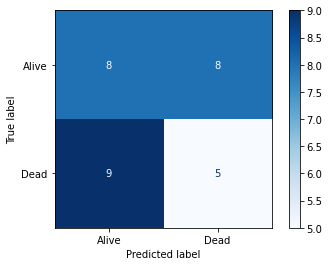

In [169]:
warnings.filterwarnings("ignore")
mlp_ger = MLPClassifier()
mlp_ger_acc = []
mlp_ger_conf = []
mlp_ger_f1 = []
mlp_ger_rocauc = []
mlp_ger_m_score = []
kf = KFold(n_splits=10, random_state=None, shuffle=False)
for train_index, test_index in kf.split(X_ger, Y_ger):
    X_train_ger, X_test = X_ger[train_index], X_ger[test_index]
    y_train_ger, y_test = Y_ger[train_index], Y_ger[test_index]
    
    mlp_ger.fit(X_train_ger, y_train_ger)
    mlp_ger_y_pred = mlp_ger.predict(X_test)
    
    mlp_gerscores = accuracy_score(y_test,mlp_ger_y_pred)
    mlp_ger_acc.append(mlp_gerscores)
    mlp_ger_mean_acc = np.mean(mlp_ger_acc)
    
    mlp_ger_cm=confusion_matrix(y_test, mlp_ger_y_pred)
    mlp_ger_conf.append(mlp_ger_cm)
    
    mlp_ger_f1_s = f1_score(y_test,mlp_ger_y_pred,average='weighted')
    mlp_ger_f1.append(mlp_ger_f1_s)
    
    mlp_ger_y_pred_prob = mlp_ger.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, mlp_ger_y_pred_prob) # fpr - False positive rate & TPR - True Positive rate
    auc = roc_auc_score(y_test, mlp_ger_y_pred_prob)
    #print("MLP_GER : ROC - AUC Score: {:.2f}".format(auc))
    
    mlp_ger_rocauc_s = roc_auc_score(y_test,mlp_ger_y_pred)
    mlp_ger_rocauc.append(mlp_ger_rocauc_s)
    
    mlp_ger_m_score1 =matthews_corrcoef(y_test, mlp_ger_y_pred)
    mlp_ger_m_score.append(mlp_ger_m_score1)
    
mlp_ger_mean_mathew = np.mean(mlp_ger_m_score)
mean_of_conf = np.mean(mlp_ger_conf,axis=0).round()
print("Model accuracies : ",mlp_ger_acc)
print("\nMLP_GER Mean Model Accuracy : {:.2f} ".format(mlp_ger_mean_acc))
#We can't completely rely on model accuracy for classification, hence we will calculate the confusion matrix
target_names = ['Alive','Dead']
mlp_ger_cv_y_pred = cross_val_predict(mlp_ger, X_ger, Y_ger, cv=10)
#print(classification_report(y1,mlp_ger_cv_y_pred,target_names = target_names))
print("\nF1 Score : {:.2f}".format(np.mean(mlp_ger_f1)))
#print("\nROC AUC Score : {:.2f} ".format(np.mean(mlp_ger_rocauc)))
#mean_auc = np.mean(aucs)
#print("AUC Score : {:.2f}".format(mean_auc))
print("\nMatthews score : {:.2f}".format(mlp_ger_mean_mathew))

mlp_ger_cmd = ConfusionMatrixDisplay(mean_of_conf, display_labels=['Alive','Dead'])
mlp_ger_cmd.plot(cmap='Blues')


#### Hyperparameter tuning

In [170]:
ger_mlp_grid = GridSearchCV(mlp_ger, param_grid_mlp, n_jobs=-1, cv=10)
ger_mlp_grid.fit(X_ger, Y_ger)

GridSearchCV(cv=10, estimator=MLPClassifier(), n_jobs=-1,
             param_grid=[{'activation': ['identity', 'logistic', 'tanh',
                                         'relu'],
                          'hidden_layer_sizes': [(1,), (2,), (3,), (4,), (5,),
                                                 (6,), (7,), (8,), (9,), (10,),
                                                 (11,), (12,), (13,), (14,),
                                                 (15,), (16,), (17,), (18,),
                                                 (19,), (20,), (21,)],
                          'solver': ['lbfgs', 'sgd', 'adam']}])

In [171]:
ger_mlp_grid.best_params_

{'activation': 'logistic', 'hidden_layer_sizes': (4,), 'solver': 'adam'}

In [172]:
ger_mlp_grid.best_score_

0.5497849462365592

## All models have improved after hypertuning so we will now compare the models using these hypertuned parameters from the model building steps above

### Consolidated Metrics - Clinical Features 

In [173]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

classifiers = [KNeighborsClassifier(algorithm= 'auto', n_neighbors = 29, weights= 'uniform'), 
               DecisionTreeClassifier(criterion='gini',max_depth= 1,max_leaf_nodes = 2,min_samples_split= 2),
               RandomForestClassifier(criterion= 'gini', max_depth= 16, max_leaf_nodes= 2, min_samples_split= 2), 
               SVC(probability=True,C= 10, gamma= 0.01),
               XGBClassifier(use_label_encoder=False,eval_metric = "logloss",colsample_bytree= 0.3,gamma= 0.0,learning_rate= 0.2,max_depth= 3,min_child_weight= 7),
               MLPClassifier(activation= 'tanh', hidden_layer_sizes = (9,), solver= 'adam',random_state=1)]
clfs = ["KNN", "Decision Tree","Random Forest","SVM","XGBoost","MLP" ]
columns=['Classifier','Accuracy','ROC_AUC','f1_score','f1_weighted','f1_macro','Conf_Mat','Matthew score']
df1 = pd.DataFrame(columns=columns)
data = []
acc = []
f1 = []
f1w = []
f1mac = []
rocauc=[]
mat = []
f1mic = []
conf = []

#Metrics for ML models
for classifier, name in zip(classifiers, clfs):
    for train_index, test_index in kf.split(X1, y1):
        X_train, X_test = X1[train_index], X1[test_index]
        y_train, y_test = y1[train_index], y1[test_index]
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        start = time.time()
    
        # accuracy
        scores = accuracy_score(y_test,y_pred)
        acc.append(scores)
        
        #Confusion Matrix
        cm=confusion_matrix(y_test,y_pred)
        conf.append(cm)
        
        #F1 score
        f1_s = f1_score(y_test,y_pred,average='binary')
        f1.append(f1_s)

        #F1 score - weigted
        f1_w = f1_score(y_test,y_pred,average='weighted')
        f1w.append(f1_w)

        #F1 score - micro
        f1_mic = f1_score(y_test,y_pred,average='micro')
        f1mic.append(f1_mic)

        #F1 score - macro
        f1_mac = f1_score(y_test,y_pred,average='macro')
        f1mac.append(f1_mac)

        #ROC-AUC score
        y_pred_prob = classifier.predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob) # fpr - False positive rate & TPR - True Positive rate
        auc = roc_auc_score(y_test, y_pred_prob)
       # rocauc_s = roc_auc_score(y_test,y_pred)
        #rocauc.append(rocauc_s)
        rocauc.append(auc)

        #Matthews Correlation Coefficient
        mat_cor = matthews_corrcoef(y_test, y_pred)
        mat.append(mat_cor)
           
    mean_acc = statistics.mean(acc)
    mean_of_conf = np.mean(conf,axis = 0).round()
    avg_f1_scr = np.mean(f1)
    avg_f1_wgt_scr = np.mean(f1w)
    avg_f1_mac_scr = np.mean(f1mac)
    avg_f1_mic_scr = np.mean(f1mic)
    avg_rocauc_scr = np.mean(rocauc)
    avg_mat_cor = np.mean(mat)
    #Appending the values in the data frame 
    dict1 = {'Classifier':name,'Accuracy': mean_acc,'ROC_AUC':avg_rocauc_scr,'f1_score':avg_f1_scr,'f1_weighted':avg_f1_wgt_scr,'f1_macro':avg_f1_mac_scr,'Conf_Mat':mean_of_conf,'Matthew score':avg_mat_cor}
    df1 = df1.append(dict1, ignore_index = True)

In [174]:
#Appending the values in the data frame 
cprint("Consolidated metrics for Clinical Features","red",attrs = ['bold'])
print(tabulate(df1, headers='keys', tablefmt='fancy_grid',showindex="never"))

Consolidated metrics for Clinical Features
╒═══════════════╤════════════╤═══════════╤════════════╤═══════════════╤════════════╤═════════════╤═════════════════╕
│ Classifier    │   Accuracy │   ROC_AUC │   f1_score │   f1_weighted │   f1_macro │ Conf_Mat    │   Matthew score │
╞═══════════════╪════════════╪═══════════╪════════════╪═══════════════╪════════════╪═════════════╪═════════════════╡
│ KNN           │   0.527419 │  0.545481 │   0.481782 │      0.529979 │   0.518141 │ [[9. 6.]    │       0.104477  │
│               │            │           │            │               │            │  [8. 7.]]   │                 │
├───────────────┼────────────┼───────────┼────────────┼───────────────┼────────────┼─────────────┼─────────────────┤
│ Decision Tree │   0.52586  │  0.535915 │   0.394151 │      0.505929 │   0.492501 │ [[11.  5.]  │       0.078991  │
│               │            │           │            │               │            │  [10.  5.]] │                 │
├───────────────┼────

### ROC-AUC curve for all Supervised learning models (clinical features)

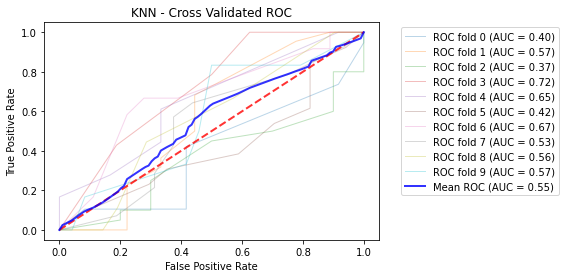

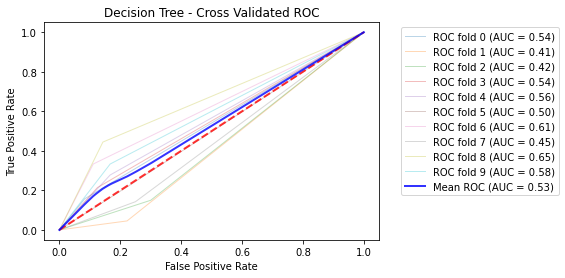

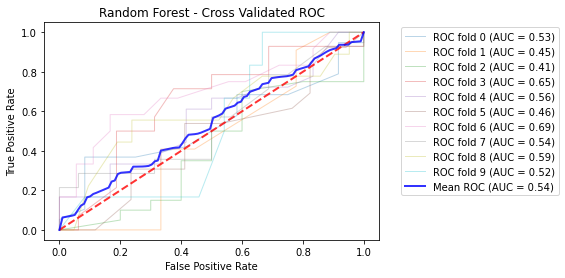

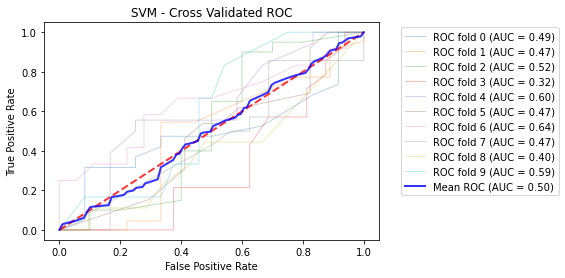

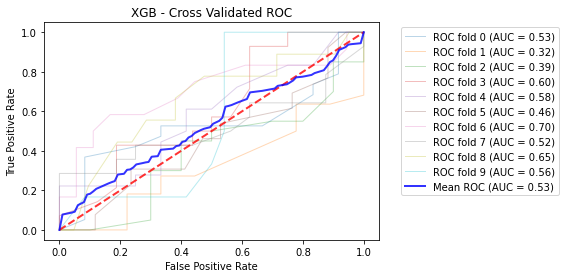

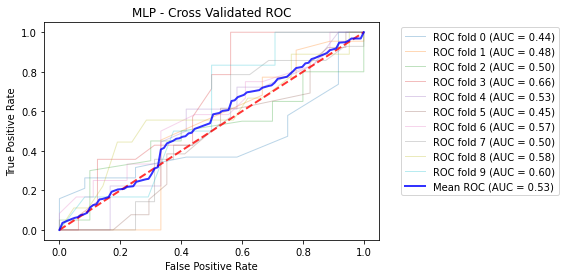

In [175]:
import warnings 
warnings.filterwarnings("ignore")
from sklearn.metrics import auc
def plot_ROC_AUC_clfs(classifier, cv, X1, y1, title='ROC Curve'):
# Creating ROC Curve with Cross Validation
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    i = 0
    for train, test in cv.split(X1, y1):
        #pred = classifier.fit(X1[train], y1[train]).predict(X1[test])  # without probability
        pred = classifier.fit(X1[train], y1[train]).predict_proba(X1[test])
              # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y1[test], pred[:, 1])
      
        #fpr, tpr, thresholds = roc_curve(y1[test], pred)# without probability
        
        tprs.append(np.interp(mean_fpr, fpr, tpr))
      
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1
        
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f)' % (mean_auc),
             lw=2, alpha=.8)
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="best",bbox_to_anchor=(1.05, 1))
    plt.show()

    # Setting up Classifiers            
clf = KNeighborsClassifier(algorithm= 'auto', n_neighbors = 29, weights= 'uniform')
clf1 = DecisionTreeClassifier(criterion='gini',max_depth= 1,max_leaf_nodes = 2,min_samples_split= 2)
clf2 = RandomForestClassifier(criterion= 'gini', max_depth= 16, max_leaf_nodes= 2, min_samples_split= 2)
clf3 = SVC(probability=True,C= 10, gamma= 0.01)
clf4 = XGBClassifier(use_label_encoder=False,eval_metric = "logloss",colsample_bytree= 0.3,gamma= 0.0,learning_rate= 0.2,max_depth= 3,min_child_weight= 7)
clf5 = MLPClassifier(activation= 'tanh', hidden_layer_sizes = (9,), solver= 'adam',random_state=1)

# Set up K Fold
cv = KFold(n_splits=10)
#Plotting the curve
plot_ROC_AUC_clfs(clf, cv, X1, y1, title='KNN - Cross Validated ROC')
plot_ROC_AUC_clfs(clf1, cv, X1, y1, title='Decision Tree - Cross Validated ROC')
plot_ROC_AUC_clfs(clf2, cv, X1, y1, title='Random Forest - Cross Validated ROC')
plot_ROC_AUC_clfs(clf3, cv, X1, y1, title='SVM - Cross Validated ROC')
plot_ROC_AUC_clfs(clf4, cv, X1, y1, title='XGB - Cross Validated ROC')
plot_ROC_AUC_clfs(clf5, cv, X1, y1, title='MLP - Cross Validated ROC')

# Geriatic Features ('BOMC', MOS', 'TUG' and 'IADL')


# ML model building (Supervised)

In [176]:
classifiers = [KNeighborsClassifier(algorithm= 'brute',n_neighbors=3, weights='uniform'), 
               DecisionTreeClassifier(criterion='gini',max_depth= 1,max_leaf_nodes = 2,min_samples_split= 2),
               RandomForestClassifier(criterion= 'gini', max_depth= 17, max_leaf_nodes= 2, min_samples_split= 2), 
               SVC(probability=True,C= 1, gamma= 0.01),
               XGBClassifier(use_label_encoder=False,eval_metric = "logloss",colsample_bytree= 0.3,gamma= 0.0,learning_rate= 0.1,max_depth= 3,min_child_weight= 1),
               MLPClassifier(activation= 'logistic', hidden_layer_sizes = (18,), solver= 'sgd',random_state=1)]

clfs = ["KNN", "Decision Tree","Random Forest","SVM","XGBoost","MLP"]
columns=['Classifier','Accuracy','ROC_AUC','f1_score','f1_weighted','f1_macro','Conf_Mat','Matthew_score']
df2 = pd.DataFrame(columns=columns)

ger_accu = []
ger_f1 = []
ger_f1w = []
ger_f1mac = []
ger_f1mic = []
ger_rocauc=[]
ger_mat = []
ger_conf = []

# Metrics for ML models
for classifier, name in zip(classifiers, clfs):
    for train_index, test_index in kf.split(X_ger, Y_ger):
        X_train_ger, X_test_ger = X_ger[train_index], X_ger[test_index]
        y_train_ger, y_test_ger = Y_ger[train_index], Y_ger[test_index]
        classifier.fit(X_train_ger, y_train_ger)
        y_pred_ger = classifier.predict(X_test_ger)
    
       # accuracy
        score = accuracy_score(y_test_ger,y_pred_ger)
        ger_accu.append(score)
        
        #Confusion Matrix
        ger_cm=confusion_matrix(y_test_ger,y_pred_ger)
        ger_conf.append(ger_cm)
        
        #F1 score
        ger_f1_s = f1_score(y_test_ger,y_pred_ger,average='binary',zero_division='warn')
        ger_f1.append(ger_f1_s)

        #F1 score - Weighted
        ger_f1_w = f1_score(y_test_ger,y_pred_ger,average='weighted',zero_division='warn')
        ger_f1w.append(ger_f1_w)

        #F1 score - Micro
        ger_f1_mic = f1_score(y_test_ger,y_pred_ger,average='micro',zero_division='warn')
        ger_f1mic.append(ger_f1_mic)

        #F1 score - Macro
        ger_f1_mac = f1_score(y_test_ger,y_pred_ger,average='macro',zero_division='warn')
        ger_f1mac.append(ger_f1_mac)
    
        #ROC-AUC score
        ger_y_pred_prob = classifier.predict_proba(X_test_ger)[:,1]
        ger_fpr, ger_tpr, thresholds = roc_curve(y_test_ger, ger_y_pred_prob) # fpr - False positive rate & TPR - True Positive rate
        ger_auc = roc_auc_score(y_test_ger, ger_y_pred_prob)
        ger_rocauc.append(ger_auc)
    
        #Matthews Correlation Coefficient
        ger_mat_cor = matthews_corrcoef(y_test_ger, y_pred_ger)
        ger_mat.append(ger_mat_cor)
        
    ger_acc = statistics.mean(ger_accu)
    ger_avg_f1_scr = np.mean(ger_f1)
    ger_avg_f1_wgt_scr = np.mean(ger_f1w)
    ger_avg_f1_mic_scr = np.mean(ger_f1mic)
    ger_avg_f1_mac_scr = np.mean(ger_f1mac)
    ger_avg_mat_cor = np.mean(ger_mat)
    ger_avg_conf = np.mean(ger_conf,axis = 0).round()
    ger_avg_rocauc_scr = np.mean(ger_rocauc)
    
    dict2 = {'Classifier':name,'Accuracy': ger_acc,'ROC_AUC':ger_avg_rocauc_scr,'f1_score':ger_avg_f1_scr,'f1_weighted':ger_avg_f1_wgt_scr,'f1_macro':ger_avg_f1_mac_scr,'Conf_Mat':ger_avg_conf,'Matthew_score':ger_avg_mat_cor}
    df2 = df2.append(dict2, ignore_index = True)


### Consolidated metrics  - Geriatric Features

In [177]:
#Appending the values in the data frame 
cprint('Consolidated Metrics for Geriatric Features','red', attrs=['bold'])
print(tabulate(df2, headers='keys', tablefmt='fancy_grid',showindex="never"))

Consolidated Metrics for Geriatric Features
╒═══════════════╤════════════╤═══════════╤════════════╤═══════════════╤════════════╤═════════════╤═════════════════╕
│ Classifier    │   Accuracy │   ROC_AUC │   f1_score │   f1_weighted │   f1_macro │ Conf_Mat    │   Matthew_score │
╞═══════════════╪════════════╪═══════════╪════════════╪═══════════════╪════════════╪═════════════╪═════════════════╡
│ KNN           │   0.553333 │  0.539851 │   0.48266  │      0.552663 │   0.526762 │ [[10.  6.]  │      0.103852   │
│               │            │           │            │               │            │  [ 8.  7.]] │                 │
├───────────────┼────────────┼───────────┼────────────┼───────────────┼────────────┼─────────────┼─────────────────┤
│ Decision Tree │   0.510323 │  0.517204 │   0.36834  │      0.476747 │   0.457603 │ [[10.  5.]  │      0.0409084  │
│               │            │           │            │               │            │  [ 9.  5.]] │                 │
├───────────────┼───

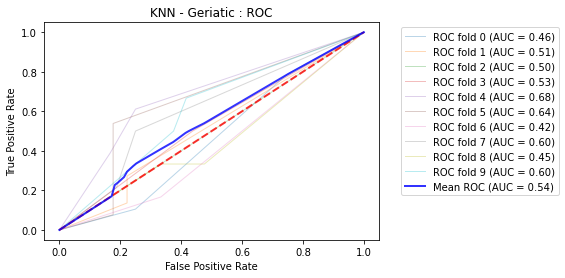

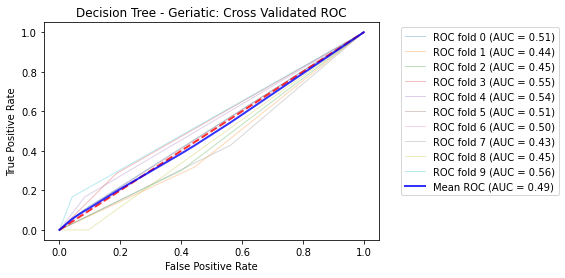

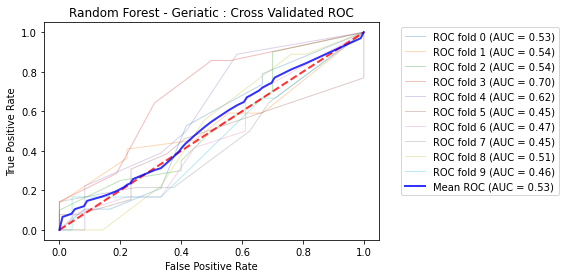

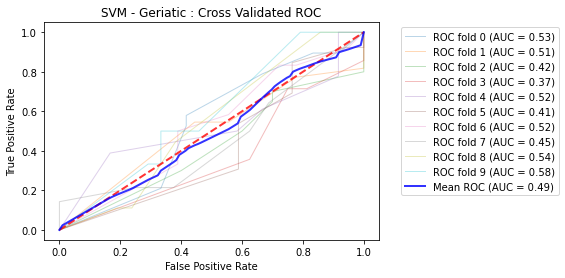

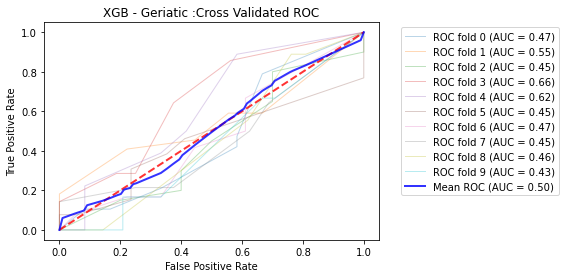

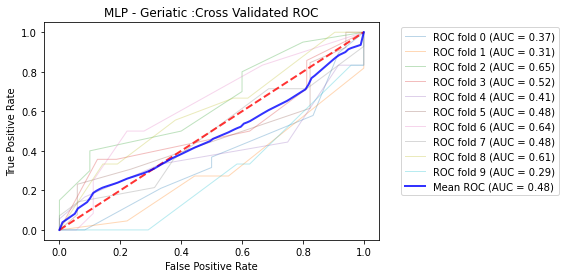

In [178]:
from sklearn import metrics
def plot_ROC_AUC_ger(classifier, cv, X_ger, Y_ger, title='ROC Curve'):
       # Creating ROC Curve with Cross Validation
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    i = 0
    for train, test in cv.split(X_ger, Y_ger):
        pred_ger = classifier.fit(X_ger[train], Y_ger[train]).predict_proba(X_ger[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(Y_ger[test], pred_ger[:, 1])
        tprs.append(np.interp(mean_fpr, fpr, tpr))

        tprs[-1][0] = 0.0
        roc_auc = metrics.auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
   
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f)' % (mean_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    #plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                #     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="best",bbox_to_anchor=(1.05, 1))
    plt.show()
    
# Setting up Classifiers
clf = KNeighborsClassifier(algorithm= 'brute',n_neighbors=3, weights='uniform')
clf1 = DecisionTreeClassifier(criterion='gini',max_depth= 1,max_leaf_nodes = 2,min_samples_split= 2)
clf2 = RandomForestClassifier(criterion= 'gini', max_depth= 17, max_leaf_nodes= 2, min_samples_split= 2)
clf3 = SVC(probability=True,C= 1, gamma= 0.01)
clf4 = XGBClassifier(use_label_encoder=False,eval_metric = "logloss",colsample_bytree= 0.3,gamma= 0.0,learning_rate= 0.1,max_depth= 3,min_child_weight= 1)
clf5 = MLPClassifier(activation= 'logistic', hidden_layer_sizes = (18,), solver= 'sgd',random_state=1)

# Set up K Fold
cv = KFold(n_splits=10)

#Plotting AUC curve
plot_ROC_AUC_ger(clf, cv, X_ger, Y_ger, title='KNN - Geriatic : ROC')
plot_ROC_AUC_ger(clf1, cv,X_ger, Y_ger, title='Decision Tree - Geriatic: Cross Validated ROC')
plot_ROC_AUC_ger(clf2, cv, X_ger, Y_ger, title='Random Forest - Geriatic : Cross Validated ROC')
plot_ROC_AUC_ger(clf3, cv, X_ger, Y_ger, title='SVM - Geriatic : Cross Validated ROC')
plot_ROC_AUC_ger(clf4, cv, X_ger, Y_ger, title='XGB - Geriatic :Cross Validated ROC')
plot_ROC_AUC_ger(clf5, cv, X_ger, Y_ger, title='MLP - Geriatic :Cross Validated ROC')

## From these comparisons, we can see that the KNN model is the best model for both the clinical features and the geriatric features models.
## We will now run these two models so that we can statistically compare their results.

### KNN clinical features model:

In [179]:
knn=KNeighborsClassifier(algorithm= 'auto', n_neighbors = 29, weights= 'uniform')     # the hypertuned parameters

In [180]:
knn_acc = []
knn_conf = []
knn_f1 = []
knn_rocauc = []
knn_m_score = []
kf = KFold(n_splits=10, random_state=None, shuffle=False)
for train_index, test_index in kf.split(X1, y1):
    X_train, X_test = X1[train_index], X1[test_index]
    y_train, y_test = y1[train_index], y1[test_index]
    
    knn.fit(X_train, y_train)
    knn_y_pred = knn.predict(X_test)
    
    knnscores = accuracy_score(y_test,knn_y_pred)
    knn_acc.append(knnscores)
    knn_mean_acc = np.mean(knn_acc)
    
    knn_cm=confusion_matrix(y_test, knn_y_pred)
    knn_conf.append(knn_cm)
    
    knn_f1_s = f1_score(y_test,knn_y_pred,average='weighted')
    knn_f1.append(knn_f1_s)
    
    knn_y_pred_prob = knn.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, knn_y_pred_prob) # fpr - False positive rate & TPR - True Positive rate
    auc = roc_auc_score(y_test, knn_y_pred_prob)
    #print("KNN : ROC - AUC Score: {:.2f}".format(auc))
    
    knn_rocauc_s = roc_auc_score(y_test,knn_y_pred)
    knn_rocauc.append(knn_rocauc_s)
    
    knn_m_score1 =matthews_corrcoef(y_test, knn_y_pred)
    knn_m_score.append(knn_m_score1)
    
knn_mean_mathew = np.mean(knn_m_score)
mean_of_conf = np.mean(knn_conf,axis=0).round()
print("MCC: ", knn_mean_mathew)
print("Model accuracies : ",knn_acc)
print("\nKNN Mean Model Accuracy : {:.2f} ".format(knn_mean_acc))

MCC:  0.10447708482270228
Model accuracies :  [0.3870967741935484, 0.3870967741935484, 0.4666666666666667, 0.6333333333333333, 0.6, 0.5, 0.7, 0.5333333333333333, 0.5, 0.5666666666666667]

KNN Mean Model Accuracy : 0.53 


### KNN model for Geriatric features

In [181]:
knn_ger = KNeighborsClassifier(algorithm= 'brute',n_neighbors=3, weights='uniform')
knn_ger_acc = []
knn_ger_conf = []
knn_ger_f1 = []
knn_ger_rocauc = []
knn_ger_m_score = []
kf = KFold(n_splits=10, random_state=None, shuffle=False)
for train_index, test_index in kf.split(X_ger, Y_ger):
    X_train, X_test = X_ger[train_index], X_ger[test_index]
    y_train, y_test = Y_ger[train_index], Y_ger[test_index]
    
    knn_ger.fit(X_train, y_train)
    knn_ger_y_pred = knn_ger.predict(X_test)
    
    knngerscores = accuracy_score(y_test,knn_ger_y_pred)
    knn_ger_acc.append(knngerscores)
    knn_ger_mean_acc = np.mean(knn_ger_acc)
    
    knn_ger_cm=confusion_matrix(y_test, knn_ger_y_pred)
    knn_ger_conf.append(knn_ger_cm)
    
    knn_ger_f1_s = f1_score(y_test,knn_ger_y_pred,average='micro')
    knn_ger_f1.append(knn_ger_f1_s)
    
    knn_ger_y_pred_prob = knn_ger.predict_proba(X_test)[:,1]
    fpr_ger, tpr_ger, thresholds = roc_curve(y_test, knn_ger_y_pred_prob) # fpr - False positive rate & TPR - True Positive rate
    auc_ger = roc_auc_score(y_test, knn_ger_y_pred_prob)
    #print("KNN : ROC - AUC Score: {:.2f}".format(auc))
    
    knn_ger_rocauc_s = roc_auc_score(y_test,knn_ger_y_pred)
    knn_ger_rocauc.append(knn_ger_rocauc_s)
    
    knn_ger_m =matthews_corrcoef(y_test, knn_ger_y_pred)
    knn_ger_m_score.append(knn_ger_m)

knn_ger_mean_mathew = np.mean(knn_ger_m_score)
print("MCC: ", knn_ger_mean_mathew)
print("Model accuracies : ",knn_ger_acc)
print("\nKnn Mean Model Accuracy : {:.2f} ".format(knn_ger_mean_acc))


MCC:  0.10385161693660334
Model accuracies :  [0.5806451612903226, 0.41935483870967744, 0.4666666666666667, 0.5333333333333333, 0.6666666666666666, 0.7, 0.4666666666666667, 0.6333333333333333, 0.4666666666666667, 0.6]

Knn Mean Model Accuracy : 0.55 


# Statistically compare these two models to see if there is a significant difference in their performances.

## KNN (clinical) vs KNN (Geriatric)

In [182]:
from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu(knn_acc,knn_ger_acc)
print("P value is {:2f}".format(p))
alpha = 0.05
if p > alpha:
    print('Same distribution, not statistically significant (accept null hypothesis(H0))')
else:
    print('Different distribution, statistically significant (reject null hypothesis(H0))')

P value is 0.324083
Same distribution, not statistically significant (accept null hypothesis(H0))


## p > 0.05 so we accept the null hypothesis. This means that there is no significant difference between the perfomances of the two models. 

## kolmogorov-smirnov two-sample test

In [183]:
from scipy.stats import kstest,ks_2samp
from scipy import stats
test1_stat = kstest(knn_acc, 'norm')
test2_stat = kstest(knn_ger_acc, 'norm')
stat, p = ks_2samp(test1_stat,test2_stat)
print("P value is {:2f}".format(p))
alpha = 0.05
if p > alpha:
    print('Same distribution, not statisitcally significant (accept null hypothesis(H0))')
else:
    print('Different distribution, statistically significant (reject null hypothesis(H0))')


P value is 1.000000
Same distribution, not statisitcally significant (accept null hypothesis(H0))
